In [1]:
!pip install pydicom
!pip install pylidc
!pip install torchsummary
!pip install imageio
!pip install gsutil

     |████████████████████████████████| 2.0 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 66.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 71.4 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 98.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 61.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 109.7 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
     |████████████████████████████████| 2.9 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 74.2 MB/s eta 0:00:01
     |████████████████

In [1]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys

In [2]:
def set_dicom_path(dicom_path):
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_path +'\n')
    f.write('warn = True')
    f.close()

In [3]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [4]:
def find_all_bboxes(nodule_annotation, nodule_id, plot=False):
    bboxes = []
    #cmask, cbbox, masks = consensus(nodule_annotation)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        

    print("There are {} slices in the image".format(cbbox_CT[nodule_id][2].stop - cbbox_CT[nodule_id][2].start))
    for idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,idx])
        if plot:
            plot_bounding_box(CT_mask[:,:,idx])
        bboxes.append(boxes)
    return bboxes

In [5]:
def plot_bbox_on_full_size_mask(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        plot_bounding_box(CT_mask[:,:,slice_idx])

In [6]:
def plot_bbox_on_image(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,slice_idx])
        img = vol[:,:,slice_idx]
        fig, ax = plt.subplots()
        ax.imshow(img, cmap=plt.cm.gray)
        if boxes:
            for box in boxes:
                x, y, w, h = box
                print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

In [7]:
import shutil
def clear_dirs(paths):
    for path in paths:
        if os.path.isdir(path):
            shutil.rmtree(path)

In [8]:
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

In [9]:
def un(a, b):
    return np.union1d(a, b)

def unr(ll, acc, i):
    if i < len(ll):
        j = i + 1
        acc = un(ll[i], acc)
        return unr(ll, acc, j)
    else:
        return acc

def get_slices_with_masks(cbbox_CT):
    ll = []
    for cb in cbbox_CT:
        ll.append(np.arange(cb[2].start, cb[2].stop+1))
    return unr(ll, [], 0)

In [10]:

#patient_id = patient_list_test[0]

def load_patient_vol_and_mask(dicom_dir, patient_id=-1):
    
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_dir +'\n')
    f.write('warn = True')
    f.close()

    patient_list = os.listdir(dicom_dir)
    if patient_id == -1: #select one randomly
        patient_id = np.random.choice(patient_list)
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    try:
        #with RedirectStdStreams(stdout=devnull, stderr=devnull):
        vol = scan.to_volume()
    except:
        print("Error loading DICOM for patient {}".format(patient_id))
        return None, None, None, None
    # are there nodules that are useful?

    # process the mask for the image
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        if len(nodule) >= 4:
            cmask, cbbox, masks = consensus(nodule)
            cmask_CT.append(cmask)
            cbbox_CT.append(cbbox)
            masks_CT.append(masks)

    if len(cbbox_CT) <=0:
        print("No relevant nodules for patient {}".format(patient_id))
        return None, None, None, None


    # create the mask voxel
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    #print("Number of nodules {}".format(nodule_num))
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask

    # get the slices that have annotations
    slices_with_mask = get_slices_with_masks(cbbox_CT)
    
    return vol, CT_mask, cbbox_CT, slices_with_mask

In [11]:
def plot_side_by_side(vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[:,:,idx])
    a[1].imshow(mask[:,:,idx])
    plt.show()

# get 8 pixels along all axes
def plot_side_by_side_cropped(cbbox, vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    a[1].imshow(mask[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    plt.show()

### UNET data augmentation

- With slight changes to the cropping strategy of the image, the prediction radically changes
- We need to have a better data augmentation for the model training, the random image generation with nodule does not seem to be doing a good job

In [350]:
import cv2
from pathlib import Path
import random
import math

In [351]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [352]:
def resize_image(read_path,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    #new_path = str(write_path/read_path.parts[-1])
    #cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return im_resized

In [353]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def random_cropXY(x, Y, r_pix=8, cnt=3):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    lrand_r = np.random.uniform(0, 1, cnt)
    lrand_c = np.random.uniform(0, 1, cnt)
    xxs = []
    YYS = []
    for rand_r, rand_c in zip(lrand_r, lrand_c):
        start_r = np.floor(2*rand_r*r_pix).astype(int)
        start_c = np.floor(2*rand_c*c_pix).astype(int)
        xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
        YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
        xxs.append(xx)
        YYS.append(YY)
    return xxs, YYS

#### Generate data for Unet

- Select patients from the dicom dir
- for each patient, load the volumes and masks
    - Choose only those nodules that are annotated by more than 4 radiologists
    - Select only those slices from the DICOM image which has annotated masks
    - For each of those slices, extract a cropped 64x64 image around the mask with the annotated bounding box in the center
    - Also generate at least one 64x64 image with the center randomly chosen in the annotated bounding box

In [355]:
# take 32 pixels including c_x on each axis
def get_stride(c, size=32):
    start = 0
    if (c - size) > 0:
        start = c - size
    else:
        start = 0
    if (c + size) < 512:
        stop = c + size
    else:
        stop = size
    return slice(start, stop, None)

"""
    Get a 64x64 image around the nodule, when using random = false, we get the actual clip of the annotated nodule,
    when using random = true, get a 64x64 image around the nodule randomly chosen which may or may not show a part of the nodule
"""
def get_nodule_part(cbbox, random=False, shape=(32, 32)):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x, shape[0]), get_stride(c_y, shape[1]), cbbox[2]

"""
    Get a 64x64 image just outside the nodule bounding box 
"""
def get_outside_part(cbbox, random=False):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x, shape[0]), get_stride(c_y, shape[0]), cbbox[2]

In [532]:
def in_box(coord):
    return (coord[0] + 32 < 512) and (coord[0] - 32 > 0) and (coord[1] + 32 < 512) and (coord[1] - 32 > 0)

"""
    Takes multiple bounding boxes and returns slices for each of them, converts box to slice
    sample data: boxes = [(285.5, 280.5, 6.0, 5.0)]
"""
def get_slices(boxes, flipxy=True):
    slices = []
    for box in boxes:
        if flipxy:
            x = int(box[1])
            w = x + int(box[2])
            y = int(box[0])
            h = y + int(box[3])
            slices.append((slice(x, w, None), slice(y, h, None)))
        else:
            x = int(box[0])
            w = x + int(box[2])
            y = int(box[1])
            h = y + int(box[3])
            # slices.append((slice(x, w, None), slice(y, h, None)))
            # add 1 pixel margin to handle issues due to float values flooring from box
            slices.append((slice(y-1, h+1, None), slice(x-1, w+1, None)))
    return slices


# get boxes outside of this slice, get a 64x64 box just outside these slices
def get_all_box_centers(slices, shift, outside_margin=32):
    coords_l = []
    coords_r = []
    coords_t = []
    coords_b = []
    for slc in slices:
        xslc = slc[1]
        yslc = slc[0]
        y = int(yslc.start + (yslc.stop - yslc.start)/2)
        x = int(xslc.start + (xslc.stop - xslc.start)/2)
        coords_l.extend([a for a in zip(np.repeat(xslc.start - shift, (yslc.stop+outside_margin) - (yslc.start-outside_margin)), 
                                      np.arange(yslc.start - outside_margin, yslc.stop + outside_margin))])
        coords_r.extend([a for a in zip(np.repeat(xslc.stop + shift, (yslc.stop+outside_margin) - (yslc.start-outside_margin)), 
                                      np.arange(yslc.start- outside_margin, yslc.stop + outside_margin))])
        coords_t.extend([a for a in zip(np.arange(xslc.start-outside_margin, xslc.stop+outside_margin), 
                                      np.repeat(yslc.stop + shift, (xslc.stop+outside_margin)-(xslc.start-outside_margin)))])
        coords_b.extend([a for a in zip(np.arange(xslc.start-outside_margin, xslc.stop+outside_margin), 
                                      np.repeat(yslc.start - shift, (xslc.stop+outside_margin)-(xslc.start-outside_margin)))])
        coordsl = [crd for crd in coords_l if in_box(crd)]
        coordsr = [crd for crd in coords_r if in_box(crd)]
        coordst = [crd for crd in coords_t if in_box(crd)]
        coordsb = [crd for crd in coords_b if in_box(crd)]
    return (coordsl, coordsr, coordst, coordsb)

"""
    coords: tuple
"""
def get_random_slices(coords, num_select=12):
    coordsl, coordsr, coordst, coordsb = coords
    slices = []
    
    accum = 0
    
    if len(coordsl) > 0:
        idxs = np.random.choice(np.arange(len(coordsl)), int(num_select/4))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordsl[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
        
    if len(coordsr) > 0:
        idxs = np.random.choice(np.arange(len(coordsr)), int((num_select-accum)/3))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordsr[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
        
    if len(coordst) > 0:
        idxs = np.random.choice(np.arange(len(coordst)), int((num_select-accum)/2))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordst[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
        
    if len(coordsb) > 0:
        idxs = np.random.choice(np.arange(len(coordsb)), int((num_select-accum)/1))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordsb[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
            
    return slices

In [522]:
"""
    Save cropped images from source such that none of them contain visible nodule, the images are cropped from around the nodule bounding box
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    num_random_images = number of random crop images to generate around the nodule
"""
def save_surrounding_images(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                            image_save=False, image_plot=True, num_random_images=12):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    voxel = CT_mask[:,:,bounding_box[nodule_number][2]]
    img_voxel = vol[:,:,bounding_box[nodule_number][2]]
    out_masks = []
    out_images = []
    out_slices = None
    for slice_id in range(voxel.shape[2]):
        boxes = get_bounding_box(voxel[:,:,slice_id])
        if boxes is None:
            print("No bounding box for {} and slice {}".format(patient_id, slice_id))
            continue
        slices = get_slices(boxes, False)
        # use a margin of 2 pixels to adjust for the mask pixels in the boundary
        coords = get_all_box_centers(slices, 32+2, 32)
        out_slices = get_random_slices(coords, num_random_images) # get num_random_images random 64x64 images randomly from the image that does not show the mask (i.e., negative samples)
        out_slices = [out_slice + (bounding_box[nodule_number][2],) for out_slice in out_slices]
        for out_slice in out_slices:
            out_masks.append(voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
            out_images.append(img_voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
    
    b = []
    for a1 in unique_slice_ids:
        b.extend(np.repeat(a1, num_random_images))
    for idx, (unique_slice_id, mask)in enumerate(zip(b, out_masks)):
        img = out_images[idx]
        mask = out_masks[idx]
        if img.shape != (64, 64):
            continue
        if mask.shape != (64, 64):
            continue
        if len(np.unique(mask)) > 1:
            continue
        if image_save:
                image_file_name = "img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id)
                mask_file_name = "mask_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, img)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):    
                    imageio.imwrite(mask_dir + mask_file_name, mask)
        if image_plot:
            f, a =  plt.subplots(1,2, figsize=(8,10))
            a[0].imshow(img)
            a[0].set_title("img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id))
            a[1].imshow(mask)
            plt.show()

### Show data generation strategy for the segmentation model

In [ ]:
### DEBUG:
#vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0284')
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')

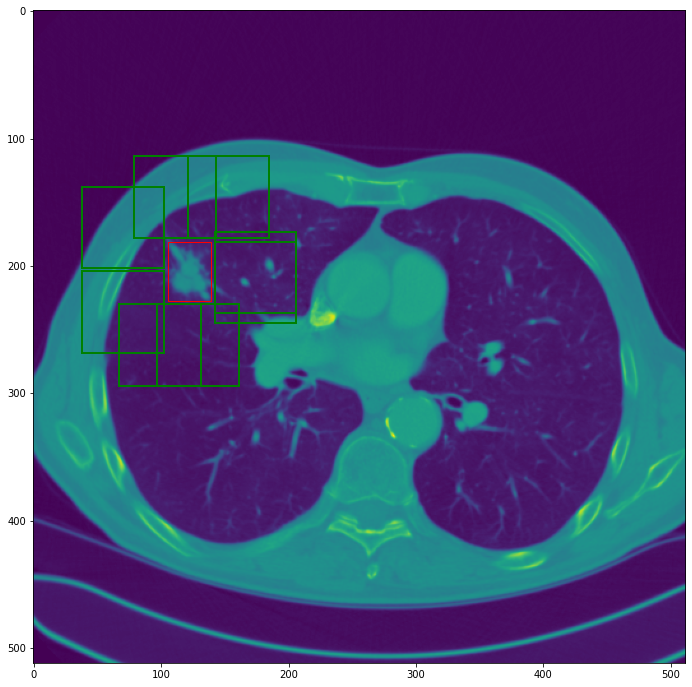

In [529]:
#### Draw outside points and boxes in mask
num_random_images = 8
fig, ax = plt.subplots(figsize=(14,12))
#ax.imshow(vol[:,:,cbbox[0][2]][:,:,2])
ax.imshow(vol[:,:,cbbox[0][2]][:,:,2])
boxes = get_bounding_box(CT_mask[:,:,cbbox[0][2]][:,:,2])
slices = get_slices(boxes, False)
coords = get_all_box_centers(slices, 32+2, 32)
out_slices = get_random_slices(coords, num_random_images)
#slice to bounding box
out_boxes = [(slcy.start, slcx.start, slcy.stop-slcy.start, slcx.stop-slcx.start) for slcx, slcy in out_slices]
if boxes:
    for box in boxes:
        x,y,w,h = box
        #print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
if out_boxes:
    for box in out_boxes:
        x,y,w,h = box
        #print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
# for x,y in coords:
#     ax.plot(x, y, marker="o")

Loading dicom files ... This may take a moment.
There are 2 nodules


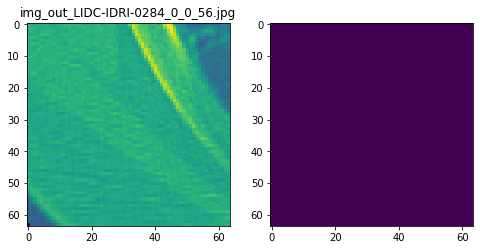

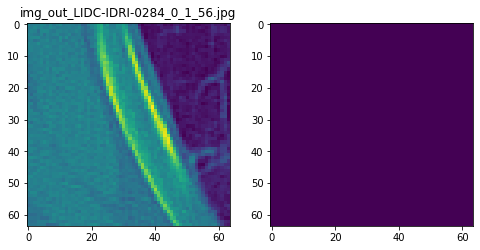

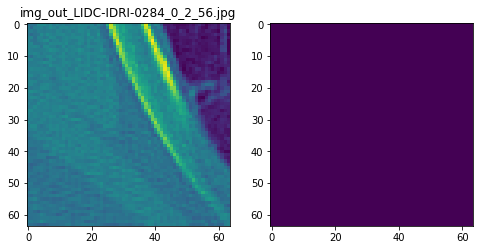

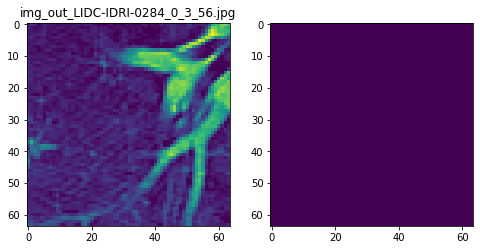

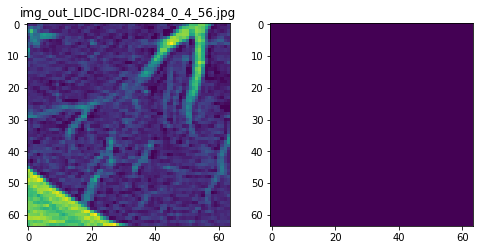

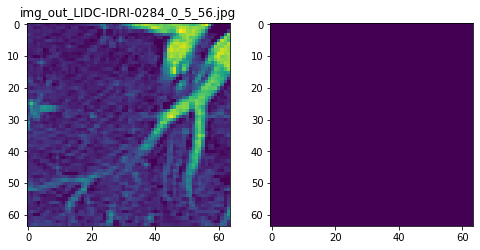

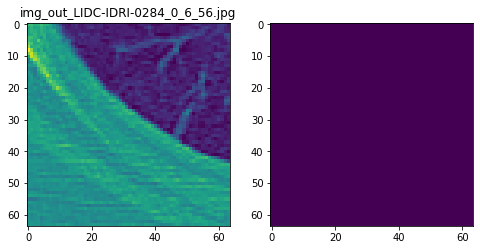

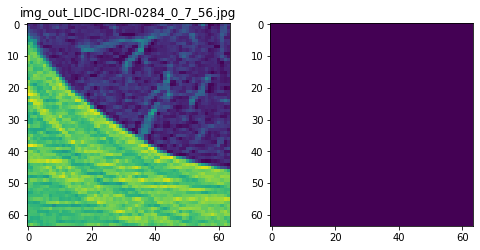

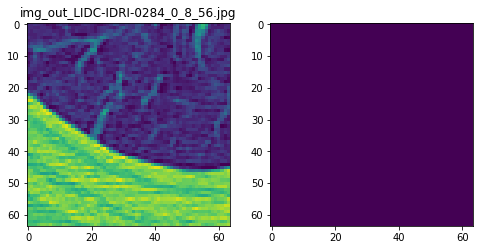

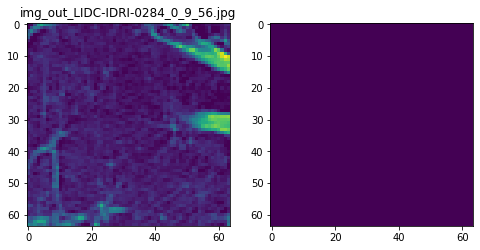

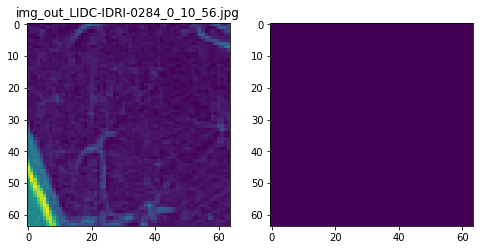

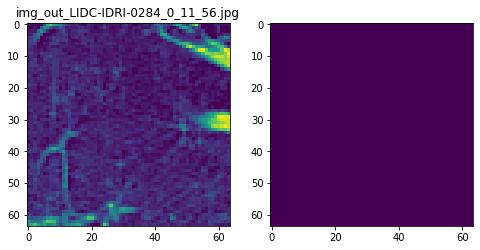

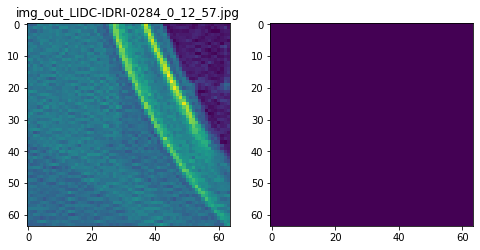

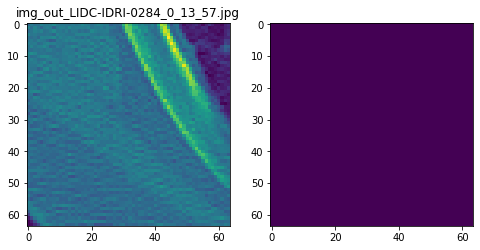

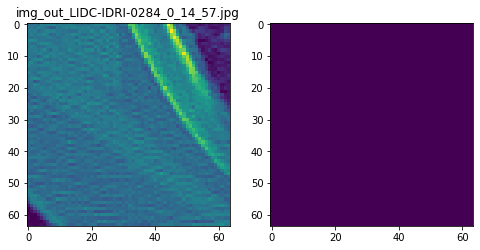

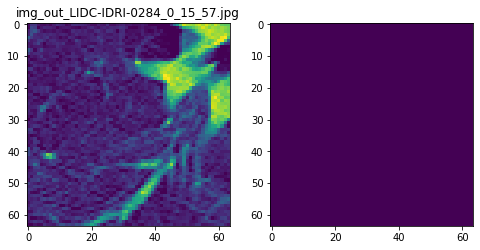

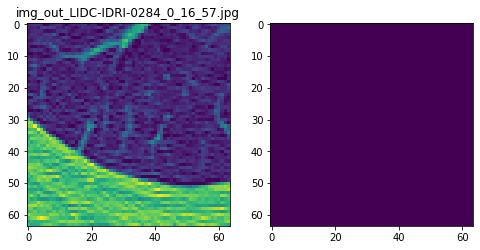

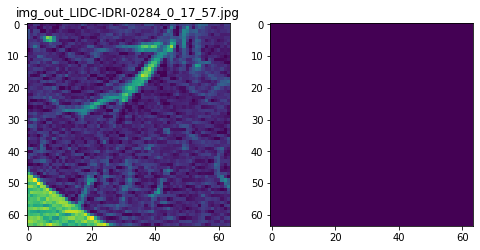

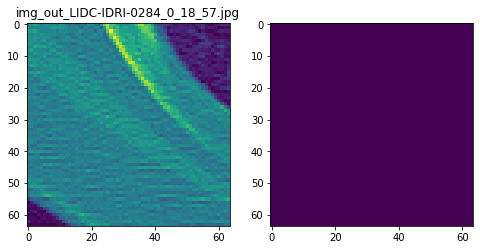

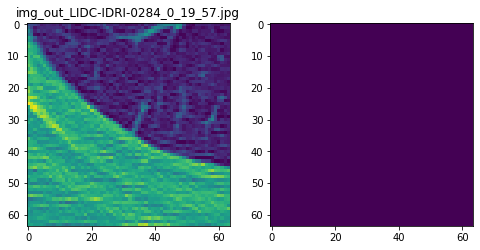

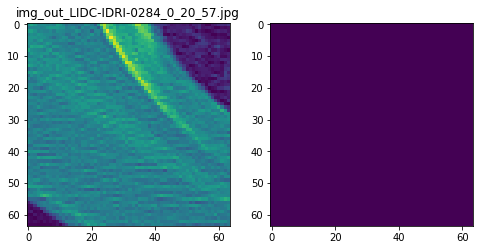

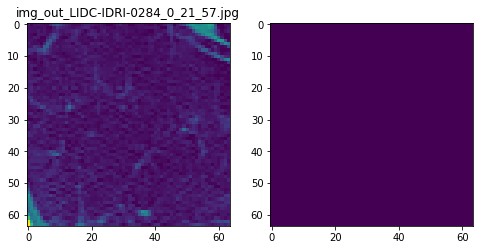

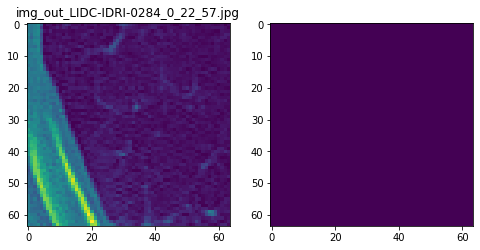

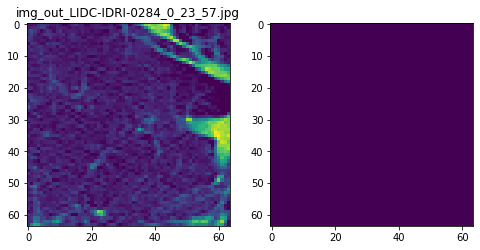

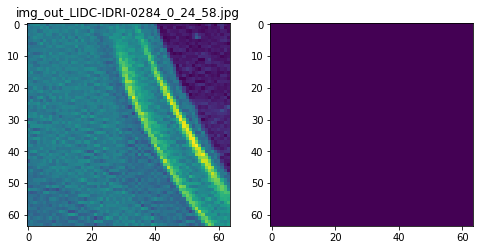

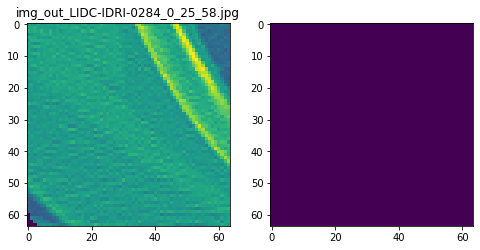

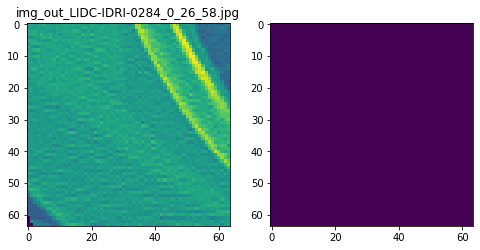

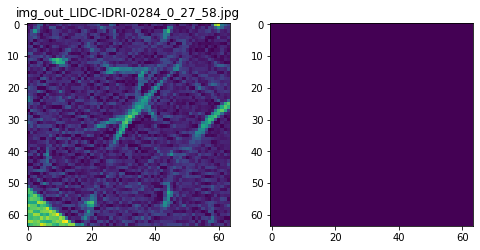

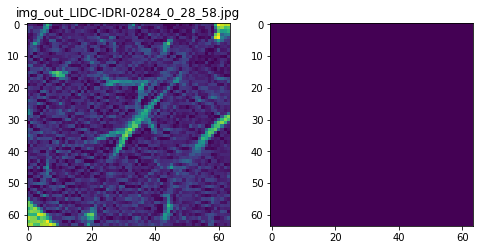

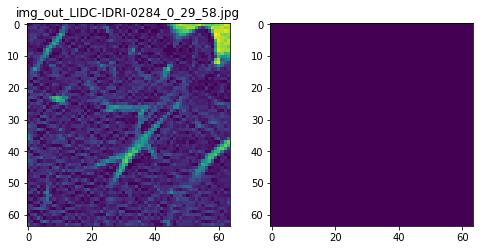

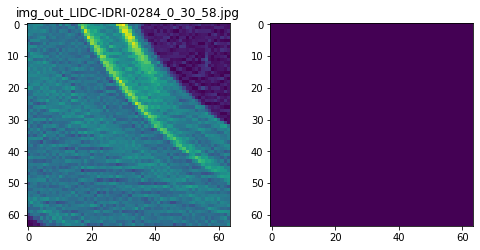

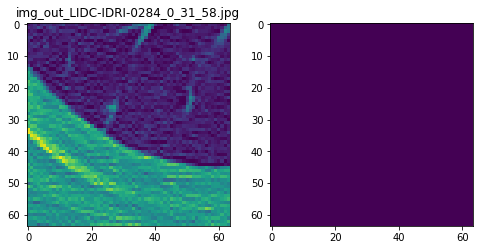

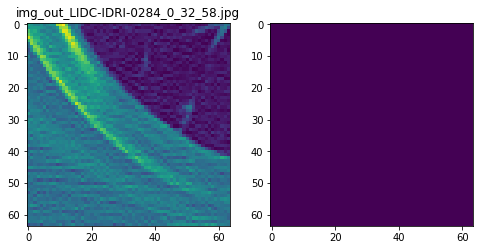

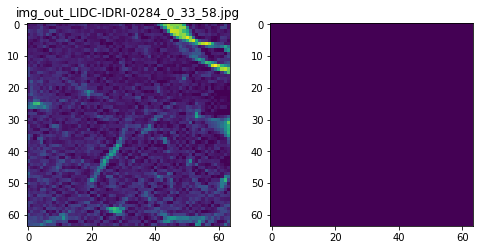

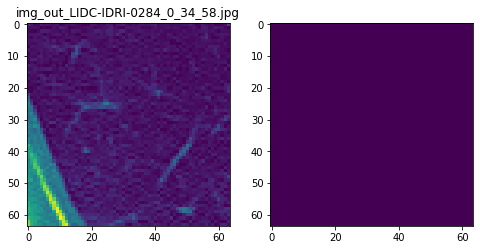

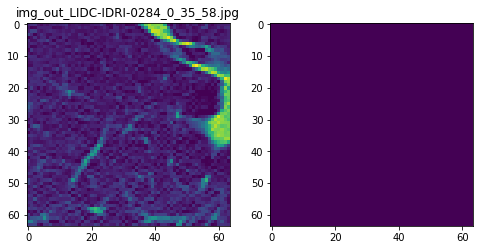

In [497]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0284')
print("There are {} nodules".format(len(cbbox)))
save_surrounding_images(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True)

In [294]:
# def validate_surrounding_images(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True):
#     devnull = open(os.devnull, 'w')
#     if image_save:
#         assert os.path.exists(root_dir)
#         image_dir = root_dir + '/images/'
#         mask_dir = root_dir + '/masks/'
#         assert os.path.exists(image_dir)
#         assert os.path.exists(mask_dir)
#     slcz = bounding_box[nodule_number][2]
#     unique_slice_ids = np.arange(slcz.start, slcz.stop)
#     voxel = CT_mask[:,:,bounding_box[nodule_number][2]]
#     img_voxel = vol[:,:,bounding_box[nodule_number][2]]
#     out_masks = []
#     out_images = []
#     out_slices = None
#     #print("voxel shape 2 = {}".format(voxel.shape[2]))
#     for slice_id in range(voxel.shape[2]):
#         boxes = get_bounding_box(voxel[:,:,slice_id])
#         if boxes is None:
#             print("No bounding box for {} and slice {}".format(patient_id, slice_id))
#             continue
#         slices = get_slices(boxes, False)
#         coords = get_all_box_centers(slices, 34)
#         out_slices = get_random_slices(coords, 3) # get 3 random 64x64 images randomly from the image that does not show the mask (i.e., negative samples)
#         out_slices = [out_slice + (bounding_box[nodule_number][2],) for out_slice in out_slices]
#         #out_slices = [(slice(y-32, y+32, None), slice(x-32, x+32, None), bounding_box[nodule_number][2]) for x,y in coords]
#         for out_slice in out_slices:
#             out_masks.append(voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
#             out_images.append(img_voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
# #             out_masks.append(CT_mask[out_slice])
# #             out_images.append(vol[out_slice])
    
#     errors = []
#     cnt = 0
#     #print("Unique slices = {}".format(len(unique_slice_ids)))
#     b=[]
#     for a1 in unique_slice_ids:
#         b.extend(np.repeat(a1, 3))
#     for idx, (slice1, mask )in enumerate(zip(b, out_masks)):
#         print("{}_{}_{}_{}".format(slice1,patient_id, nodule_number, idx))
#         if len(np.unique(mask)) > 1:
#             s = (np.sum(mask), idx, patient_id, nodule_number, unique_slice_id)
#             errors.append(s)
#         cnt += 1
#     return errors, cnt

In [498]:
"""
    Save the nodule image and at least one more random image with the nodule visible but not identical to the nodule image
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
"""
def save_image_foreach_slice(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    #get the clip such that the nodule is at the center of the 64x64 image
    slc = get_nodule_part(bounding_box[nodule_number], random, shape=(32, 32))

    assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
    for slice_index, unique_slice_id in zip(range(slc[2].stop - slc[2].start),unique_slice_ids):
        img = vol[slc[0],slc[1],slc[2]][:,:,slice_index]
        mask = CT_mask[slc[0],slc[1],slc[2]][:,:,slice_index]
        if img.shape != (64, 64):
            continue
        if mask.shape != (64, 64):
            continue
        if image_save:
            if random:
                image_file_name = "img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            else:
                image_file_name = "img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(image_dir + image_file_name, img)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(mask_dir + mask_file_name, mask)
        if image_plot:
            f, a =  plt.subplots(1,2, figsize=(8,10))
            a[0].imshow(img)
            if random:
                a[0].set_title("img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            else:
                a[0].set_title("img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            a[1].imshow(mask)
            plt.show()

In [293]:
# vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0284')
# print("There are {} nodules".format(len(cbbox)))
# save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
#                          vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=True)

In [292]:
# vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0001')
# print("There are {} nodules".format(len(cbbox)))
# save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0001', bounding_box=cbbox, nodule_number=0,  
#                          vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True)

#### Random crop images around nodules

In [291]:
"""
    Save the nodule image and at least one more random image with the nodule visible 
    but not identical to the nodule image
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    num_random_images = number of random crop images to generate around the nodule
"""
def save_random_crop_image_foreach_slice(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                                         image_save=False, image_plot=True, num_random_images=10):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    #slc = get_nodule_part(bounding_box[nodule_number], random)
    slc = get_nodule_part(bounding_box[nodule_number], random=False, shape=(64,64))
    
            
    assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
    for slice_index, unique_slice_id in zip(range(slc[2].stop - slc[2].start),unique_slice_ids):
        img = vol[slc[0],slc[1],slc[2]][:,:,slice_index]
        mask = CT_mask[slc[0],slc[1],slc[2]][:,:,slice_index]
        if img.shape != (128, 128):
            continue
        if mask.shape != (128, 128):
            continue
        #return an array of 10 (num_random_images) images
        X, Y = random_cropXY(img, mask, 32, num_random_images)
        
        if image_save:
            for rnd_img_id in range(len(X)):
                image_file_name = "img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                mask_file_name = "mask_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, X[rnd_img_id])
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(mask_dir + mask_file_name, Y[rnd_img_id])
        if image_plot:
            f, a =  plt.subplots(len(X),2, figsize=(len(X)*5,len(X)*5))
            for rnd_img_id in range(len(X)):
                a[rnd_img_id][0].imshow(X[rnd_img_id])
                a[rnd_img_id][0].set_title("img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id))
                a[rnd_img_id][1].imshow(Y[rnd_img_id])
            plt.show()

In [563]:
"""
    Get some random 64x64 images from the entire 512x512 image
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    num_random_images = number of random crop images to generate around the nodule
"""
def save_random_crop_image(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                                         image_save=False, image_plot=True, num_random_images=10):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    #slc = get_nodule_part(bounding_box[nodule_number], random)
    #slc = get_nodule_part(bounding_box[nodule_number], random=False, shape=(64,64))
    
            
    #assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
    for unique_slice_id in unique_slice_ids:
        img = vol[:,:,unique_slice_id]
        mask = CT_mask[:,:,unique_slice_id]
        if img.shape != (512, 512):
            continue
        if mask.shape != (512, 512):
            continue
        #return an array of 10 (num_random_images) images
        X, Y = random_cropXY(img, mask, 128+64+32, num_random_images)
        
        if image_save:
            for rnd_img_id in range(len(X)):
#                 if np.sum(Y[rnd_img_id]) > 0:
#                     continue
                image_file_name = "img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                mask_file_name = "mask_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, X[rnd_img_id])
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(mask_dir + mask_file_name, Y[rnd_img_id])
        if image_plot:
            f, a =  plt.subplots(len(X),2, figsize=(len(X)*5,len(X)*5))
            for rnd_img_id in range(len(X)):
#                 if np.sum(Y[rnd_img_id]) > 0:
#                     continue
                a[rnd_img_id][0].imshow(X[rnd_img_id])
                a[rnd_img_id][0].set_title("img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id))
                a[rnd_img_id][1].imshow(Y[rnd_img_id])
            plt.show()

Loading dicom files ... This may take a moment.


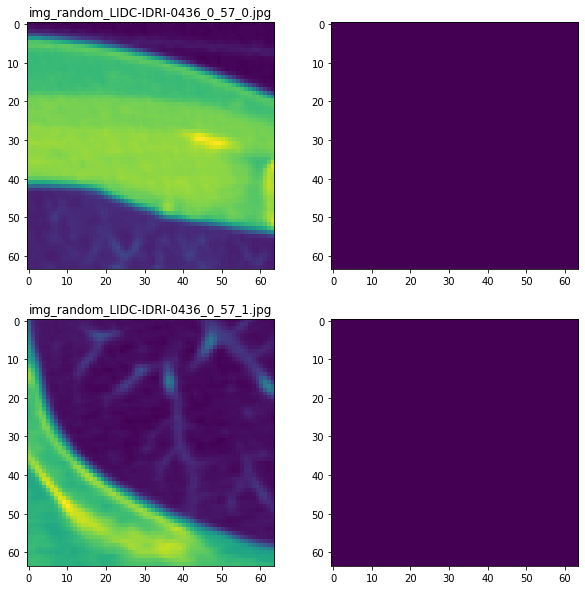

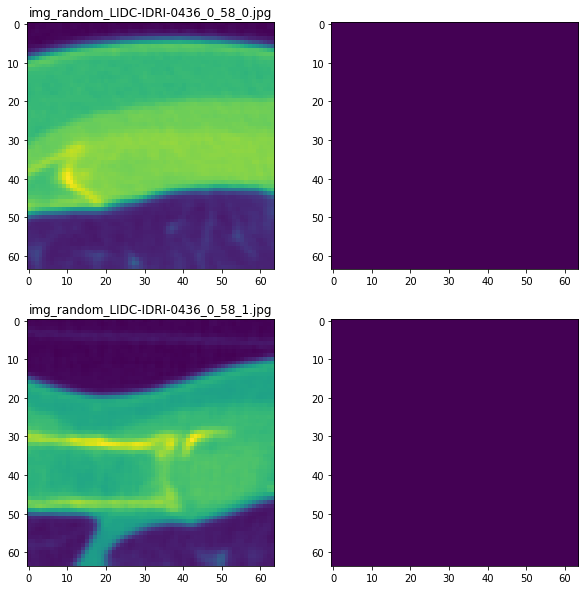

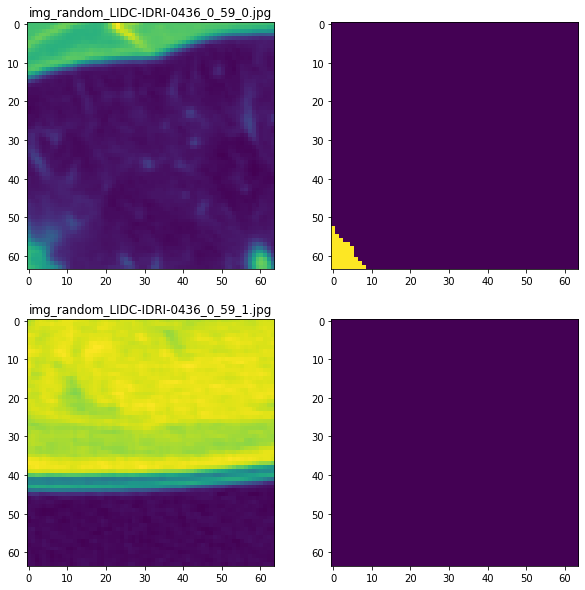

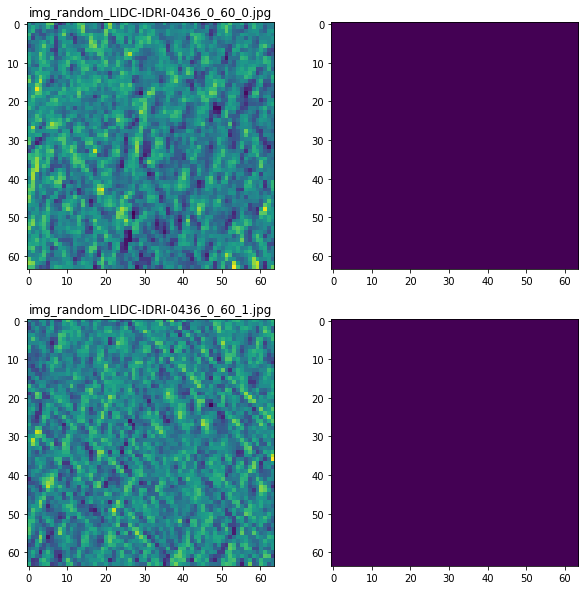

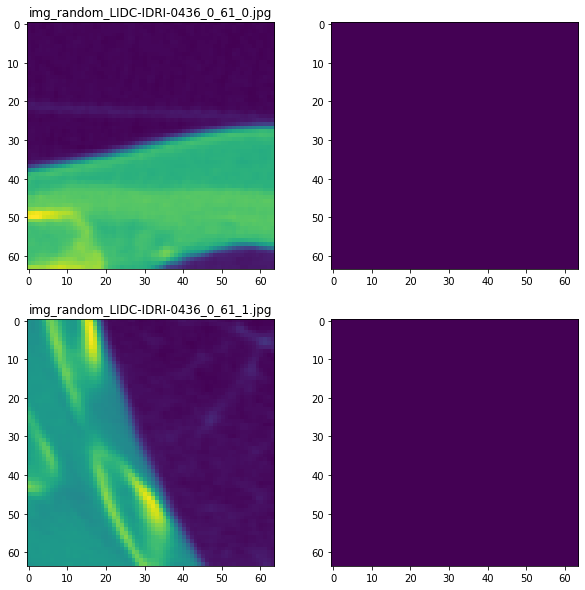

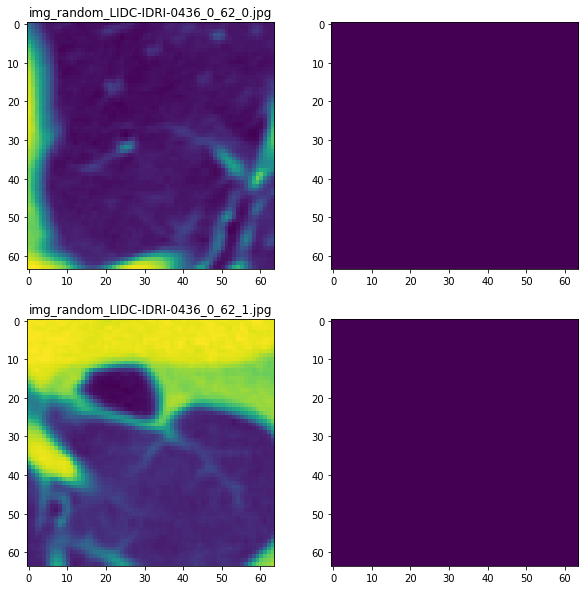

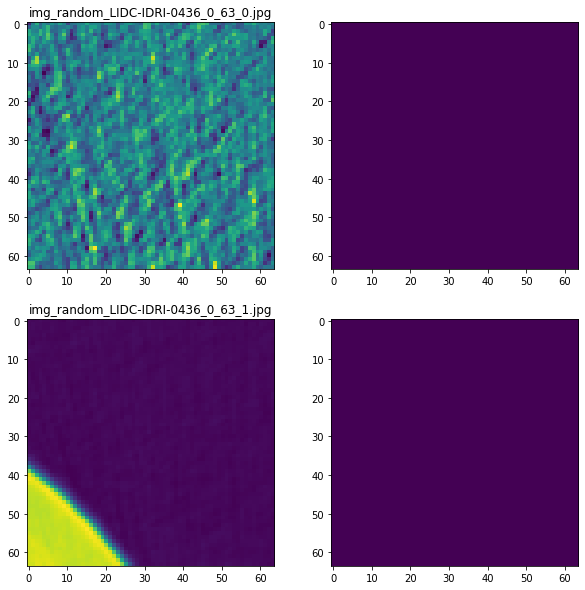

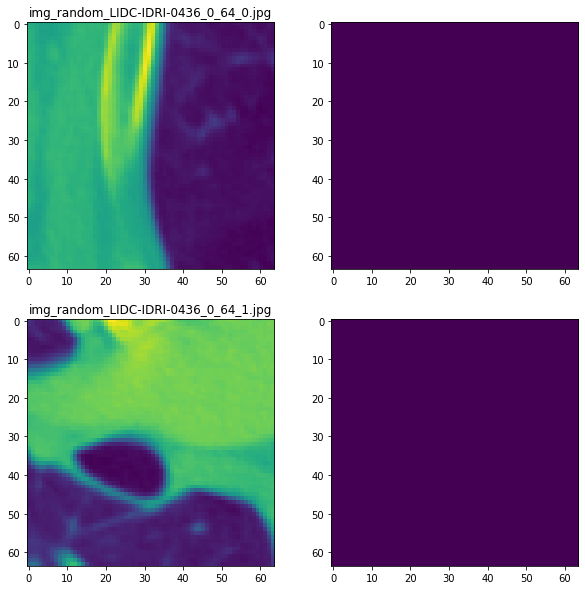

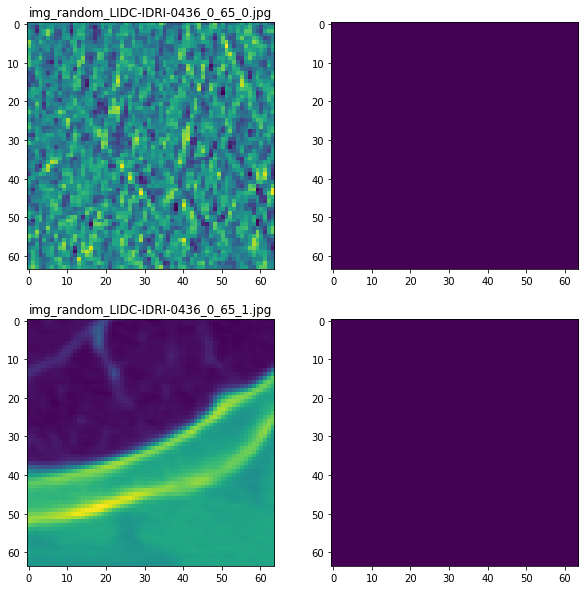

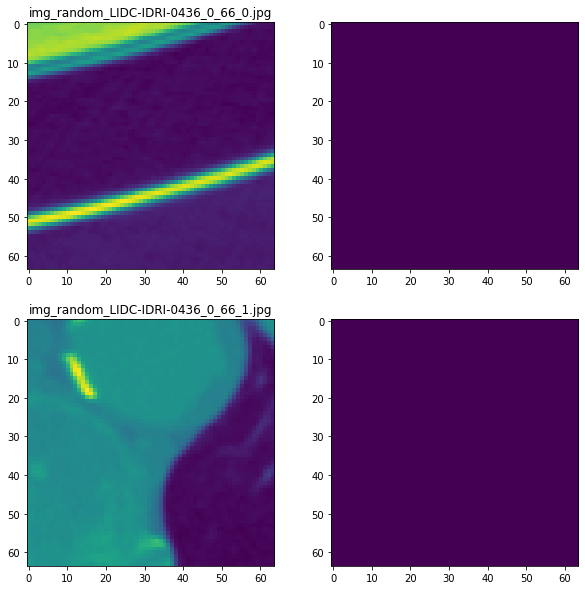

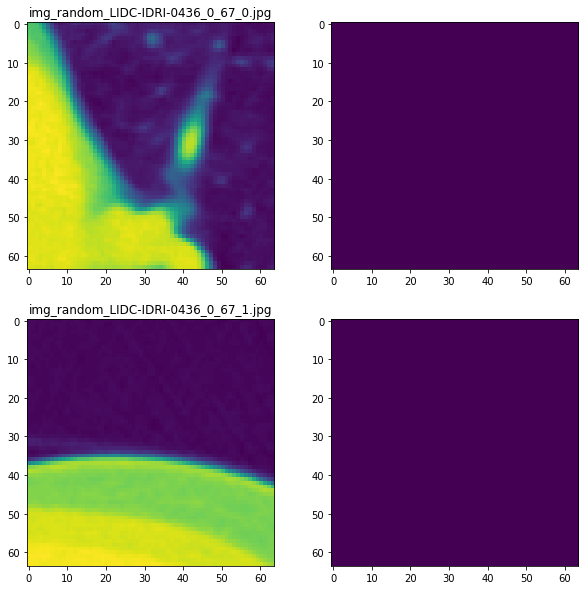

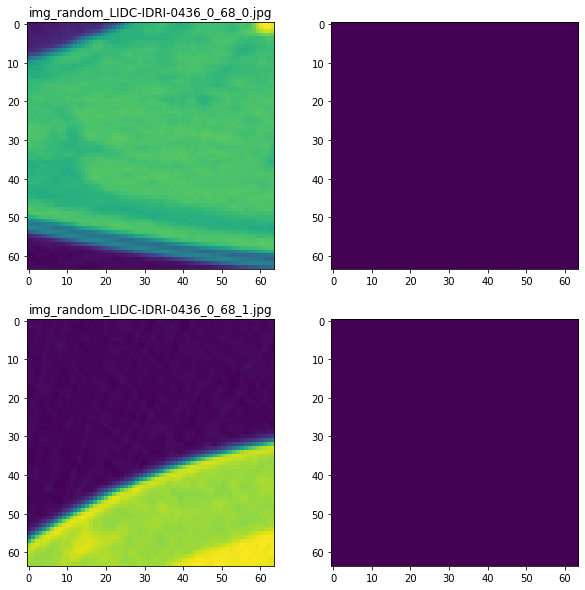

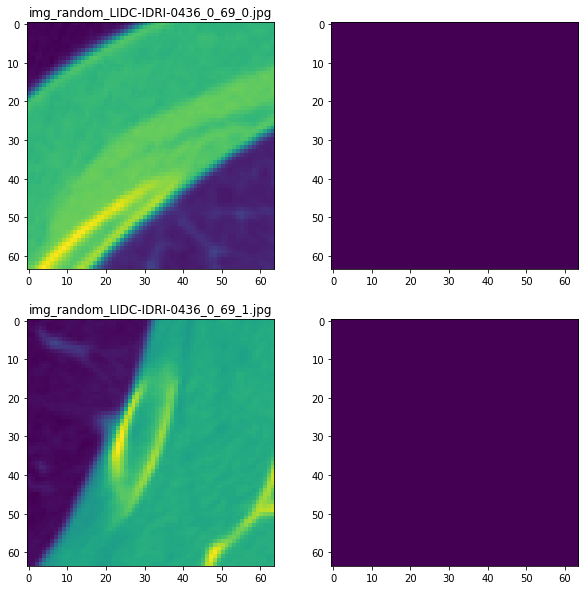

In [565]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir='/data/yolov5/test/sorted_gcsfiles', patient_id='LIDC-IDRI-0436')
save_random_crop_image(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, num_random_images=2)

Loading dicom files ... This may take a moment.
(64, 64)
(64, 64)


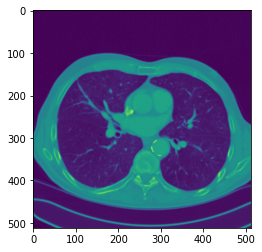

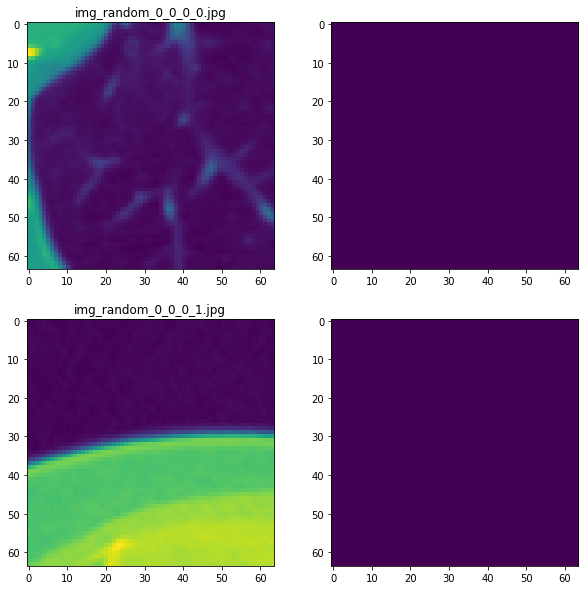

In [552]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir='/data/yolov5/test/sorted_gcsfiles', patient_id='LIDC-IDRI-0436')
plt.imshow(vol[:,:,cbbox[0][2]][:,:,0])
img = vol[:,:,cbbox[0][2]][:,:,0]
mask = CT_mask[:,:,cbbox[0][2]][:,:,0]

X, Y = random_cropXY(img, mask, 128+64+32, 2)

f, a =  plt.subplots(len(X),2, figsize=(len(X)*5,len(X)*5))
for rnd_img_id in range(len(X)):
    print(X[rnd_img_id].shape)
    a[rnd_img_id][0].imshow(X[rnd_img_id])
    a[rnd_img_id][0].set_title("img_random_{}_{}_{}_{}.jpg".format(0, 0, 0, rnd_img_id))
    a[rnd_img_id][1].imshow(Y[rnd_img_id])
plt.show()

#### Test the image generation code

Loading dicom files ... This may take a moment.


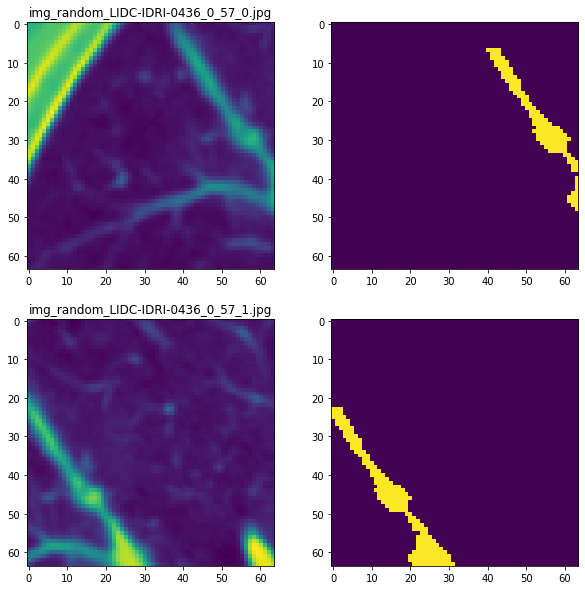

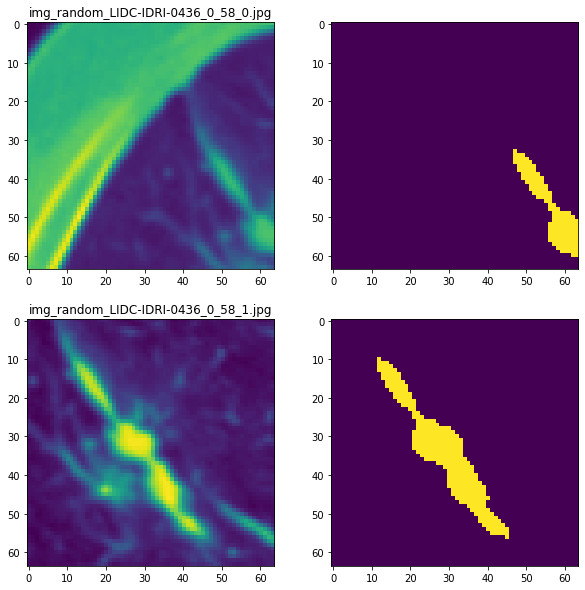

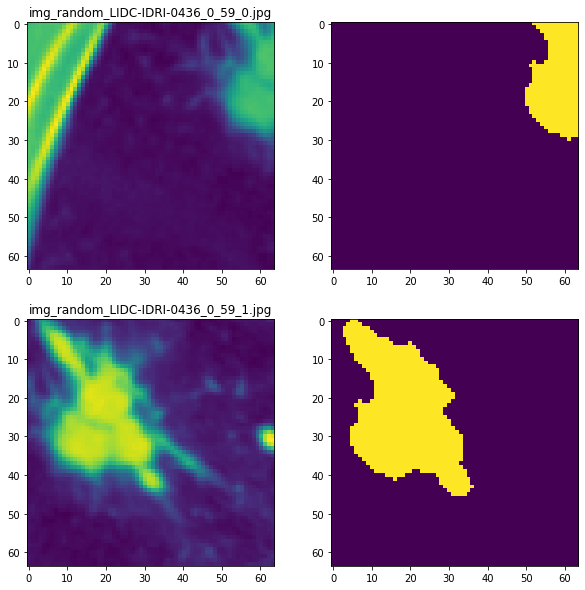

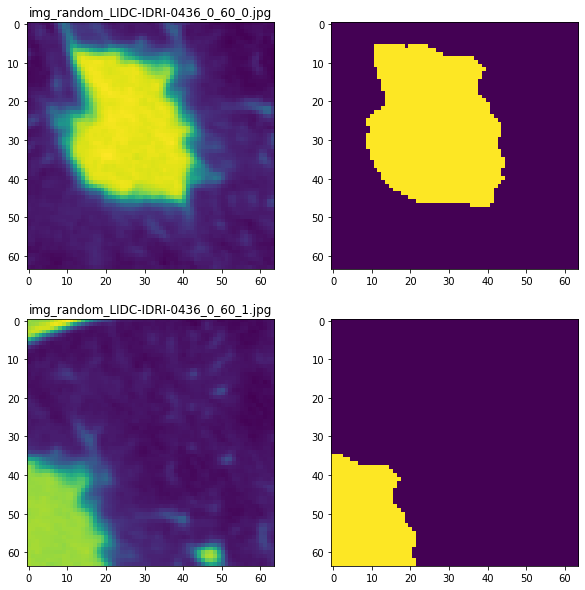

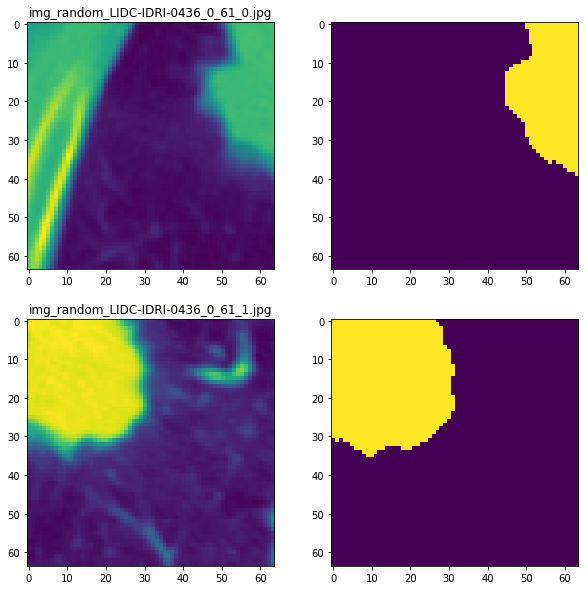

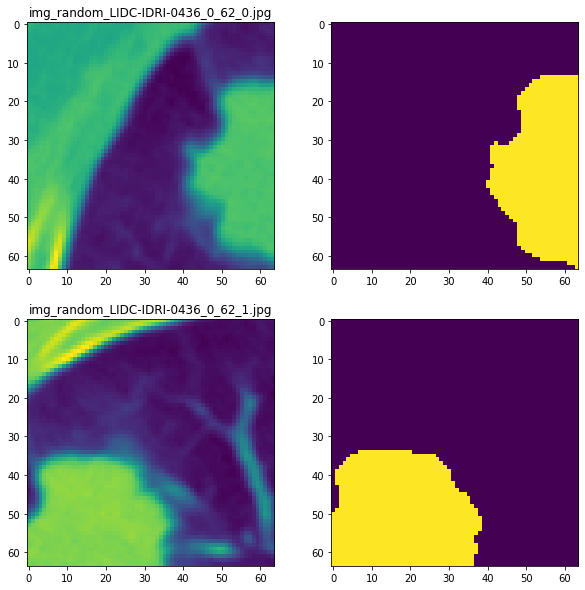

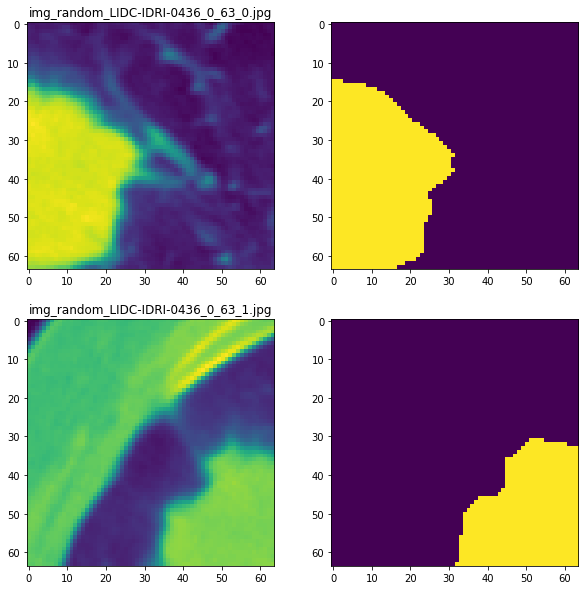

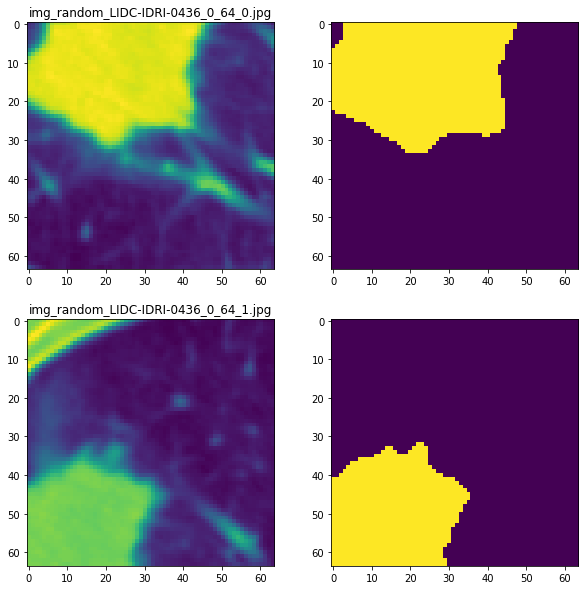

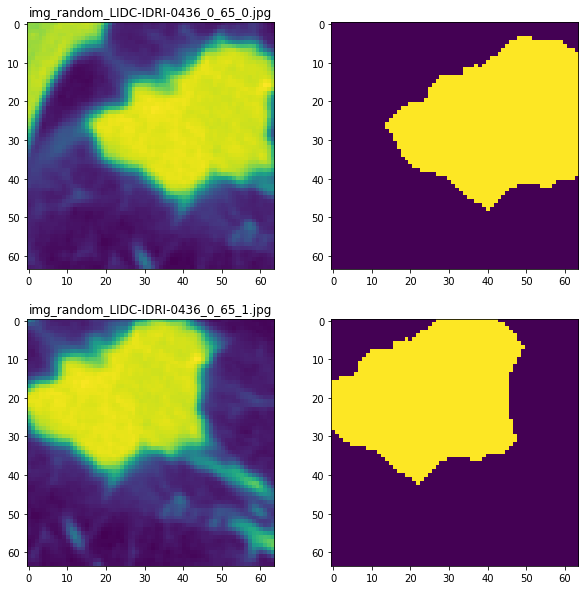

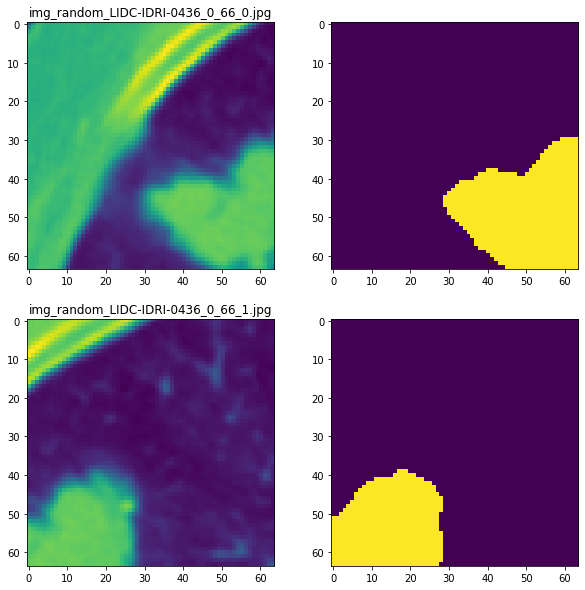

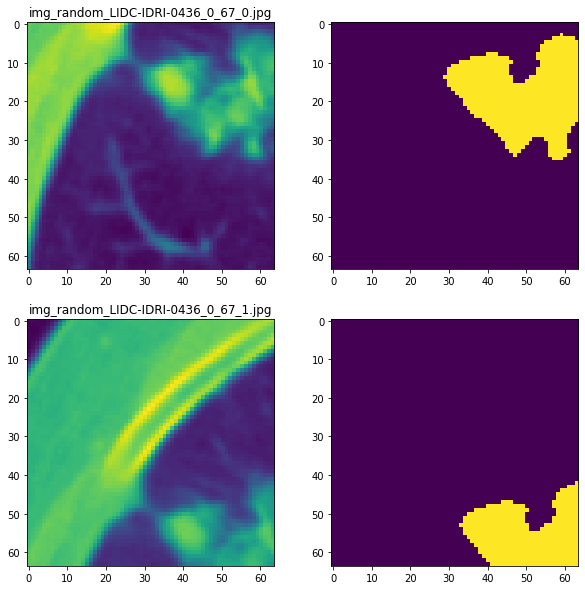

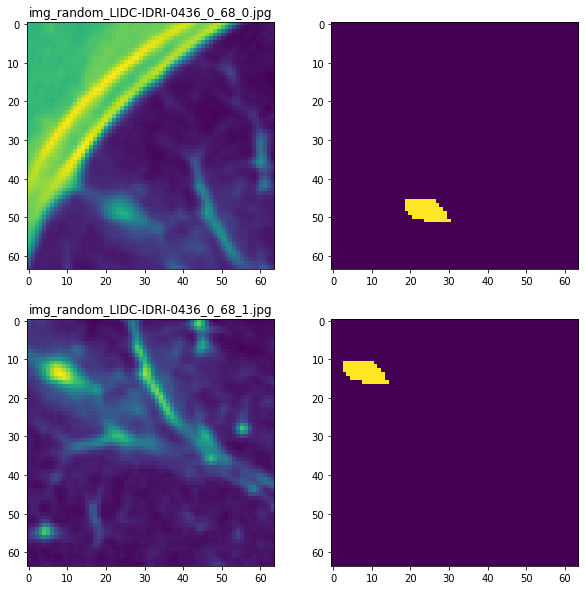

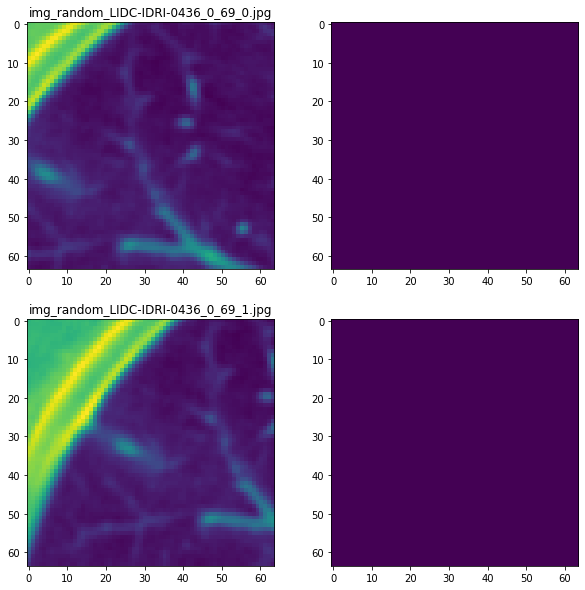

In [499]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir='/data/yolov5/test/sorted_gcsfiles', patient_id='LIDC-IDRI-0436')
save_random_crop_image_foreach_slice(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, num_random_images=2)

Loading dicom files ... This may take a moment.


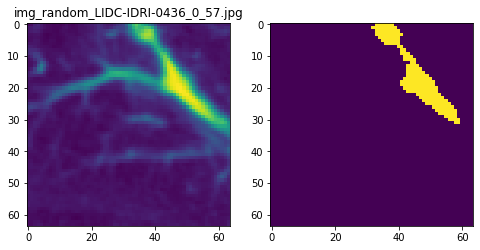

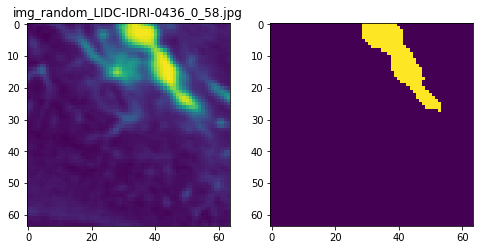

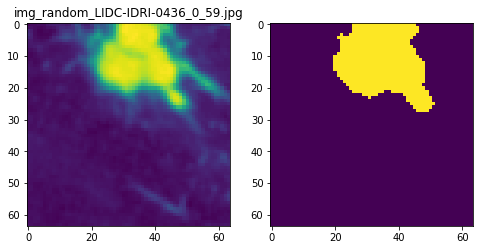

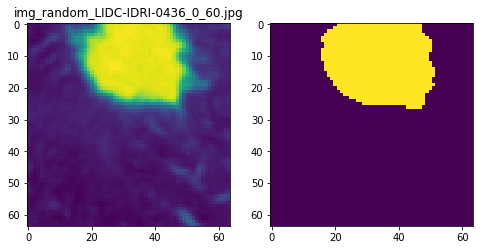

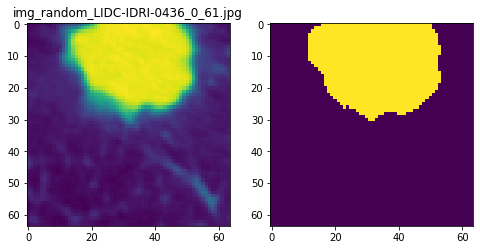

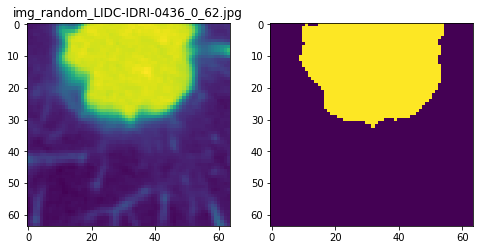

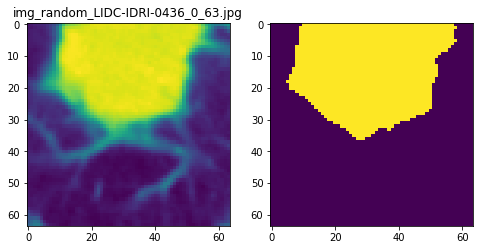

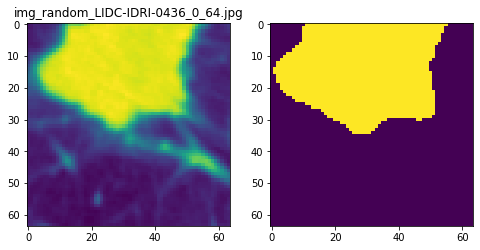

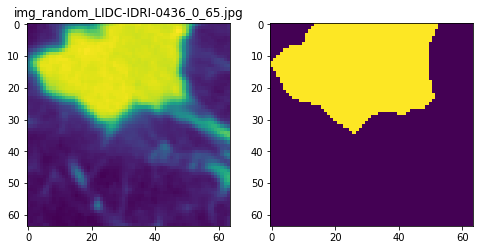

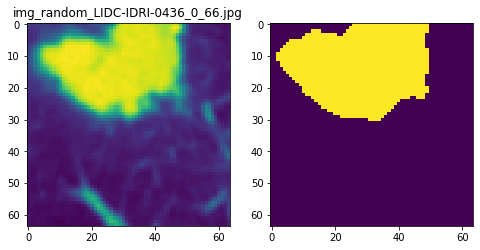

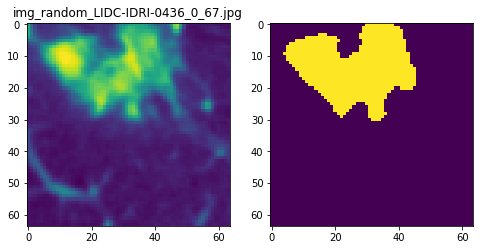

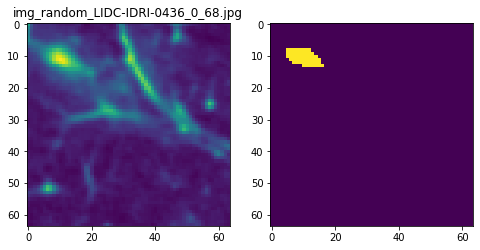

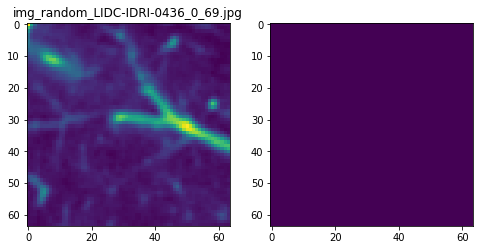

In [501]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')
save_image_foreach_slice(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True)

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0436 and slice 12
96


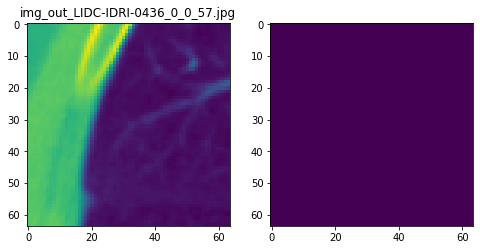

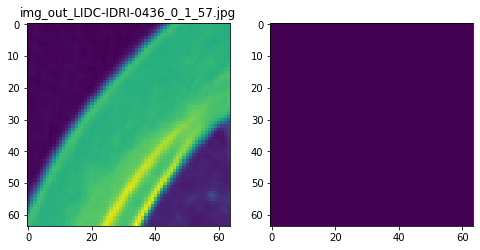

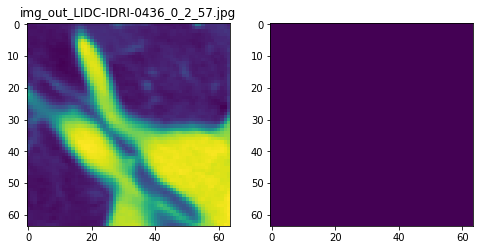

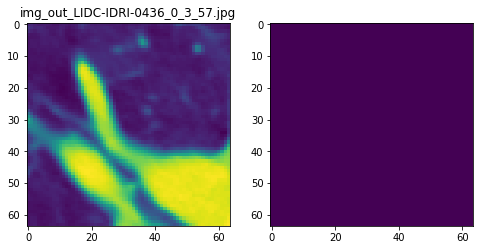

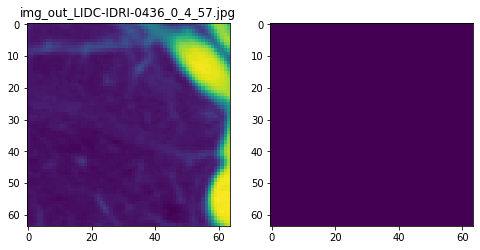

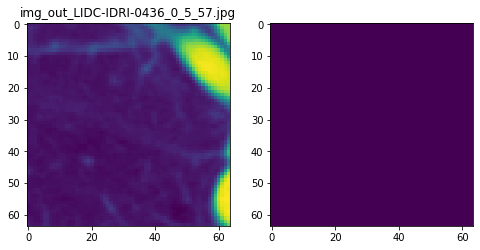

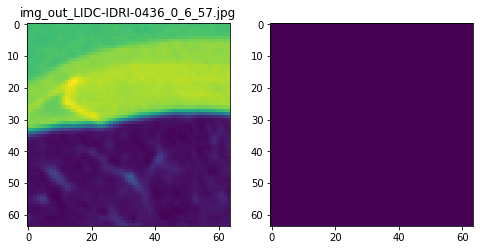

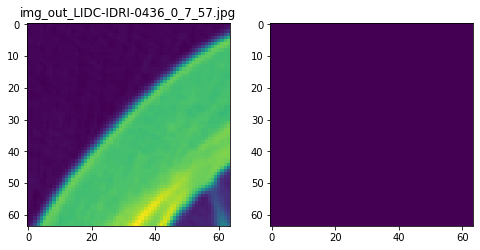

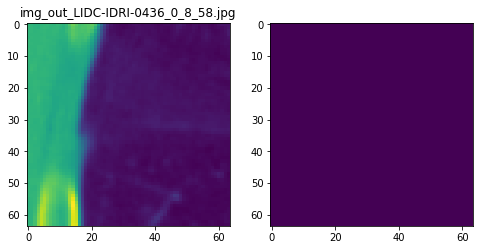

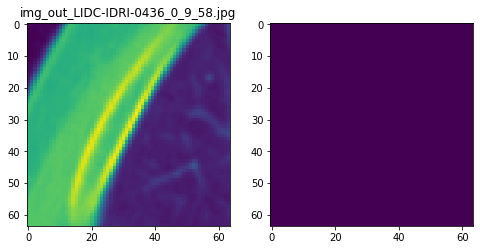

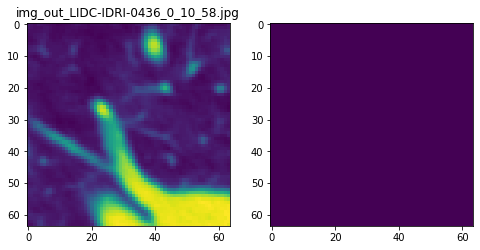

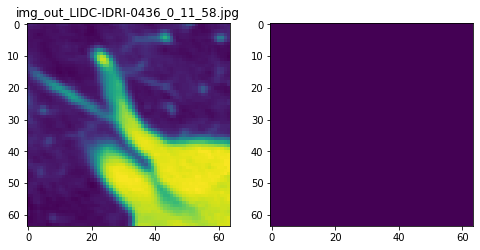

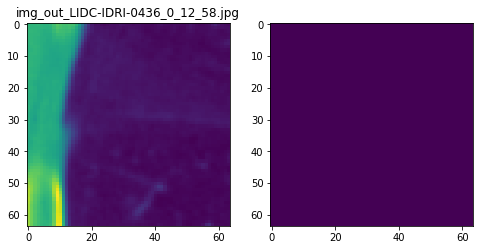

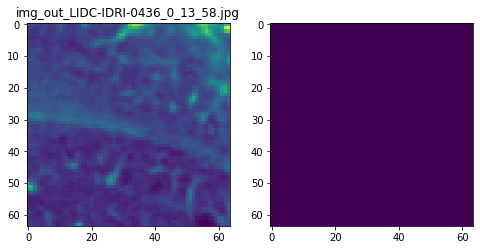

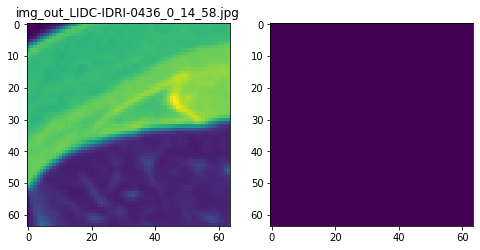

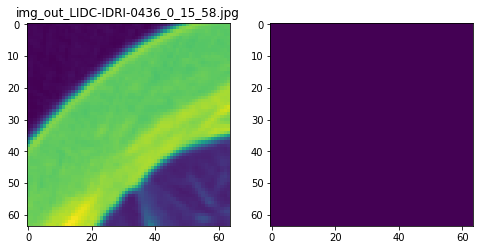

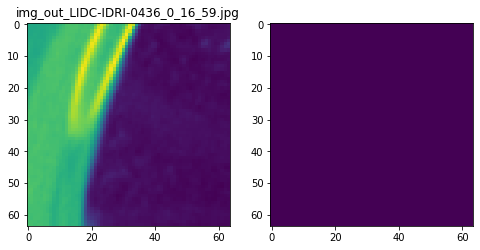

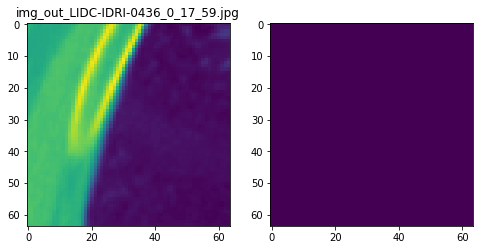

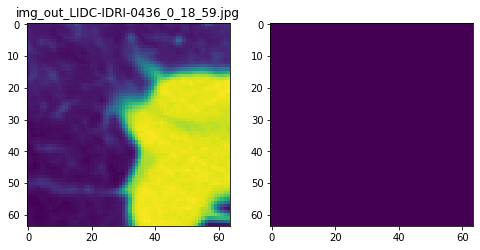

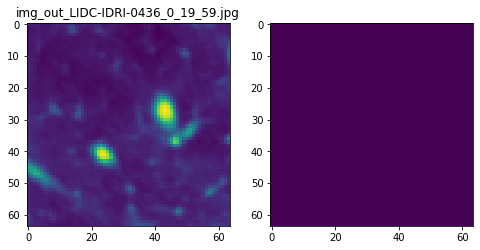

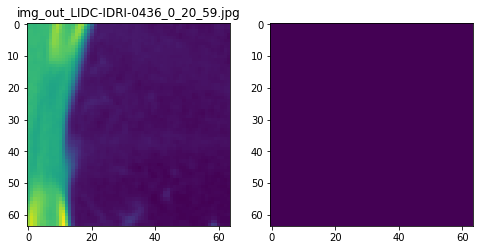

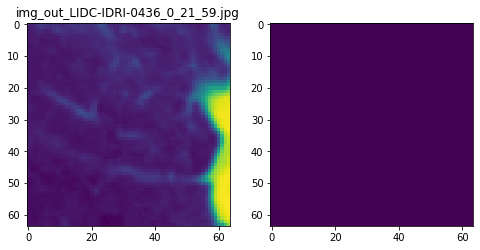

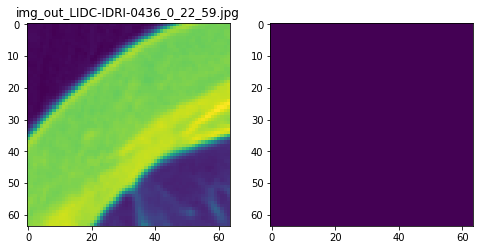

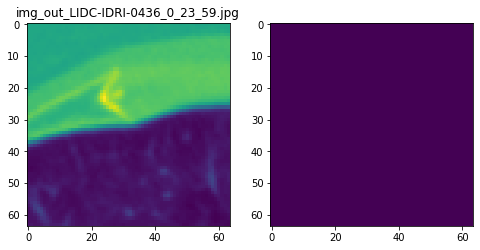

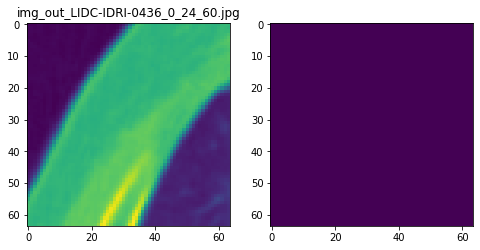

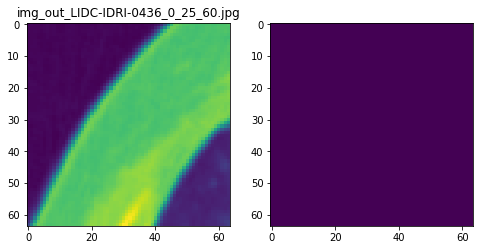

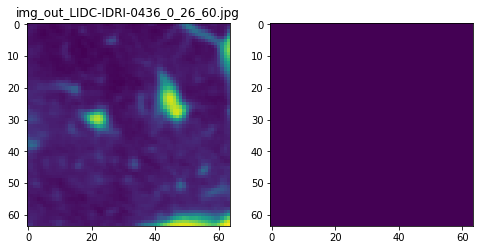

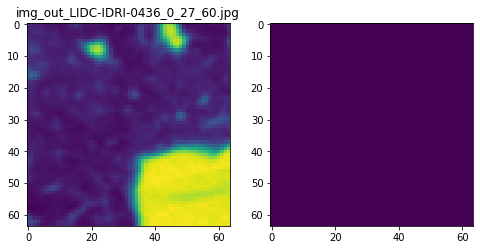

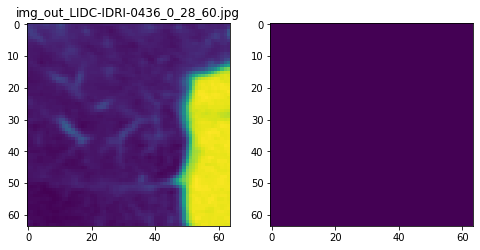

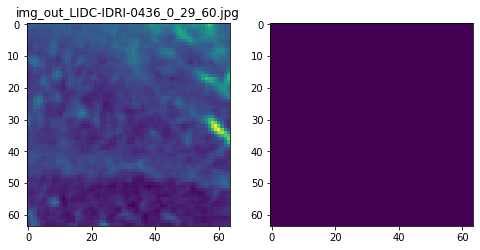

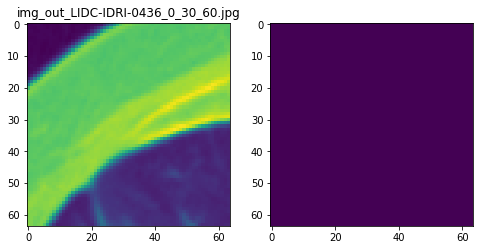

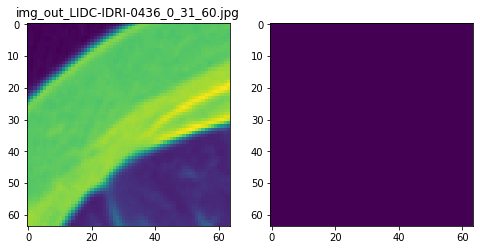

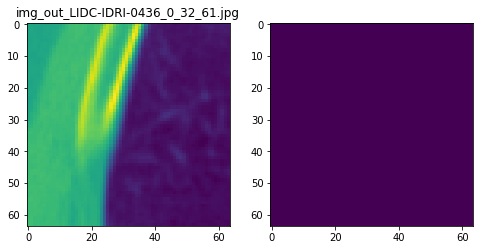

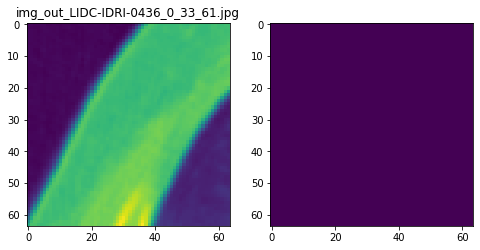

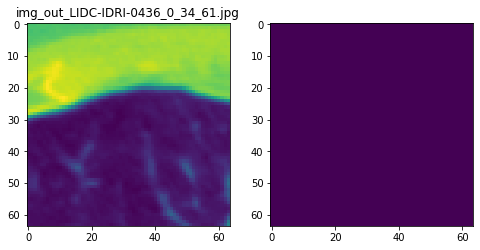

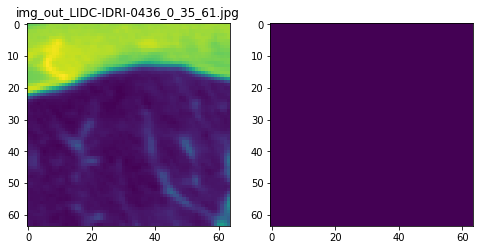

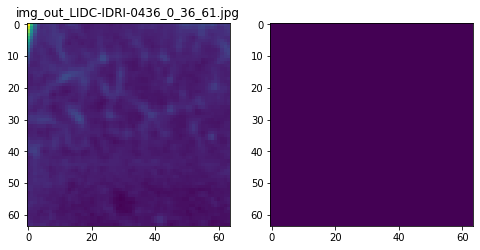

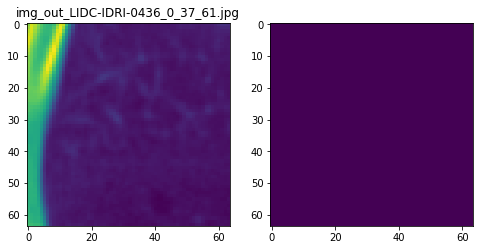

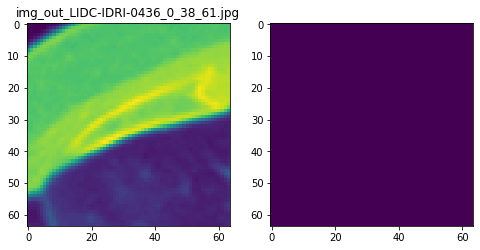

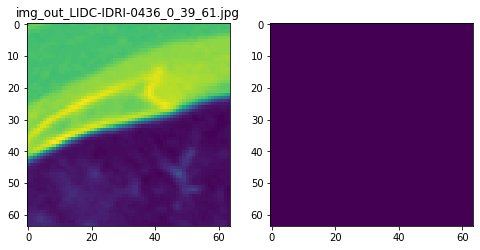

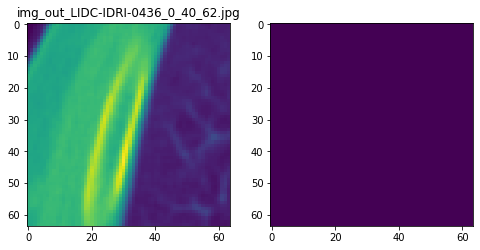

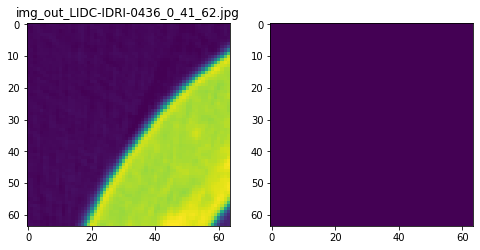

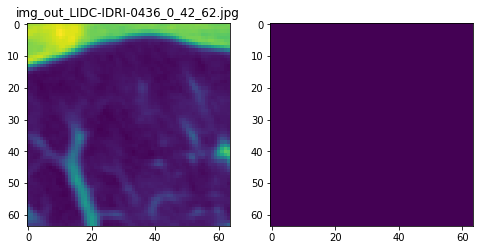

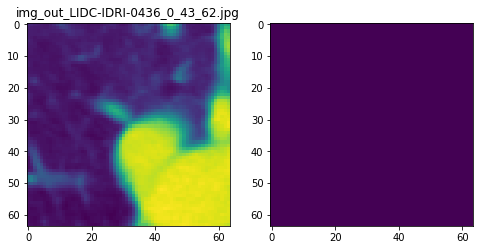

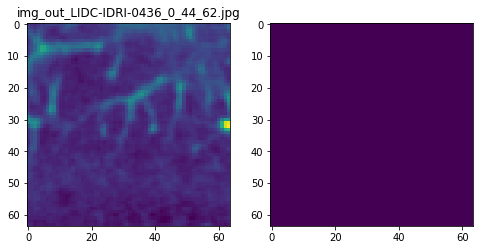

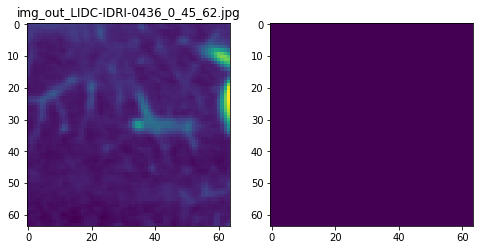

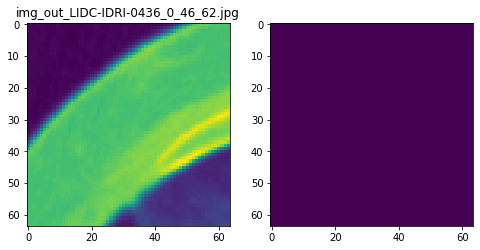

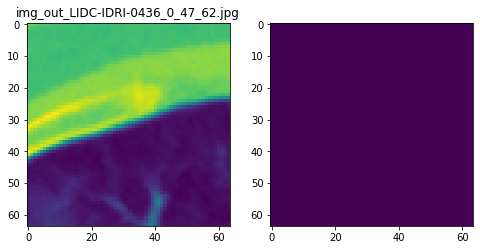

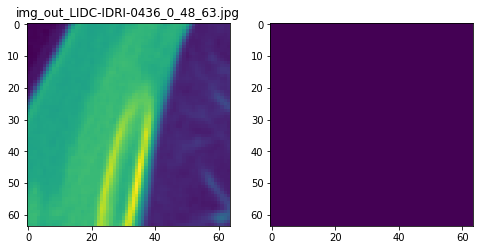

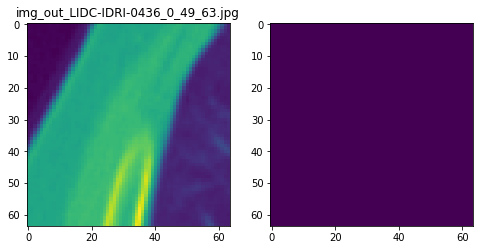

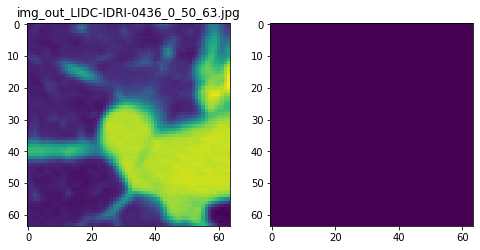

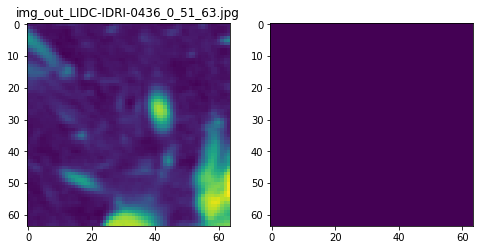

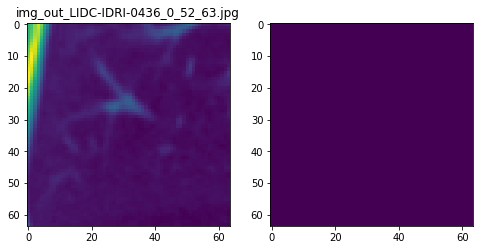

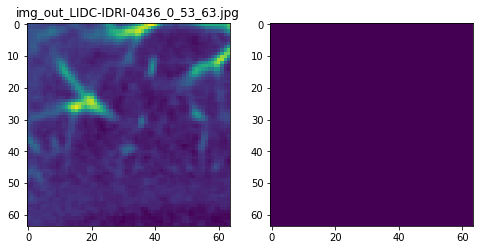

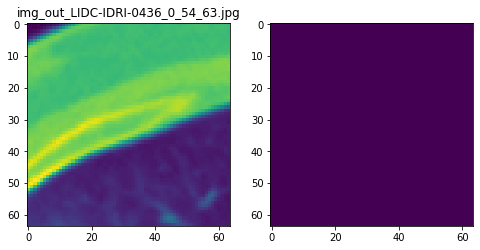

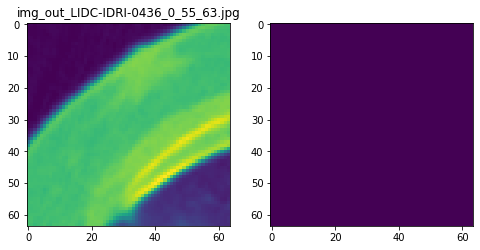

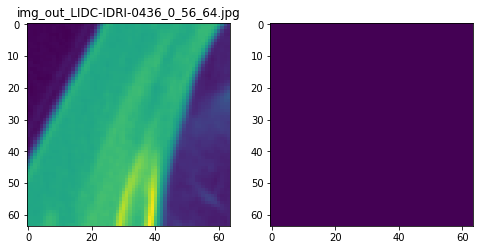

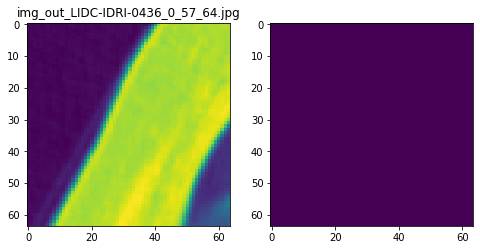

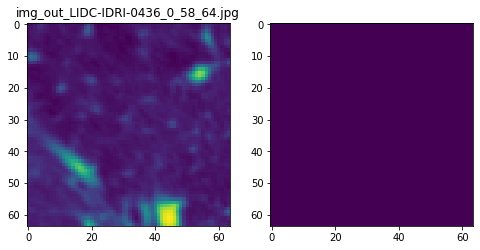

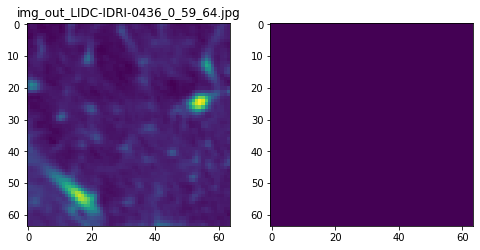

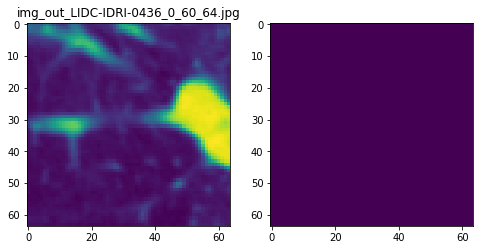

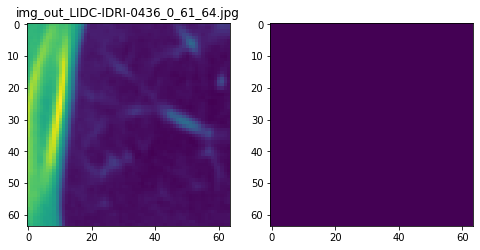

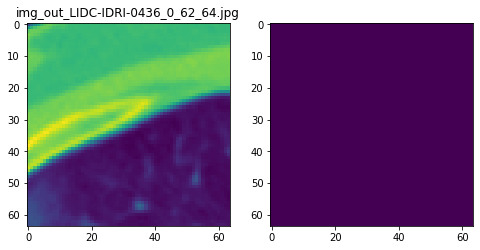

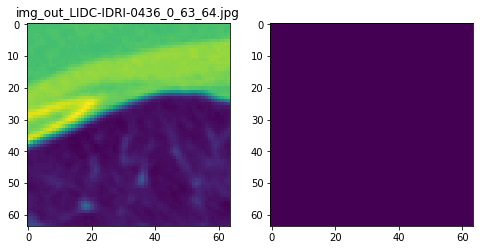

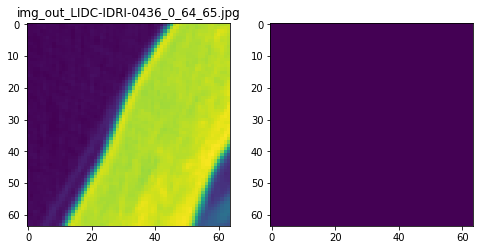

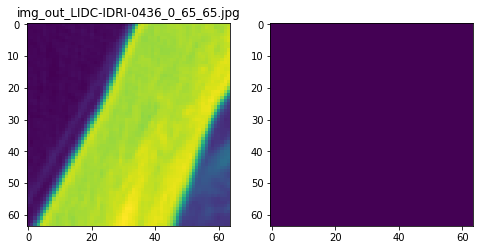

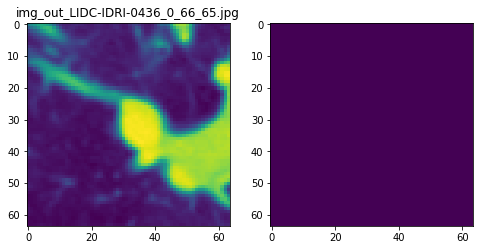

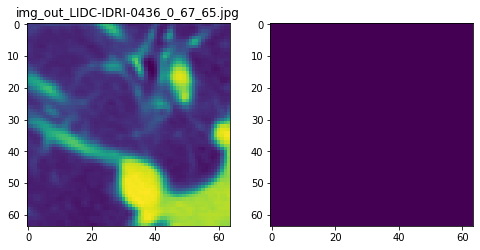

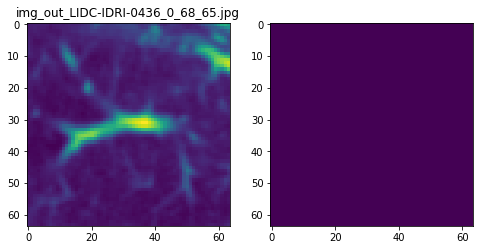

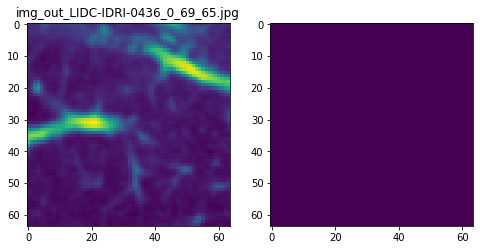

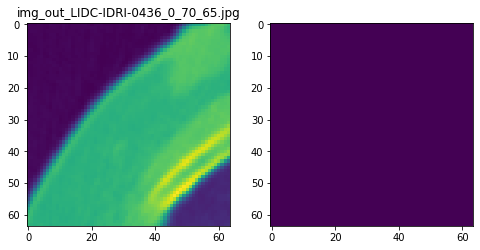

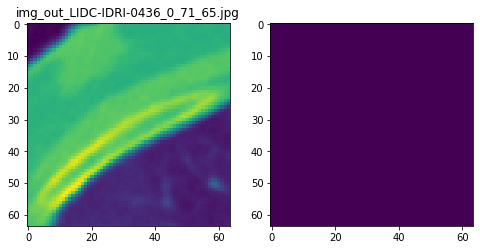

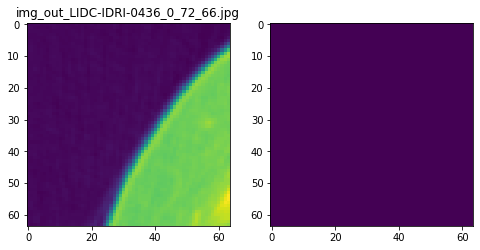

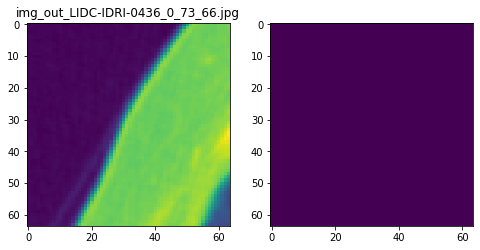

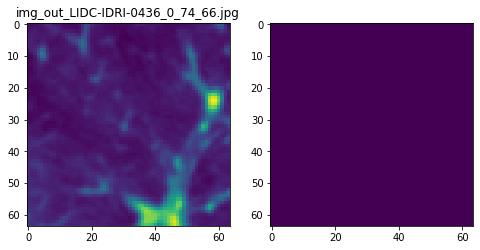

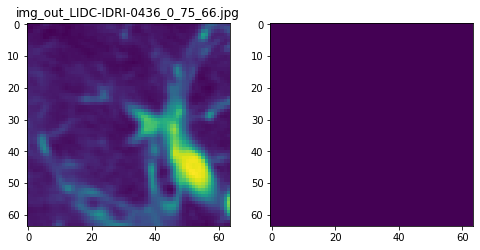

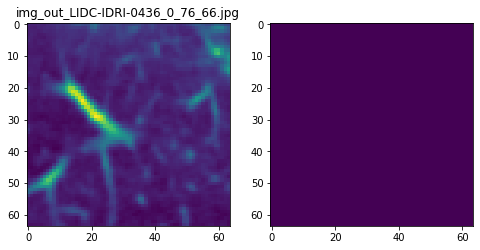

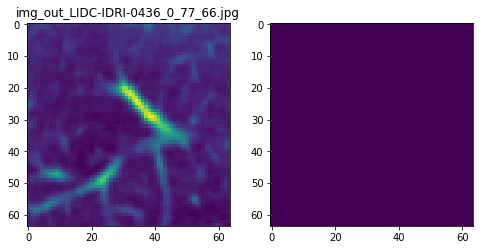

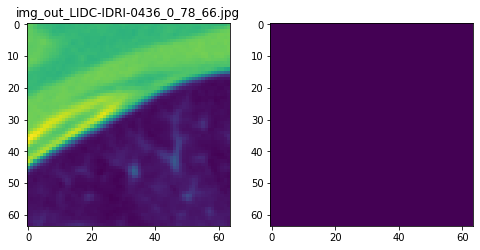

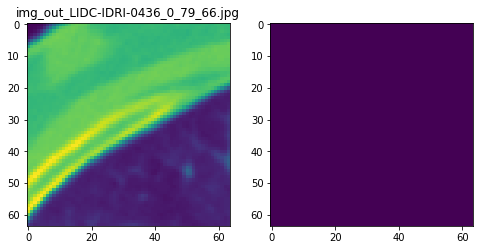

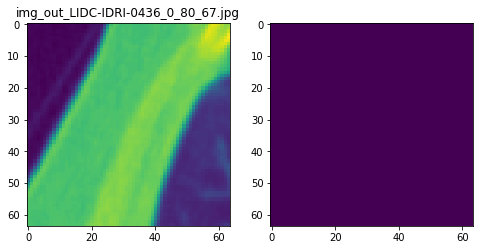

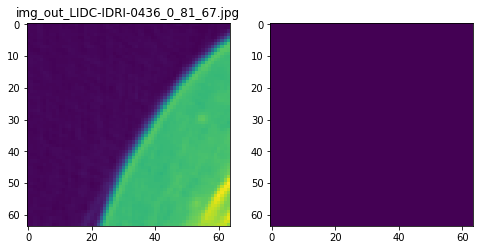

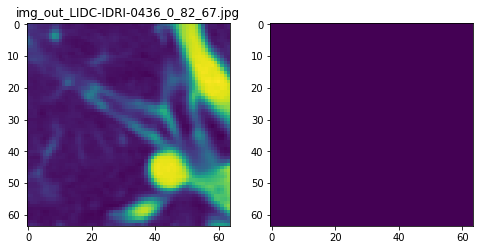

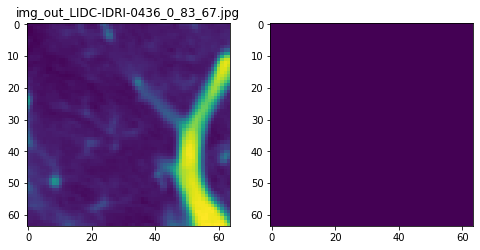

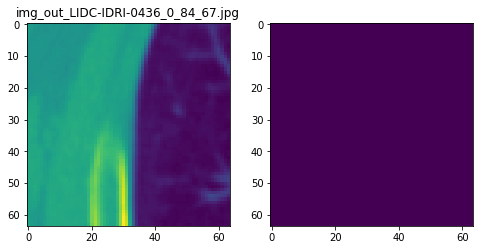

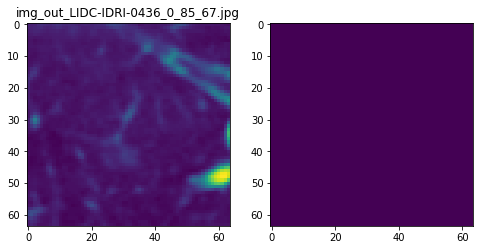

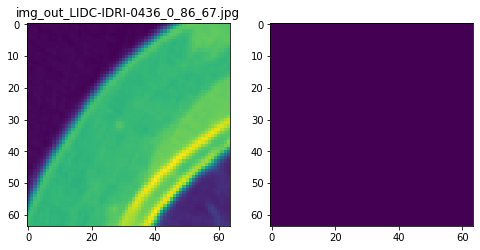

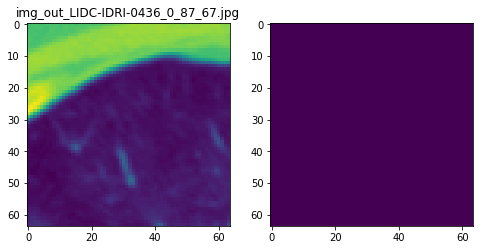

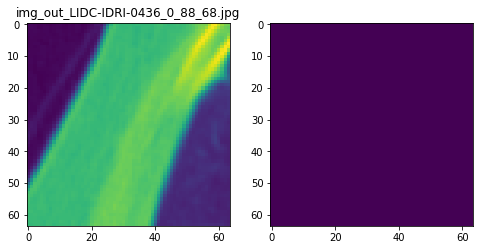

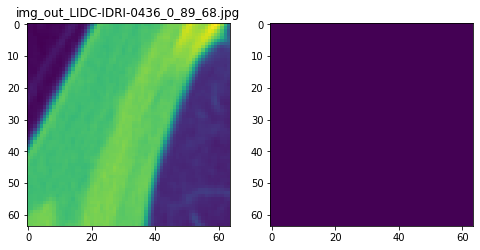

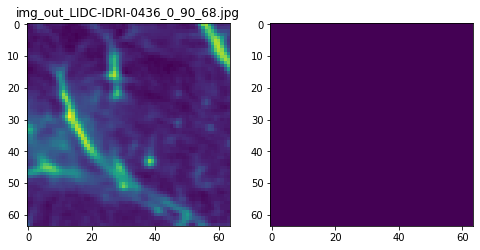

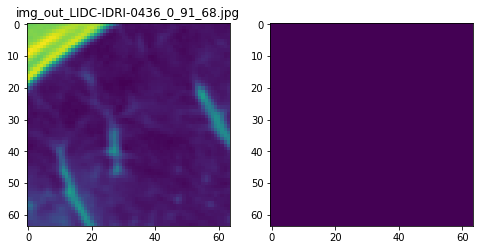

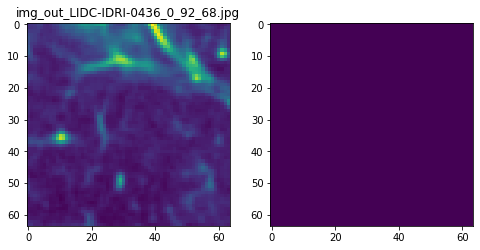

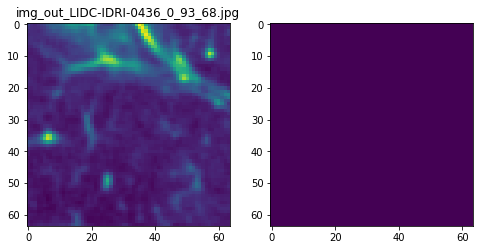

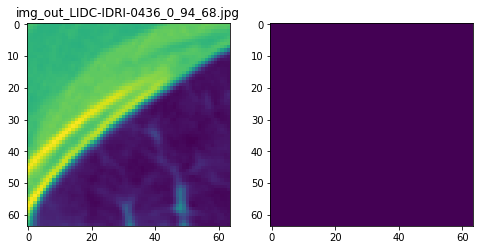

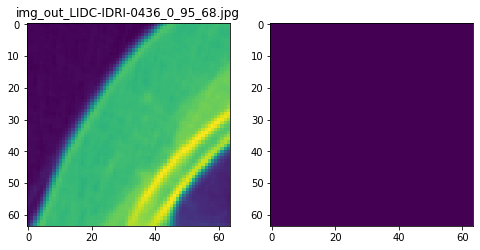

In [526]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')
save_surrounding_images(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, num_random_images=8)

#### Generate and save images for each patients  

In [300]:
def save_generated_images_for_patient(root_dir='/data/unet/train/', dicom_dir='/rawdata/train/sorted_gcsfiles', patient_id='LIDC-IDRI-0284'):
    vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir, patient_id)
    if cbbox:
        for nodule_num in range(len(cbbox)):
            #this gives 2 images per slice, generate num_random_images positive images
            save_random_crop_image_foreach_slice(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, num_random_images=12)
            #this gives one image per slice
            save_image_foreach_slice(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=False, image_save=True, image_plot=False)
            #this gives 2 image per slice along each side of the nodule bounding box, use num_images in multiples of 4 since there are 4 sides
            #generate num_random_images negative images
            save_surrounding_images(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=False, num_random_images=12)

In [530]:
import os
root_path = '/data/unet/train/'
"""
    UNET data dir should have only images and masks folder and should be empty
"""
def check_dirs(root_path):
    dirs = os.listdir(root_path)
    s = np.setdiff1d(np.array(['images', 'masks']), np.array(dirs))
    assert len(s) == 0, "Directory structure not correct!"
    for d in dirs:
        tmp = root_path + "/" + d
        if os.path.exists(tmp):
            files = os.listdir(tmp)
            assert len(files) <= 0, "Directory not empty!"

In [533]:
%%time
patients = os.listdir('/rawdata/train/sorted_gcsfiles')
root_dir = '/data/unet/train/'
check_dirs(root_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=root_dir, dicom_dir='/rawdata/train/sorted_gcsfiles', patient_id=pat)

  0%|                                                                                                                                  | 0/696 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.


  0%|▏                                                                                                                         | 1/696 [00:03<44:04,  3.81s/it]

No relevant nodules for patient LIDC-IDRI-0971
Loading dicom files ... This may take a moment.


  0%|▎                                                                                                                       | 2/696 [00:17<1:54:20,  9.89s/it]

No relevant nodules for patient LIDC-IDRI-0856
Loading dicom files ... This may take a moment.


  0%|▌                                                                                                                       | 3/696 [00:23<1:31:25,  7.92s/it]

No relevant nodules for patient LIDC-IDRI-0826
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0375 and slice 0
96
No bounding box for LIDC-IDRI-0375 and slice 15
180


  1%|▋                                                                                                                       | 4/696 [00:29<1:24:36,  7.34s/it]

Loading dicom files ... This may take a moment.
48


  1%|▊                                                                                                                       | 5/696 [00:32<1:06:02,  5.73s/it]

Loading dicom files ... This may take a moment.


  1%|█                                                                                                                         | 6/696 [00:34<50:38,  4.40s/it]

No relevant nodules for patient LIDC-IDRI-0584
Loading dicom files ... This may take a moment.
48
No bounding box for LIDC-IDRI-0315 and slice 0
36
48


  1%|█▏                                                                                                                        | 7/696 [00:37<46:28,  4.05s/it]

Loading dicom files ... This may take a moment.


  1%|█▍                                                                                                                        | 8/696 [00:40<41:56,  3.66s/it]

No relevant nodules for patient LIDC-IDRI-0859
Loading dicom files ... This may take a moment.
36


  1%|█▌                                                                                                                        | 9/696 [00:42<35:05,  3.06s/it]

Loading dicom files ... This may take a moment.
96


  1%|█▋                                                                                                                       | 10/696 [00:46<38:17,  3.35s/it]

Loading dicom files ... This may take a moment.


  2%|█▉                                                                                                                       | 11/696 [00:48<34:40,  3.04s/it]

No relevant nodules for patient LIDC-IDRI-0654
Loading dicom files ... This may take a moment.
48


  2%|██                                                                                                                       | 12/696 [00:50<30:32,  2.68s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0347 and slice 0
48
36
No bounding box for LIDC-IDRI-0347 and slice 0
No bounding box for LIDC-IDRI-0347 and slice 5
No bounding box for LIDC-IDRI-0347 and slice 6
48


  2%|██▎                                                                                                                      | 13/696 [00:53<31:47,  2.79s/it]

Loading dicom files ... This may take a moment.


  2%|██▍                                                                                                                      | 14/696 [00:57<33:39,  2.96s/it]

No relevant nodules for patient LIDC-IDRI-0662
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0620 and slice 0
60


  2%|██▌                                                                                                                      | 15/696 [01:00<36:09,  3.19s/it]

Loading dicom files ... This may take a moment.
36


  2%|██▊                                                                                                                      | 16/696 [01:02<30:47,  2.72s/it]

Loading dicom files ... This may take a moment.


  2%|██▉                                                                                                                      | 17/696 [01:04<27:08,  2.40s/it]

No relevant nodules for patient LIDC-IDRI-0670
Loading dicom files ... This may take a moment.


  3%|███▏                                                                                                                     | 18/696 [01:05<25:05,  2.22s/it]

No relevant nodules for patient LIDC-IDRI-0157
Loading dicom files ... This may take a moment.
48
36
36
48


  3%|███▎                                                                                                                     | 19/696 [01:10<33:12,  2.94s/it]

Loading dicom files ... This may take a moment.


  3%|███▍                                                                                                                     | 20/696 [01:14<38:05,  3.38s/it]

No relevant nodules for patient LIDC-IDRI-0019
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0310 and slice 0
48


  3%|███▋                                                                                                                     | 21/696 [01:17<34:20,  3.05s/it]

Loading dicom files ... This may take a moment.
60
48
No bounding box for LIDC-IDRI-0686 and slice 7
84
No bounding box for LIDC-IDRI-0686 and slice 0
60
84
72


  3%|███▊                                                                                                                   | 22/696 [01:30<1:08:21,  6.08s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0276 and slice 0
No bounding box for LIDC-IDRI-0276 and slice 4
36


  3%|███▉                                                                                                                     | 23/696 [01:32<55:14,  4.93s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0604 and slice 7
84
No bounding box for LIDC-IDRI-0604 and slice 5
60
72


  3%|████                                                                                                                   | 24/696 [01:41<1:09:20,  6.19s/it]

Loading dicom files ... This may take a moment.


  4%|████▎                                                                                                                  | 25/696 [01:46<1:03:50,  5.71s/it]

No relevant nodules for patient LIDC-IDRI-0575
Loading dicom files ... This may take a moment.


  4%|████▌                                                                                                                    | 26/696 [01:48<51:07,  4.58s/it]

No relevant nodules for patient LIDC-IDRI-0680
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0919 and slice 16
192


  4%|████▋                                                                                                                    | 27/696 [01:52<50:36,  4.54s/it]

Loading dicom files ... This may take a moment.
156
96


  4%|████▊                                                                                                                    | 28/696 [01:58<53:08,  4.77s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0204 and slice 0
No bounding box for LIDC-IDRI-0204 and slice 1
No bounding box for LIDC-IDRI-0204 and slice 13
132


  4%|█████                                                                                                                    | 29/696 [02:01<48:27,  4.36s/it]

Loading dicom files ... This may take a moment.


  4%|█████▏                                                                                                                   | 30/696 [02:04<42:55,  3.87s/it]

No relevant nodules for patient LIDC-IDRI-0457
Loading dicom files ... This may take a moment.
24


  4%|█████▍                                                                                                                   | 31/696 [02:06<36:14,  3.27s/it]

Loading dicom files ... This may take a moment.


  5%|█████▌                                                                                                                   | 32/696 [02:12<46:06,  4.17s/it]

No relevant nodules for patient LIDC-IDRI-0839
Loading dicom files ... This may take a moment.


  5%|█████▋                                                                                                                   | 33/696 [02:15<42:45,  3.87s/it]

No relevant nodules for patient LIDC-IDRI-0979
Loading dicom files ... This may take a moment.
60
72
No bounding box for LIDC-IDRI-0068 and slice 0
72
108
No bounding box for LIDC-IDRI-0068 and slice 9
108


  5%|█████▉                                                                                                                   | 34/696 [02:23<57:30,  5.21s/it]

Loading dicom files ... This may take a moment.
24
48


  5%|██████                                                                                                                   | 35/696 [02:26<47:30,  4.31s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0184 and slice 3
36


  5%|██████▎                                                                                                                  | 36/696 [02:28<41:34,  3.78s/it]

Loading dicom files ... This may take a moment.


  5%|██████▍                                                                                                                  | 37/696 [02:31<39:04,  3.56s/it]

No relevant nodules for patient LIDC-IDRI-0180
Loading dicom files ... This may take a moment.


  5%|██████▌                                                                                                                  | 38/696 [02:40<58:00,  5.29s/it]

No relevant nodules for patient LIDC-IDRI-0397
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0624 and slice 0
No bounding box for LIDC-IDRI-0624 and slice 1
No bounding box for LIDC-IDRI-0624 and slice 2
No bounding box for LIDC-IDRI-0624 and slice 20
204


  6%|██████▋                                                                                                                | 39/696 [02:47<1:02:46,  5.73s/it]

Loading dicom files ... This may take a moment.
288


  6%|██████▊                                                                                                                | 40/696 [02:55<1:10:35,  6.46s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0568 and slice 0
60
48
No bounding box for LIDC-IDRI-0568 and slice 4
48


  6%|███████                                                                                                                | 41/696 [03:02<1:09:38,  6.38s/it]

Loading dicom files ... This may take a moment.
36
36
No bounding box for LIDC-IDRI-0998 and slice 3
36


  6%|███████▏                                                                                                               | 42/696 [03:06<1:02:43,  5.75s/it]

Loading dicom files ... This may take a moment.


  6%|███████▍                                                                                                                 | 43/696 [03:09<55:39,  5.11s/it]

No relevant nodules for patient LIDC-IDRI-0291
Loading dicom files ... This may take a moment.
60


  6%|███████▋                                                                                                                 | 44/696 [03:13<51:00,  4.69s/it]

Loading dicom files ... This may take a moment.
36
No bounding box for LIDC-IDRI-0244 and slice 2
24


  6%|███████▊                                                                                                                 | 45/696 [03:16<46:19,  4.27s/it]

Loading dicom files ... This may take a moment.


  7%|███████▉                                                                                                                 | 46/696 [03:18<37:00,  3.42s/it]

No relevant nodules for patient LIDC-IDRI-0927
Loading dicom files ... This may take a moment.


  7%|████████▏                                                                                                                | 47/696 [03:21<37:19,  3.45s/it]

No relevant nodules for patient LIDC-IDRI-0307
Loading dicom files ... This may take a moment.


  7%|████████▎                                                                                                                | 48/696 [03:24<33:43,  3.12s/it]

No relevant nodules for patient LIDC-IDRI-0885
Loading dicom files ... This may take a moment.


  7%|████████▌                                                                                                                | 49/696 [03:26<30:18,  2.81s/it]

No relevant nodules for patient LIDC-IDRI-0677
Loading dicom files ... This may take a moment.


  7%|████████▋                                                                                                                | 50/696 [03:28<26:57,  2.50s/it]

No relevant nodules for patient LIDC-IDRI-0261
Loading dicom files ... This may take a moment.
72
60
96
48
72


  7%|████████▊                                                                                                                | 51/696 [03:34<39:46,  3.70s/it]

Loading dicom files ... This may take a moment.


  7%|█████████                                                                                                                | 52/696 [03:36<35:01,  3.26s/it]

No relevant nodules for patient LIDC-IDRI-0666
Loading dicom files ... This may take a moment.


  8%|█████████▏                                                                                                               | 53/696 [03:42<43:15,  4.04s/it]

No relevant nodules for patient LIDC-IDRI-0468
Loading dicom files ... This may take a moment.


  8%|█████████▍                                                                                                               | 54/696 [03:44<36:19,  3.40s/it]

No relevant nodules for patient LIDC-IDRI-0243
Loading dicom files ... This may take a moment.
48


  8%|█████████▌                                                                                                               | 55/696 [03:47<34:24,  3.22s/it]

Loading dicom files ... This may take a moment.


  8%|█████████▋                                                                                                               | 56/696 [03:51<37:47,  3.54s/it]

No relevant nodules for patient LIDC-IDRI-0736
Loading dicom files ... This may take a moment.


  8%|█████████▉                                                                                                               | 57/696 [03:54<35:01,  3.29s/it]

No relevant nodules for patient LIDC-IDRI-0852
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0348 and slice 0
96


  8%|██████████                                                                                                               | 58/696 [03:57<33:57,  3.19s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0016 and slice 5
60
48
36
No bounding box for LIDC-IDRI-0016 and slice 2
24
No bounding box for LIDC-IDRI-0016 and slice 0
No bounding box for LIDC-IDRI-0016 and slice 7
72


  8%|██████████▎                                                                                                              | 59/696 [04:02<40:39,  3.83s/it]

Loading dicom files ... This may take a moment.


  9%|██████████▍                                                                                                              | 60/696 [04:04<32:55,  3.11s/it]

No relevant nodules for patient LIDC-IDRI-0881
Loading dicom files ... This may take a moment.
36


  9%|██████████▌                                                                                                              | 61/696 [04:06<31:13,  2.95s/it]

Loading dicom files ... This may take a moment.
180


  9%|██████████▊                                                                                                              | 62/696 [04:12<38:42,  3.66s/it]

Loading dicom files ... This may take a moment.
60
132
No bounding box for LIDC-IDRI-0671 and slice 5
60


  9%|██████████▉                                                                                                              | 63/696 [04:18<48:17,  4.58s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0390 and slice 0
36
36
36
No bounding box for LIDC-IDRI-0390 and slice 3
36
48


  9%|███████████▏                                                                                                             | 64/696 [04:23<49:51,  4.73s/it]

Loading dicom files ... This may take a moment.
60
96


  9%|███████████▎                                                                                                             | 65/696 [04:31<59:20,  5.64s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0896 and slice 6
72


  9%|███████████▍                                                                                                             | 66/696 [04:34<51:18,  4.89s/it]

Loading dicom files ... This may take a moment.


 10%|███████████▋                                                                                                             | 67/696 [04:38<46:45,  4.46s/it]

No relevant nodules for patient LIDC-IDRI-0324
Loading dicom files ... This may take a moment.


 10%|███████████▊                                                                                                             | 68/696 [04:39<37:52,  3.62s/it]

No relevant nodules for patient LIDC-IDRI-0173
Loading dicom files ... This may take a moment.


 10%|███████████▉                                                                                                             | 69/696 [04:42<35:09,  3.36s/it]

No relevant nodules for patient LIDC-IDRI-0304
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0965 and slice 0
180


 10%|████████████▏                                                                                                            | 70/696 [04:53<57:59,  5.56s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0091 and slice 0
No bounding box for LIDC-IDRI-0091 and slice 6
60
No bounding box for LIDC-IDRI-0091 and slice 0
108
No bounding box for LIDC-IDRI-0091 and slice 11
No bounding box for LIDC-IDRI-0091 and slice 12
132


 10%|████████████▎                                                                                                            | 71/696 [04:59<59:02,  5.67s/it]

Loading dicom files ... This may take a moment.


 10%|████████████▌                                                                                                            | 72/696 [05:00<46:22,  4.46s/it]

No relevant nodules for patient LIDC-IDRI-0958
Loading dicom files ... This may take a moment.


 10%|████████████▋                                                                                                            | 73/696 [05:02<38:29,  3.71s/it]

No relevant nodules for patient LIDC-IDRI-0638
Loading dicom files ... This may take a moment.
132
204


 11%|████████████▋                                                                                                          | 74/696 [05:14<1:03:30,  6.13s/it]

Loading dicom files ... This may take a moment.
252
96


 11%|████████████▊                                                                                                          | 75/696 [05:32<1:40:25,  9.70s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0379 and slice 4
48
No bounding box for LIDC-IDRI-0379 and slice 0
24
No bounding box for LIDC-IDRI-0379 and slice 0
36


 11%|████████████▉                                                                                                          | 76/696 [05:36<1:21:12,  7.86s/it]

Loading dicom files ... This may take a moment.
264
No bounding box for LIDC-IDRI-1002 and slice 0
300
264
No bounding box for LIDC-IDRI-1002 and slice 10
120


 11%|█████████████▏                                                                                                         | 77/696 [05:51<1:42:38,  9.95s/it]

Loading dicom files ... This may take a moment.
108
132
No bounding box for LIDC-IDRI-0751 and slice 0
No bounding box for LIDC-IDRI-0751 and slice 4
36
24
No bounding box for LIDC-IDRI-0751 and slice 10
120


 11%|█████████████▎                                                                                                         | 78/696 [05:58<1:35:01,  9.23s/it]

Loading dicom files ... This may take a moment.
60
60


 11%|█████████████▌                                                                                                         | 79/696 [06:04<1:24:03,  8.17s/it]

Loading dicom files ... This may take a moment.


 11%|█████████████▋                                                                                                         | 80/696 [06:05<1:03:00,  6.14s/it]

No relevant nodules for patient LIDC-IDRI-0062
Loading dicom files ... This may take a moment.
48


 12%|██████████████                                                                                                           | 81/696 [06:07<50:36,  4.94s/it]

Loading dicom files ... This may take a moment.
48


 12%|██████████████▎                                                                                                          | 82/696 [06:11<45:34,  4.45s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0929 and slice 4
No bounding box for LIDC-IDRI-0929 and slice 5
48


 12%|██████████████▍                                                                                                          | 83/696 [06:15<44:38,  4.37s/it]

Loading dicom files ... This may take a moment.
36


 12%|██████████████▌                                                                                                          | 84/696 [06:17<37:27,  3.67s/it]

Loading dicom files ... This may take a moment.
48
No bounding box for LIDC-IDRI-0759 and slice 0
24


 12%|██████████████▊                                                                                                          | 85/696 [06:20<35:05,  3.45s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0171 and slice 0
No bounding box for LIDC-IDRI-0171 and slice 1
No bounding box for LIDC-IDRI-0171 and slice 8
72
36
No bounding box for LIDC-IDRI-0171 and slice 2
24
No bounding box for LIDC-IDRI-0171 and slice 0
36


 12%|██████████████▉                                                                                                          | 86/696 [06:23<35:19,  3.47s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0111 and slice 0
24
96
No bounding box for LIDC-IDRI-0111 and slice 0
72
No bounding box for LIDC-IDRI-0111 and slice 0
36


 12%|███████████████▏                                                                                                         | 87/696 [06:28<38:56,  3.84s/it]

Loading dicom files ... This may take a moment.
168


 13%|███████████████▎                                                                                                         | 88/696 [06:34<43:57,  4.34s/it]

Loading dicom files ... This may take a moment.


 13%|███████████████▍                                                                                                         | 89/696 [06:35<35:51,  3.54s/it]

No relevant nodules for patient LIDC-IDRI-0414
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0021 and slice 0
60


 13%|███████████████▋                                                                                                         | 90/696 [06:38<33:01,  3.27s/it]

Loading dicom files ... This may take a moment.


 13%|███████████████▊                                                                                                         | 91/696 [06:43<39:17,  3.90s/it]

No relevant nodules for patient LIDC-IDRI-0870
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0089 and slice 10
120


 13%|███████████████▉                                                                                                         | 92/696 [06:46<37:21,  3.71s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0343 and slice 6
No bounding box for LIDC-IDRI-0343 and slice 7
72


 13%|████████████████▏                                                                                                        | 93/696 [06:49<33:03,  3.29s/it]

Loading dicom files ... This may take a moment.


 14%|████████████████▎                                                                                                        | 94/696 [06:50<27:55,  2.78s/it]

No relevant nodules for patient LIDC-IDRI-0143
Loading dicom files ... This may take a moment.


 14%|████████████████▏                                                                                                      | 95/696 [07:15<1:34:36,  9.44s/it]

No relevant nodules for patient LIDC-IDRI-0328
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0803 and slice 3
36


 14%|████████████████▍                                                                                                      | 96/696 [07:19<1:17:40,  7.77s/it]

Loading dicom files ... This may take a moment.


 14%|████████████████▌                                                                                                      | 97/696 [07:24<1:09:37,  6.97s/it]

No relevant nodules for patient LIDC-IDRI-0424
Loading dicom files ... This may take a moment.


 14%|█████████████████                                                                                                        | 98/696 [07:26<53:32,  5.37s/it]

No relevant nodules for patient LIDC-IDRI-0494
Loading dicom files ... This may take a moment.
108


 14%|█████████████████▏                                                                                                       | 99/696 [07:29<45:43,  4.60s/it]

Loading dicom files ... This may take a moment.


 14%|█████████████████▏                                                                                                      | 100/696 [07:36<53:07,  5.35s/it]

No relevant nodules for patient LIDC-IDRI-0293
Loading dicom files ... This may take a moment.


 15%|█████████████████▍                                                                                                      | 101/696 [07:37<41:56,  4.23s/it]

No relevant nodules for patient LIDC-IDRI-0891
Loading dicom files ... This may take a moment.


 15%|█████████████████▌                                                                                                      | 102/696 [07:41<40:18,  4.07s/it]

No relevant nodules for patient LIDC-IDRI-0888
Loading dicom files ... This may take a moment.


 15%|█████████████████▊                                                                                                      | 103/696 [07:49<49:50,  5.04s/it]

No relevant nodules for patient LIDC-IDRI-0669
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0527 and slice 0
36


 15%|█████████████████▉                                                                                                      | 104/696 [07:51<41:05,  4.17s/it]

Loading dicom files ... This may take a moment.


 15%|██████████████████                                                                                                      | 105/696 [07:54<39:21,  4.00s/it]

No relevant nodules for patient LIDC-IDRI-0783
Loading dicom files ... This may take a moment.


 15%|██████████████████▎                                                                                                     | 106/696 [07:58<37:57,  3.86s/it]

No relevant nodules for patient LIDC-IDRI-0774
Loading dicom files ... This may take a moment.


 15%|██████████████████▍                                                                                                     | 107/696 [08:00<31:52,  3.25s/it]

No relevant nodules for patient LIDC-IDRI-0035
Loading dicom files ... This may take a moment.
72


 16%|██████████████████▌                                                                                                     | 108/696 [08:02<30:09,  3.08s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0613 and slice 0
72


 16%|██████████████████▊                                                                                                     | 109/696 [08:07<36:14,  3.70s/it]

Loading dicom files ... This may take a moment.
60
60


 16%|██████████████████▉                                                                                                     | 110/696 [08:11<35:51,  3.67s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0855 and slice 0
36
60


 16%|███████████████████▏                                                                                                    | 111/696 [08:17<42:33,  4.37s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0298 and slice 0
96
84
72
96


 16%|██████████████████▉                                                                                                   | 112/696 [08:29<1:04:16,  6.60s/it]

Loading dicom files ... This may take a moment.


 16%|███████████████████▏                                                                                                  | 113/696 [08:43<1:24:58,  8.75s/it]

No relevant nodules for patient LIDC-IDRI-0623
Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0501 and slice 0
No bounding box for LIDC-IDRI-0501 and slice 4
36


 16%|███████████████████▎                                                                                                  | 114/696 [08:47<1:12:33,  7.48s/it]

Loading dicom files ... This may take a moment.


 17%|███████████████████▊                                                                                                    | 115/696 [08:49<55:39,  5.75s/it]

No relevant nodules for patient LIDC-IDRI-0514
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0874 and slice 29
No bounding box for LIDC-IDRI-0874 and slice 30
348


 17%|███████████████████▋                                                                                                  | 116/696 [09:09<1:35:59,  9.93s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0211 and slice 0
240


 17%|███████████████████▊                                                                                                  | 117/696 [09:13<1:21:05,  8.40s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0608 and slice 0
108
96
No bounding box for LIDC-IDRI-0608 and slice 0
No bounding box for LIDC-IDRI-0608 and slice 11
No bounding box for LIDC-IDRI-0608 and slice 12
No bounding box for LIDC-IDRI-0608 and slice 13
No bounding box for LIDC-IDRI-0608 and slice 14
No bounding box for LIDC-IDRI-0608 and slice 15
No bounding box for LIDC-IDRI-0608 and slice 16
No bounding box for LIDC-IDRI-0608 and slice 17
120


 17%|████████████████████                                                                                                  | 118/696 [09:21<1:18:36,  8.16s/it]

Loading dicom files ... This may take a moment.


 17%|████████████████████▏                                                                                                 | 119/696 [09:25<1:05:40,  6.83s/it]

No relevant nodules for patient LIDC-IDRI-0136
Loading dicom files ... This may take a moment.


 17%|████████████████████▋                                                                                                   | 120/696 [09:28<54:19,  5.66s/it]

No relevant nodules for patient LIDC-IDRI-0218
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0119 and slice 0
144
No bounding box for LIDC-IDRI-0119 and slice 0
No bounding box for LIDC-IDRI-0119 and slice 1
No bounding box for LIDC-IDRI-0119 and slice 2
No bounding box for LIDC-IDRI-0119 and slice 3
84


 17%|████████████████████▊                                                                                                   | 121/696 [09:34<57:38,  6.01s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0854 and slice 0
No bounding box for LIDC-IDRI-0854 and slice 10
108


 18%|████████████████████▋                                                                                                 | 122/696 [09:43<1:05:18,  6.83s/it]

Loading dicom files ... This may take a moment.


 18%|█████████████████████▏                                                                                                  | 123/696 [09:45<50:53,  5.33s/it]

No relevant nodules for patient LIDC-IDRI-0934
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0252 and slice 0
84


 18%|█████████████████████▍                                                                                                  | 124/696 [09:48<44:09,  4.63s/it]

Loading dicom files ... This may take a moment.
36


 18%|█████████████████████▌                                                                                                  | 125/696 [09:51<39:09,  4.11s/it]

Loading dicom files ... This may take a moment.
48


 18%|█████████████████████▋                                                                                                  | 126/696 [09:55<40:24,  4.25s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0672 and slice 0
120


 18%|█████████████████████▉                                                                                                  | 127/696 [10:07<59:54,  6.32s/it]

Loading dicom files ... This may take a moment.


 18%|██████████████████████                                                                                                  | 128/696 [10:08<46:05,  4.87s/it]

No relevant nodules for patient LIDC-IDRI-0995
Loading dicom files ... This may take a moment.


 19%|██████████████████████▏                                                                                                 | 129/696 [10:12<43:03,  4.56s/it]

No relevant nodules for patient LIDC-IDRI-0029
Loading dicom files ... This may take a moment.
72
48
36


 19%|██████████████████████▍                                                                                                 | 130/696 [10:17<43:58,  4.66s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0398 and slice 0
84
72
No bounding box for LIDC-IDRI-0398 and slice 0
No bounding box for LIDC-IDRI-0398 and slice 12
132


 19%|██████████████████████▌                                                                                                 | 131/696 [10:25<53:33,  5.69s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0809 and slice 5
60


 19%|██████████████████████▊                                                                                                 | 132/696 [10:28<46:39,  4.96s/it]

Loading dicom files ... This may take a moment.
36


 19%|██████████████████████▉                                                                                                 | 133/696 [10:31<39:13,  4.18s/it]

Loading dicom files ... This may take a moment.


 19%|██████████████████████▋                                                                                               | 134/696 [10:45<1:08:52,  7.35s/it]

No relevant nodules for patient LIDC-IDRI-0663
Loading dicom files ... This may take a moment.
36


 19%|███████████████████████▎                                                                                                | 135/696 [10:48<55:06,  5.89s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0724 and slice 3
36


 20%|███████████████████████▍                                                                                                | 136/696 [10:50<45:35,  4.89s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0615 and slice 5
60
No bounding box for LIDC-IDRI-0615 and slice 0
48


 20%|███████████████████████▌                                                                                                | 137/696 [10:55<44:28,  4.77s/it]

Loading dicom files ... This may take a moment.


 20%|███████████████████████▊                                                                                                | 138/696 [11:01<49:12,  5.29s/it]

No relevant nodules for patient LIDC-IDRI-0370
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0319 and slice 0
60


 20%|███████████████████████▉                                                                                                | 139/696 [11:04<42:41,  4.60s/it]

Loading dicom files ... This may take a moment.


 20%|████████████████████████▏                                                                                               | 140/696 [11:06<34:19,  3.70s/it]

No relevant nodules for patient LIDC-IDRI-0612
Loading dicom files ... This may take a moment.


 20%|████████████████████████▎                                                                                               | 141/696 [11:08<30:33,  3.30s/it]

No relevant nodules for patient LIDC-IDRI-0787
Loading dicom files ... This may take a moment.
48


 20%|████████████████████████▍                                                                                               | 142/696 [11:11<27:40,  3.00s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0867 and slice 0
No bounding box for LIDC-IDRI-0867 and slice 7
72
120


 21%|████████████████████████▋                                                                                               | 143/696 [11:24<56:57,  6.18s/it]

Loading dicom files ... This may take a moment.


 21%|████████████████████████▊                                                                                               | 144/696 [11:26<45:07,  4.90s/it]

No relevant nodules for patient LIDC-IDRI-0247
Loading dicom files ... This may take a moment.


 21%|████████████████████████▌                                                                                             | 145/696 [11:37<1:00:10,  6.55s/it]

No relevant nodules for patient LIDC-IDRI-0831
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0734 and slice 0
No bounding box for LIDC-IDRI-0734 and slice 1
No bounding box for LIDC-IDRI-0734 and slice 2
No bounding box for LIDC-IDRI-0734 and slice 3
No bounding box for LIDC-IDRI-0734 and slice 23
228


 21%|████████████████████████▊                                                                                             | 146/696 [11:44<1:03:31,  6.93s/it]

Loading dicom files ... This may take a moment.
108


 21%|█████████████████████████▎                                                                                              | 147/696 [11:48<55:33,  6.07s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0789 and slice 0
60


 21%|█████████████████████████▌                                                                                              | 148/696 [11:55<57:05,  6.25s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0676 and slice 7
No bounding box for LIDC-IDRI-0676 and slice 8
No bounding box for LIDC-IDRI-0676 and slice 9
84


 21%|█████████████████████████▋                                                                                              | 149/696 [12:02<58:25,  6.41s/it]

Loading dicom files ... This may take a moment.


 22%|█████████████████████████▊                                                                                              | 150/696 [12:05<49:23,  5.43s/it]

No relevant nodules for patient LIDC-IDRI-0950
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0124 and slice 3
36
24
48


 22%|██████████████████████████                                                                                              | 151/696 [12:10<47:00,  5.18s/it]

Loading dicom files ... This may take a moment.
72


 22%|██████████████████████████▏                                                                                             | 152/696 [12:14<43:45,  4.83s/it]

Loading dicom files ... This may take a moment.


 22%|██████████████████████████▍                                                                                             | 153/696 [12:20<49:09,  5.43s/it]

No relevant nodules for patient LIDC-IDRI-0757
Loading dicom files ... This may take a moment.
48


 22%|██████████████████████████▌                                                                                             | 154/696 [12:23<41:36,  4.61s/it]

Loading dicom files ... This may take a moment.
108


 22%|██████████████████████████▎                                                                                           | 155/696 [12:40<1:14:28,  8.26s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0023 and slice 0
132


 22%|██████████████████████████▉                                                                                             | 156/696 [12:43<59:53,  6.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0008 and slice 0
24


 23%|███████████████████████████                                                                                             | 157/696 [12:45<47:57,  5.34s/it]

Loading dicom files ... This may take a moment.
36


 23%|███████████████████████████▏                                                                                            | 158/696 [12:47<39:25,  4.40s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0819 and slice 27
No bounding box for LIDC-IDRI-0819 and slice 28
324


 23%|███████████████████████████▍                                                                                            | 159/696 [12:56<50:16,  5.62s/it]

Loading dicom files ... This may take a moment.


 23%|███████████████████████████▌                                                                                            | 160/696 [12:58<41:41,  4.67s/it]

No relevant nodules for patient LIDC-IDRI-0563
Loading dicom files ... This may take a moment.
156


 23%|███████████████████████████▊                                                                                            | 161/696 [13:03<41:57,  4.71s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0092 and slice 7
No bounding box for LIDC-IDRI-0092 and slice 8
No bounding box for LIDC-IDRI-0092 and slice 9
84


 23%|███████████████████████████▉                                                                                            | 162/696 [13:08<42:48,  4.81s/it]

Loading dicom files ... This may take a moment.
36
24
No bounding box for LIDC-IDRI-0577 and slice 6
72


 23%|████████████████████████████                                                                                            | 163/696 [13:12<39:51,  4.49s/it]

Loading dicom files ... This may take a moment.
36
No bounding box for LIDC-IDRI-0450 and slice 0
60
72
96
No bounding box for LIDC-IDRI-0450 and slice 4
48


 24%|████████████████████████████▎                                                                                           | 164/696 [13:20<51:03,  5.76s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0895 and slice 0
No bounding box for LIDC-IDRI-0895 and slice 7
No bounding box for LIDC-IDRI-0895 and slice 8
No bounding box for LIDC-IDRI-0895 and slice 9
72


 24%|███████████████████████████▉                                                                                          | 165/696 [13:38<1:22:30,  9.32s/it]

Loading dicom files ... This may take a moment.
120
156


 24%|████████████████████████████▏                                                                                         | 166/696 [13:48<1:23:49,  9.49s/it]

Loading dicom files ... This may take a moment.


 24%|████████████████████████████▎                                                                                         | 167/696 [13:54<1:14:12,  8.42s/it]

No relevant nodules for patient LIDC-IDRI-0897
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1005 and slice 0
72


 24%|████████████████████████████▍                                                                                         | 168/696 [14:00<1:07:29,  7.67s/it]

Loading dicom files ... This may take a moment.


 24%|████████████████████████████▋                                                                                         | 169/696 [14:10<1:13:45,  8.40s/it]

No relevant nodules for patient LIDC-IDRI-0664
Loading dicom files ... This may take a moment.


 24%|█████████████████████████████▎                                                                                          | 170/696 [14:11<55:06,  6.29s/it]

No relevant nodules for patient LIDC-IDRI-0544
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0270 and slice 0
24


 25%|█████████████████████████████▍                                                                                          | 171/696 [14:13<44:01,  5.03s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0709 and slice 0
No bounding box for LIDC-IDRI-0709 and slice 11
120
36


 25%|█████████████████████████████▋                                                                                          | 172/696 [14:17<39:38,  4.54s/it]

Loading dicom files ... This may take a moment.


 25%|█████████████████████████████▊                                                                                          | 173/696 [14:18<31:30,  3.62s/it]

No relevant nodules for patient LIDC-IDRI-0279
Loading dicom files ... This may take a moment.
24
24


 25%|██████████████████████████████                                                                                          | 174/696 [14:21<28:11,  3.24s/it]

Loading dicom files ... This may take a moment.
84
No bounding box for LIDC-IDRI-0220 and slice 0
No bounding box for LIDC-IDRI-0220 and slice 1
No bounding box for LIDC-IDRI-0220 and slice 2
No bounding box for LIDC-IDRI-0220 and slice 14
132


 25%|██████████████████████████████▏                                                                                         | 175/696 [14:26<34:24,  3.96s/it]

Loading dicom files ... This may take a moment.
24


 25%|██████████████████████████████▎                                                                                         | 176/696 [14:30<33:58,  3.92s/it]

Loading dicom files ... This may take a moment.
48


 25%|██████████████████████████████▌                                                                                         | 177/696 [14:32<28:31,  3.30s/it]

Loading dicom files ... This may take a moment.


 26%|██████████████████████████████▋                                                                                         | 178/696 [14:34<25:14,  2.92s/it]

No relevant nodules for patient LIDC-IDRI-0290
Loading dicom files ... This may take a moment.


 26%|██████████████████████████████▊                                                                                         | 179/696 [14:36<21:36,  2.51s/it]

No relevant nodules for patient LIDC-IDRI-0679
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0541 and slice 0
24


 26%|███████████████████████████████                                                                                         | 180/696 [14:37<19:54,  2.31s/it]

Loading dicom files ... This may take a moment.
36
48


 26%|███████████████████████████████▏                                                                                        | 181/696 [14:40<21:29,  2.50s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0940 and slice 0
No bounding box for LIDC-IDRI-0940 and slice 1
No bounding box for LIDC-IDRI-0940 and slice 2
168


 26%|███████████████████████████████▍                                                                                        | 182/696 [14:53<47:36,  5.56s/it]

Loading dicom files ... This may take a moment.


 26%|███████████████████████████████▌                                                                                        | 183/696 [14:55<37:37,  4.40s/it]

No relevant nodules for patient LIDC-IDRI-0824
Loading dicom files ... This may take a moment.


 26%|███████████████████████████████▋                                                                                        | 184/696 [14:58<35:02,  4.11s/it]

No relevant nodules for patient LIDC-IDRI-0100
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0875 and slice 16
No bounding box for LIDC-IDRI-0875 and slice 17
No bounding box for LIDC-IDRI-0875 and slice 18
No bounding box for LIDC-IDRI-0875 and slice 19
No bounding box for LIDC-IDRI-0875 and slice 20
No bounding box for LIDC-IDRI-0875 and slice 21
192


 27%|███████████████████████████████▉                                                                                        | 185/696 [15:03<37:52,  4.45s/it]

Loading dicom files ... This may take a moment.


 27%|████████████████████████████████                                                                                        | 186/696 [15:06<34:12,  4.02s/it]

No relevant nodules for patient LIDC-IDRI-0547
Loading dicom files ... This may take a moment.
36
36
48
24


 27%|████████████████████████████████▏                                                                                       | 187/696 [15:13<39:25,  4.65s/it]

Loading dicom files ... This may take a moment.


 27%|████████████████████████████████▍                                                                                       | 188/696 [15:17<38:01,  4.49s/it]

No relevant nodules for patient LIDC-IDRI-0567
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0421 and slice 0
120


 27%|████████████████████████████████▌                                                                                       | 189/696 [15:19<32:50,  3.89s/it]

Loading dicom files ... This may take a moment.


 27%|████████████████████████████████▊                                                                                       | 190/696 [15:21<26:48,  3.18s/it]

No relevant nodules for patient LIDC-IDRI-0174
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1001 and slice 0
36


 27%|████████████████████████████████▉                                                                                       | 191/696 [15:24<26:40,  3.17s/it]

Loading dicom files ... This may take a moment.


 28%|█████████████████████████████████                                                                                       | 192/696 [15:26<23:06,  2.75s/it]

No relevant nodules for patient LIDC-IDRI-0322
Loading dicom files ... This may take a moment.
60


 28%|█████████████████████████████████▎                                                                                      | 193/696 [15:28<21:49,  2.60s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0442 and slice 0
24


 28%|█████████████████████████████████▍                                                                                      | 194/696 [15:30<20:50,  2.49s/it]

Loading dicom files ... This may take a moment.
84
No bounding box for LIDC-IDRI-0936 and slice 0
No bounding box for LIDC-IDRI-0936 and slice 1
120


 28%|█████████████████████████████████▌                                                                                      | 195/696 [15:35<26:30,  3.17s/it]

Loading dicom files ... This may take a moment.


 28%|█████████████████████████████████▊                                                                                      | 196/696 [15:36<21:53,  2.63s/it]

No relevant nodules for patient LIDC-IDRI-0977
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0313 and slice 18
No bounding box for LIDC-IDRI-0313 and slice 19
216


 28%|█████████████████████████████████▉                                                                                      | 197/696 [15:41<26:54,  3.24s/it]

Loading dicom files ... This may take a moment.
60


 28%|██████████████████████████████████▏                                                                                     | 198/696 [15:43<24:48,  2.99s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0766 and slice 0
96


 29%|██████████████████████████████████▎                                                                                     | 199/696 [15:52<39:14,  4.74s/it]

Loading dicom files ... This may take a moment.
24


 29%|██████████████████████████████████▍                                                                                     | 200/696 [15:54<32:00,  3.87s/it]

Loading dicom files ... This may take a moment.


 29%|██████████████████████████████████▋                                                                                     | 201/696 [15:56<27:49,  3.37s/it]

No relevant nodules for patient LIDC-IDRI-0687
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0935 and slice 0
60


 29%|██████████████████████████████████▊                                                                                     | 202/696 [15:59<26:34,  3.23s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0376 and slice 14
No bounding box for LIDC-IDRI-0376 and slice 15
168


 29%|██████████████████████████████████▍                                                                                   | 203/696 [16:28<1:29:54, 10.94s/it]

Loading dicom files ... This may take a moment.
36


 29%|██████████████████████████████████▌                                                                                   | 204/696 [16:30<1:08:54,  8.40s/it]

Loading dicom files ... This may take a moment.


 29%|██████████████████████████████████▊                                                                                   | 205/696 [16:36<1:01:33,  7.52s/it]

No relevant nodules for patient LIDC-IDRI-0731
Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0454 and slice 5
60
No bounding box for LIDC-IDRI-0454 and slice 0
48


 30%|██████████████████████████████████▉                                                                                   | 206/696 [16:44<1:03:46,  7.81s/it]

Loading dicom files ... This may take a moment.


 30%|███████████████████████████████████▋                                                                                    | 207/696 [16:46<47:56,  5.88s/it]

No relevant nodules for patient LIDC-IDRI-0737
Loading dicom files ... This may take a moment.


 30%|███████████████████████████████████▊                                                                                    | 208/696 [16:47<36:35,  4.50s/it]

No relevant nodules for patient LIDC-IDRI-0389
Loading dicom files ... This may take a moment.
120


 30%|████████████████████████████████████                                                                                    | 209/696 [16:52<38:43,  4.77s/it]

Loading dicom files ... This may take a moment.


 30%|████████████████████████████████████▏                                                                                   | 210/696 [17:03<53:10,  6.56s/it]

No relevant nodules for patient LIDC-IDRI-0371
Loading dicom files ... This may take a moment.
48


 30%|████████████████████████████████████▍                                                                                   | 211/696 [17:05<42:09,  5.22s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0579 and slice 0
84


 30%|████████████████████████████████████▌                                                                                   | 212/696 [17:09<38:06,  4.72s/it]

Loading dicom files ... This may take a moment.


 31%|████████████████████████████████████▋                                                                                   | 213/696 [17:11<31:30,  3.91s/it]

No relevant nodules for patient LIDC-IDRI-0289
Loading dicom files ... This may take a moment.


 31%|████████████████████████████████████▉                                                                                   | 214/696 [17:14<30:14,  3.76s/it]

No relevant nodules for patient LIDC-IDRI-0082
Loading dicom files ... This may take a moment.


 31%|█████████████████████████████████████                                                                                   | 215/696 [17:18<30:10,  3.76s/it]

No relevant nodules for patient LIDC-IDRI-0802
Loading dicom files ... This may take a moment.
84


 31%|█████████████████████████████████████▏                                                                                  | 216/696 [17:22<30:17,  3.79s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0925 and slice 0
No bounding box for LIDC-IDRI-0925 and slice 12
132


 31%|█████████████████████████████████████▍                                                                                  | 217/696 [17:27<34:21,  4.30s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0409 and slice 0
144


 31%|█████████████████████████████████████▌                                                                                  | 218/696 [17:33<38:22,  4.82s/it]

Loading dicom files ... This may take a moment.


 31%|█████████████████████████████████████▊                                                                                  | 219/696 [17:35<31:03,  3.91s/it]

No relevant nodules for patient LIDC-IDRI-0786
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0299 and slice 8
96


 32%|█████████████████████████████████████▎                                                                                | 220/696 [18:08<1:38:48, 12.46s/it]

Loading dicom files ... This may take a moment.
36


 32%|█████████████████████████████████████▍                                                                                | 221/696 [18:11<1:17:11,  9.75s/it]

Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████▎                                                                                 | 222/696 [18:13<58:12,  7.37s/it]

No relevant nodules for patient LIDC-IDRI-0721
Loading dicom files ... This may take a moment.
60


 32%|██████████████████████████████████████▍                                                                                 | 223/696 [18:18<53:29,  6.79s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0443 and slice 9
108


 32%|█████████████████████████████████████▉                                                                                | 224/696 [18:31<1:07:29,  8.58s/it]

Loading dicom files ... This may take a moment.
48


 32%|██████████████████████████████████████▊                                                                                 | 225/696 [18:33<52:23,  6.67s/it]

Loading dicom files ... This may take a moment.
48


 32%|██████████████████████████████████████▉                                                                                 | 226/696 [18:39<49:02,  6.26s/it]

Loading dicom files ... This may take a moment.
36


 33%|███████████████████████████████████████▏                                                                                | 227/696 [18:41<38:52,  4.97s/it]

Loading dicom files ... This may take a moment.
48


 33%|███████████████████████████████████████▎                                                                                | 228/696 [18:43<32:12,  4.13s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0837 and slice 0
No bounding box for LIDC-IDRI-0837 and slice 1
No bounding box for LIDC-IDRI-0837 and slice 10
96


 33%|███████████████████████████████████████▍                                                                                | 229/696 [18:58<58:51,  7.56s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0014 and slice 6
72


 33%|███████████████████████████████████████▋                                                                                | 230/696 [19:00<46:19,  5.96s/it]

Loading dicom files ... This may take a moment.
48


 33%|███████████████████████████████████████▊                                                                                | 231/696 [19:04<41:37,  5.37s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0617 and slice 0
204
No bounding box for LIDC-IDRI-0617 and slice 7
84


 33%|████████████████████████████████████████                                                                                | 232/696 [19:12<46:00,  5.95s/it]

Loading dicom files ... This may take a moment.


 33%|███████████████████████████████████████▌                                                                              | 233/696 [19:26<1:05:02,  8.43s/it]

No relevant nodules for patient LIDC-IDRI-0844
Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▎                                                                               | 234/696 [19:27<48:42,  6.33s/it]

No relevant nodules for patient LIDC-IDRI-0381
Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▌                                                                               | 235/696 [19:31<42:23,  5.52s/it]

No relevant nodules for patient LIDC-IDRI-0444
Loading dicom files ... This may take a moment.
24
36


 34%|████████████████████████████████████████▋                                                                               | 236/696 [19:34<36:52,  4.81s/it]

Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▊                                                                               | 237/696 [19:37<32:05,  4.19s/it]

No relevant nodules for patient LIDC-IDRI-0878
Loading dicom files ... This may take a moment.


 34%|█████████████████████████████████████████                                                                               | 238/696 [19:39<26:14,  3.44s/it]

No relevant nodules for patient LIDC-IDRI-0351
Loading dicom files ... This may take a moment.


 34%|█████████████████████████████████████████▏                                                                              | 239/696 [19:42<25:19,  3.32s/it]

No relevant nodules for patient LIDC-IDRI-0917
Loading dicom files ... This may take a moment.


 34%|█████████████████████████████████████████▍                                                                              | 240/696 [19:43<21:26,  2.82s/it]

No relevant nodules for patient LIDC-IDRI-0401
Loading dicom files ... This may take a moment.


 35%|█████████████████████████████████████████▌                                                                              | 241/696 [19:46<21:42,  2.86s/it]

No relevant nodules for patient LIDC-IDRI-0817
Loading dicom files ... This may take a moment.


 35%|█████████████████████████████████████████▋                                                                              | 242/696 [19:48<18:57,  2.51s/it]

No relevant nodules for patient LIDC-IDRI-0391
Loading dicom files ... This may take a moment.


 35%|█████████████████████████████████████████▉                                                                              | 243/696 [19:50<17:46,  2.36s/it]

No relevant nodules for patient LIDC-IDRI-0842
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0761 and slice 0
84


 35%|██████████████████████████████████████████                                                                              | 244/696 [19:55<24:09,  3.21s/it]

Loading dicom files ... This may take a moment.


 35%|██████████████████████████████████████████▏                                                                             | 245/696 [20:00<27:27,  3.65s/it]

No relevant nodules for patient LIDC-IDRI-0816
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0681 and slice 0
264


 35%|█████████████████████████████████████████▋                                                                            | 246/696 [20:30<1:27:01, 11.60s/it]

Loading dicom files ... This may take a moment.


 35%|█████████████████████████████████████████▉                                                                            | 247/696 [20:32<1:05:01,  8.69s/it]

No relevant nodules for patient LIDC-IDRI-0738
Loading dicom files ... This may take a moment.


 36%|██████████████████████████████████████████▊                                                                             | 248/696 [20:35<53:16,  7.14s/it]

No relevant nodules for patient LIDC-IDRI-0984
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0452 and slice 6
72


 36%|██████████████████████████████████████████▉                                                                             | 249/696 [20:41<50:40,  6.80s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0154 and slice 0
96


 36%|███████████████████████████████████████████                                                                             | 250/696 [20:44<40:35,  5.46s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0529 and slice 6
72


 36%|██████████████████████████████████████████▌                                                                           | 251/696 [21:14<1:35:36, 12.89s/it]

Loading dicom files ... This may take a moment.


 36%|██████████████████████████████████████████▋                                                                           | 252/696 [21:16<1:10:24,  9.51s/it]

No relevant nodules for patient LIDC-IDRI-0899
Loading dicom files ... This may take a moment.


 36%|██████████████████████████████████████████▉                                                                           | 253/696 [21:22<1:02:58,  8.53s/it]

No relevant nodules for patient LIDC-IDRI-0639
Loading dicom files ... This may take a moment.
48


 36%|███████████████████████████████████████████▊                                                                            | 254/696 [21:26<52:20,  7.10s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0073 and slice 0
60


 37%|███████████████████████████████████████████▉                                                                            | 255/696 [21:28<42:13,  5.74s/it]

Loading dicom files ... This may take a moment.
72
120
No bounding box for LIDC-IDRI-0129 and slice 0
108
No bounding box for LIDC-IDRI-0129 and slice 6
72
72
72
No bounding box for LIDC-IDRI-0129 and slice 6
72
No bounding box for LIDC-IDRI-0129 and slice 3
36


 37%|███████████████████████████████████████████▍                                                                          | 256/696 [21:44<1:04:05,  8.74s/it]

Loading dicom files ... This may take a moment.


 37%|███████████████████████████████████████████▌                                                                          | 257/696 [21:53<1:03:38,  8.70s/it]

No relevant nodules for patient LIDC-IDRI-0715
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0942 and slice 0
No bounding box for LIDC-IDRI-0942 and slice 20
228
132


 37%|███████████████████████████████████████████▋                                                                          | 258/696 [22:02<1:04:08,  8.79s/it]

Loading dicom files ... This may take a moment.
96


 37%|████████████████████████████████████████████▋                                                                           | 259/696 [22:04<50:20,  6.91s/it]

Loading dicom files ... This may take a moment.


 37%|████████████████████████████████████████████▊                                                                           | 260/696 [22:08<43:11,  5.94s/it]

No relevant nodules for patient LIDC-IDRI-0477
Loading dicom files ... This may take a moment.
24


 38%|█████████████████████████████████████████████                                                                           | 261/696 [22:10<35:20,  4.87s/it]

Loading dicom files ... This may take a moment.
48


 38%|█████████████████████████████████████████████▏                                                                          | 262/696 [22:12<29:12,  4.04s/it]

Loading dicom files ... This may take a moment.
96


 38%|█████████████████████████████████████████████▎                                                                          | 263/696 [22:16<27:45,  3.85s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0265 and slice 0
No bounding box for LIDC-IDRI-0265 and slice 1
No bounding box for LIDC-IDRI-0265 and slice 2
No bounding box for LIDC-IDRI-0265 and slice 3
No bounding box for LIDC-IDRI-0265 and slice 15
132


 38%|█████████████████████████████████████████████▌                                                                          | 264/696 [22:18<25:29,  3.54s/it]

Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████▋                                                                          | 265/696 [22:22<26:24,  3.68s/it]

No relevant nodules for patient LIDC-IDRI-0034
Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████▊                                                                          | 266/696 [22:26<25:49,  3.60s/it]

No relevant nodules for patient LIDC-IDRI-0459
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0046 and slice 0
24
36


 38%|██████████████████████████████████████████████                                                                          | 267/696 [22:30<27:00,  3.78s/it]

Loading dicom files ... This may take a moment.


 39%|██████████████████████████████████████████████▏                                                                         | 268/696 [22:32<22:17,  3.12s/it]

No relevant nodules for patient LIDC-IDRI-0512
Loading dicom files ... This may take a moment.
36
No bounding box for LIDC-IDRI-0380 and slice 2
24


 39%|██████████████████████████████████████████████▍                                                                         | 269/696 [22:35<23:16,  3.27s/it]

Loading dicom files ... This may take a moment.
36
48


 39%|██████████████████████████████████████████████▌                                                                         | 270/696 [22:38<22:56,  3.23s/it]

Loading dicom files ... This may take a moment.
108
48


 39%|██████████████████████████████████████████████▋                                                                         | 271/696 [22:41<22:05,  3.12s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0003 and slice 0
No bounding box for LIDC-IDRI-0003 and slice 1
No bounding box for LIDC-IDRI-0003 and slice 9
84
48
No bounding box for LIDC-IDRI-0003 and slice 6
No bounding box for LIDC-IDRI-0003 and slice 7
72


 39%|██████████████████████████████████████████████▉                                                                         | 272/696 [22:46<24:48,  3.51s/it]

Loading dicom files ... This may take a moment.
36
48
48


 39%|███████████████████████████████████████████████                                                                         | 273/696 [22:52<30:52,  4.38s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0362 and slice 0
72


 39%|███████████████████████████████████████████████▏                                                                        | 274/696 [22:55<28:26,  4.04s/it]

Loading dicom files ... This may take a moment.


 40%|███████████████████████████████████████████████▍                                                                        | 275/696 [22:58<24:37,  3.51s/it]

No relevant nodules for patient LIDC-IDRI-0675
Loading dicom files ... This may take a moment.


 40%|███████████████████████████████████████████████▌                                                                        | 276/696 [23:00<21:37,  3.09s/it]

No relevant nodules for patient LIDC-IDRI-0846
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0188 and slice 0
No bounding box for LIDC-IDRI-0188 and slice 10
108
36
36
No bounding box for LIDC-IDRI-0188 and slice 2
24


 40%|███████████████████████████████████████████████▊                                                                        | 277/696 [23:05<25:06,  3.60s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0453 and slice 0
No bounding box for LIDC-IDRI-0453 and slice 5
48


 40%|███████████████████████████████████████████████▉                                                                        | 278/696 [23:07<23:45,  3.41s/it]

Loading dicom files ... This may take a moment.


 40%|████████████████████████████████████████████████                                                                        | 279/696 [23:10<20:59,  3.02s/it]

No relevant nodules for patient LIDC-IDRI-0948
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0149 and slice 2
24
36


 40%|████████████████████████████████████████████████▎                                                                       | 280/696 [23:13<22:17,  3.22s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0908 and slice 4
48


 40%|███████████████████████████████████████████████▋                                                                      | 281/696 [23:38<1:06:00,  9.54s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0037 and slice 6
72


 41%|████████████████████████████████████████████████▌                                                                       | 282/696 [23:40<51:46,  7.50s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0592 and slice 4
48


 41%|████████████████████████████████████████████████▊                                                                       | 283/696 [23:44<44:15,  6.43s/it]

Loading dicom files ... This may take a moment.


 41%|████████████████████████████████████████████████▉                                                                       | 284/696 [23:49<40:42,  5.93s/it]

No relevant nodules for patient LIDC-IDRI-0532
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0251 and slice 0
No bounding box for LIDC-IDRI-0251 and slice 1
36


 41%|█████████████████████████████████████████████████▏                                                                      | 285/696 [23:51<32:52,  4.80s/it]

Loading dicom files ... This may take a moment.


 41%|█████████████████████████████████████████████████▎                                                                      | 286/696 [23:59<38:19,  5.61s/it]

No relevant nodules for patient LIDC-IDRI-0432
Loading dicom files ... This may take a moment.
96


 41%|█████████████████████████████████████████████████▍                                                                      | 287/696 [24:02<32:53,  4.82s/it]

Loading dicom files ... This may take a moment.


 41%|█████████████████████████████████████████████████▋                                                                      | 288/696 [24:04<28:34,  4.20s/it]

No relevant nodules for patient LIDC-IDRI-0147
Loading dicom files ... This may take a moment.
48


 42%|█████████████████████████████████████████████████▊                                                                      | 289/696 [24:08<27:48,  4.10s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0696 and slice 0
60


 42%|██████████████████████████████████████████████████                                                                      | 290/696 [24:15<32:10,  4.75s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0060 and slice 0
60


 42%|██████████████████████████████████████████████████▏                                                                     | 291/696 [24:18<28:45,  4.26s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0406 and slice 0
60


 42%|█████████████████████████████████████████████████▌                                                                    | 292/696 [24:38<1:01:58,  9.20s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0980 and slice 0
48


 42%|██████████████████████████████████████████████████▌                                                                     | 293/696 [24:40<47:24,  7.06s/it]

Loading dicom files ... This may take a moment.


 42%|██████████████████████████████████████████████████▋                                                                     | 294/696 [24:43<38:57,  5.81s/it]

No relevant nodules for patient LIDC-IDRI-0954
Loading dicom files ... This may take a moment.


 42%|██████████████████████████████████████████████████▊                                                                     | 295/696 [24:45<31:26,  4.70s/it]

No relevant nodules for patient LIDC-IDRI-0030
Loading dicom files ... This may take a moment.
144
144


 43%|███████████████████████████████████████████████████                                                                     | 296/696 [24:53<37:05,  5.56s/it]

Loading dicom files ... This may take a moment.
24


 43%|███████████████████████████████████████████████████▏                                                                    | 297/696 [24:55<29:17,  4.41s/it]

Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████▍                                                                    | 298/696 [24:57<24:23,  3.68s/it]

No relevant nodules for patient LIDC-IDRI-0087
Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████▌                                                                    | 299/696 [25:11<45:23,  6.86s/it]

No relevant nodules for patient LIDC-IDRI-0327
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0437 and slice 12
No bounding box for LIDC-IDRI-0437 and slice 13
144
No bounding box for LIDC-IDRI-0437 and slice 0
No bounding box for LIDC-IDRI-0437 and slice 10
108
No bounding box for LIDC-IDRI-0437 and slice 0
132


 43%|██████████████████████████████████████████████████▊                                                                   | 300/696 [25:31<1:12:01, 10.91s/it]

Loading dicom files ... This may take a moment.
36
48
228
72
60


 43%|███████████████████████████████████████████████████                                                                   | 301/696 [25:41<1:10:00, 10.63s/it]

Loading dicom files ... This may take a moment.
36


 43%|████████████████████████████████████████████████████                                                                    | 302/696 [25:44<53:31,  8.15s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0199 and slice 12
144


 44%|████████████████████████████████████████████████████▏                                                                   | 303/696 [25:48<46:37,  7.12s/it]

Loading dicom files ... This may take a moment.
48


 44%|████████████████████████████████████████████████████▍                                                                   | 304/696 [25:51<36:52,  5.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0241 and slice 0
No bounding box for LIDC-IDRI-0241 and slice 3
24
No bounding box for LIDC-IDRI-0241 and slice 2
24


 44%|████████████████████████████████████████████████████▌                                                                   | 305/696 [25:56<36:55,  5.67s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0221 and slice 0
96


 44%|████████████████████████████████████████████████████▊                                                                   | 306/696 [25:59<30:57,  4.76s/it]

Loading dicom files ... This may take a moment.
36


 44%|████████████████████████████████████████████████████▉                                                                   | 307/696 [26:01<25:55,  4.00s/it]

Loading dicom files ... This may take a moment.


 44%|█████████████████████████████████████████████████████                                                                   | 308/696 [26:13<41:35,  6.43s/it]

No relevant nodules for patient LIDC-IDRI-0943
Loading dicom files ... This may take a moment.
48


 44%|█████████████████████████████████████████████████████▎                                                                  | 309/696 [26:16<34:54,  5.41s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0462 and slice 18
216
No bounding box for LIDC-IDRI-0462 and slice 17
204


 45%|████████████████████████████████████████████████████▌                                                                 | 310/696 [26:39<1:07:42, 10.53s/it]

Loading dicom files ... This may take a moment.


 45%|█████████████████████████████████████████████████████▌                                                                  | 311/696 [26:41<51:10,  7.97s/it]

No relevant nodules for patient LIDC-IDRI-0096
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0815 and slice 0
240


 45%|█████████████████████████████████████████████████████▊                                                                  | 312/696 [26:46<45:30,  7.11s/it]

Loading dicom files ... This may take a moment.


 45%|█████████████████████████████████████████████████████▉                                                                  | 313/696 [26:48<35:04,  5.49s/it]

No relevant nodules for patient LIDC-IDRI-0571
Loading dicom files ... This may take a moment.


 45%|██████████████████████████████████████████████████████▏                                                                 | 314/696 [26:49<27:34,  4.33s/it]

No relevant nodules for patient LIDC-IDRI-0357
Loading dicom files ... This may take a moment.
144
72


 45%|██████████████████████████████████████████████████████▎                                                                 | 315/696 [26:55<29:58,  4.72s/it]

Loading dicom files ... This may take a moment.


 45%|██████████████████████████████████████████████████████▍                                                                 | 316/696 [26:58<26:05,  4.12s/it]

No relevant nodules for patient LIDC-IDRI-0413
Loading dicom files ... This may take a moment.
36
No bounding box for LIDC-IDRI-0788 and slice 0
60


 46%|██████████████████████████████████████████████████████▋                                                                 | 317/696 [27:02<25:52,  4.10s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0264 and slice 0
84
No bounding box for LIDC-IDRI-0264 and slice 0
No bounding box for LIDC-IDRI-0264 and slice 13
144


 46%|██████████████████████████████████████████████████████▊                                                                 | 318/696 [27:07<28:26,  4.52s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0075 and slice 0
No bounding box for LIDC-IDRI-0075 and slice 7
72


 46%|███████████████████████████████████████████████████████                                                                 | 319/696 [27:12<28:38,  4.56s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0590 and slice 0
120


 46%|███████████████████████████████████████████████████████▏                                                                | 320/696 [27:29<51:57,  8.29s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0633 and slice 0
No bounding box for LIDC-IDRI-0633 and slice 14
156


 46%|███████████████████████████████████████████████████████▎                                                                | 321/696 [27:36<50:10,  8.03s/it]

Loading dicom files ... This may take a moment.


 46%|███████████████████████████████████████████████████████▌                                                                | 322/696 [27:40<42:20,  6.79s/it]

No relevant nodules for patient LIDC-IDRI-0805
Loading dicom files ... This may take a moment.
36
36


 46%|███████████████████████████████████████████████████████▋                                                                | 323/696 [27:43<34:31,  5.55s/it]

Loading dicom files ... This may take a moment.


 47%|███████████████████████████████████████████████████████▊                                                                | 324/696 [27:46<29:48,  4.81s/it]

No relevant nodules for patient LIDC-IDRI-0519
Loading dicom files ... This may take a moment.
48


 47%|████████████████████████████████████████████████████████                                                                | 325/696 [27:48<24:37,  3.98s/it]

Loading dicom files ... This may take a moment.
36
24


 47%|████████████████████████████████████████████████████████▏                                                               | 326/696 [27:50<21:54,  3.55s/it]

Loading dicom files ... This may take a moment.


 47%|████████████████████████████████████████████████████████▍                                                               | 327/696 [27:54<22:01,  3.58s/it]

No relevant nodules for patient LIDC-IDRI-0458
Loading dicom files ... This may take a moment.


 47%|████████████████████████████████████████████████████████▌                                                               | 328/696 [27:57<20:43,  3.38s/it]

No relevant nodules for patient LIDC-IDRI-0848
Loading dicom files ... This may take a moment.
60


 47%|████████████████████████████████████████████████████████▋                                                               | 329/696 [28:01<21:33,  3.52s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0777 and slice 0
36
36


 47%|████████████████████████████████████████████████████████▉                                                               | 330/696 [28:06<24:30,  4.02s/it]

Loading dicom files ... This may take a moment.
192


 48%|█████████████████████████████████████████████████████████                                                               | 331/696 [28:11<26:47,  4.40s/it]

Loading dicom files ... This may take a moment.
96
96
60


 48%|█████████████████████████████████████████████████████████▏                                                              | 332/696 [28:16<26:46,  4.41s/it]

Loading dicom files ... This may take a moment.
60


 48%|█████████████████████████████████████████████████████████▍                                                              | 333/696 [28:18<22:55,  3.79s/it]

Loading dicom files ... This may take a moment.
36


 48%|█████████████████████████████████████████████████████████▌                                                              | 334/696 [28:20<19:45,  3.27s/it]

Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▊                                                              | 335/696 [28:28<27:20,  4.54s/it]

No relevant nodules for patient LIDC-IDRI-0295
Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▉                                                              | 336/696 [28:31<24:59,  4.17s/it]

No relevant nodules for patient LIDC-IDRI-0207
Loading dicom files ... This may take a moment.
72
72
72
36


 48%|██████████████████████████████████████████████████████████                                                              | 337/696 [28:36<25:48,  4.31s/it]

Loading dicom files ... This may take a moment.
48


 49%|██████████████████████████████████████████████████████████▎                                                             | 338/696 [28:38<22:06,  3.71s/it]

Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▍                                                             | 339/696 [28:45<27:16,  4.59s/it]

No relevant nodules for patient LIDC-IDRI-0510
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0656 and slice 3
36


 49%|██████████████████████████████████████████████████████████▌                                                             | 340/696 [28:54<34:59,  5.90s/it]

Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▊                                                             | 341/696 [28:56<29:09,  4.93s/it]

No relevant nodules for patient LIDC-IDRI-0320
Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▉                                                             | 342/696 [29:00<27:06,  4.60s/it]

No relevant nodules for patient LIDC-IDRI-0797
Loading dicom files ... This may take a moment.
36
36


 49%|███████████████████████████████████████████████████████████▏                                                            | 343/696 [29:03<23:19,  3.96s/it]

Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▎                                                           | 344/696 [29:30<1:04:54, 11.06s/it]

No relevant nodules for patient LIDC-IDRI-0784
Loading dicom files ... This may take a moment.


 50%|███████████████████████████████████████████████████████████▍                                                            | 345/696 [29:35<54:17,  9.28s/it]

No relevant nodules for patient LIDC-IDRI-0703
Loading dicom files ... This may take a moment.


 50%|███████████████████████████████████████████████████████████▋                                                            | 346/696 [29:37<40:28,  6.94s/it]

No relevant nodules for patient LIDC-IDRI-0355
Loading dicom files ... This may take a moment.


 50%|███████████████████████████████████████████████████████████▊                                                            | 347/696 [29:41<36:15,  6.23s/it]

No relevant nodules for patient LIDC-IDRI-0493
Loading dicom files ... This may take a moment.


 50%|████████████████████████████████████████████████████████████                                                            | 348/696 [29:43<28:18,  4.88s/it]

No relevant nodules for patient LIDC-IDRI-0449
Loading dicom files ... This may take a moment.
72
No bounding box for LIDC-IDRI-0195 and slice 4
48
No bounding box for LIDC-IDRI-0195 and slice 7
84
72
48


 50%|████████████████████████████████████████████████████████████▏                                                           | 349/696 [29:50<31:08,  5.39s/it]

Loading dicom files ... This may take a moment.


 50%|████████████████████████████████████████████████████████████▎                                                           | 350/696 [29:52<25:18,  4.39s/it]

No relevant nodules for patient LIDC-IDRI-0275
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0705 and slice 0
No bounding box for LIDC-IDRI-0705 and slice 1
180
No bounding box for LIDC-IDRI-0705 and slice 8
96


 50%|████████████████████████████████████████████████████████████▌                                                           | 351/696 [30:05<40:16,  7.00s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0484 and slice 0
96


 51%|████████████████████████████████████████████████████████████▋                                                           | 352/696 [30:07<31:57,  5.58s/it]

Loading dicom files ... This may take a moment.
60


 51%|████████████████████████████████████████████████████████████▊                                                           | 353/696 [30:11<29:32,  5.17s/it]

Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████                                                           | 354/696 [30:13<23:48,  4.18s/it]

No relevant nodules for patient LIDC-IDRI-0198
Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████▏                                                          | 355/696 [30:16<22:02,  3.88s/it]

No relevant nodules for patient LIDC-IDRI-0718
Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████▍                                                          | 356/696 [30:21<23:57,  4.23s/it]

No relevant nodules for patient LIDC-IDRI-0781
Loading dicom files ... This may take a moment.
120
No bounding box for LIDC-IDRI-0386 and slice 7
84


 51%|█████████████████████████████████████████████████████████████▌                                                          | 357/696 [30:42<50:54,  9.01s/it]

Loading dicom files ... This may take a moment.
72


 51%|█████████████████████████████████████████████████████████████▋                                                          | 358/696 [30:44<38:56,  6.91s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0475 and slice 2
24


 52%|█████████████████████████████████████████████████████████████▉                                                          | 359/696 [30:45<30:00,  5.34s/it]

Loading dicom files ... This may take a moment.
36
36
No bounding box for LIDC-IDRI-0916 and slice 0
No bounding box for LIDC-IDRI-0916 and slice 2
12


 52%|██████████████████████████████████████████████████████████████                                                          | 360/696 [30:49<27:49,  4.97s/it]

Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▏                                                         | 361/696 [30:54<27:13,  4.88s/it]

No relevant nodules for patient LIDC-IDRI-0345
Loading dicom files ... This may take a moment.
48


 52%|██████████████████████████████████████████████████████████████▍                                                         | 362/696 [30:58<24:57,  4.48s/it]

Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▌                                                         | 363/696 [30:59<19:45,  3.56s/it]

No relevant nodules for patient LIDC-IDRI-0570
Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▊                                                         | 364/696 [31:02<18:57,  3.43s/it]

No relevant nodules for patient LIDC-IDRI-0280
Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▉                                                         | 365/696 [31:05<17:39,  3.20s/it]

No relevant nodules for patient LIDC-IDRI-0779
Loading dicom files ... This may take a moment.
72
72


 53%|███████████████████████████████████████████████████████████████                                                         | 366/696 [31:08<17:07,  3.11s/it]

Loading dicom files ... This may take a moment.
36


 53%|███████████████████████████████████████████████████████████████▎                                                        | 367/696 [31:10<16:33,  3.02s/it]

Loading dicom files ... This may take a moment.


 53%|███████████████████████████████████████████████████████████████▍                                                        | 368/696 [31:12<13:48,  2.53s/it]

No relevant nodules for patient LIDC-IDRI-0901
Loading dicom files ... This may take a moment.


 53%|███████████████████████████████████████████████████████████████▌                                                        | 369/696 [31:16<16:57,  3.11s/it]

No relevant nodules for patient LIDC-IDRI-0269
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0858 and slice 0
120
216
96
156


 53%|███████████████████████████████████████████████████████████████▊                                                        | 370/696 [31:42<53:52,  9.91s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0054 and slice 0
72


 53%|███████████████████████████████████████████████████████████████▉                                                        | 371/696 [31:45<41:52,  7.73s/it]

Loading dicom files ... This may take a moment.


 53%|███████████████████████████████████████████████████████████████                                                       | 372/696 [32:11<1:12:24, 13.41s/it]

No relevant nodules for patient LIDC-IDRI-0665
Loading dicom files ... This may take a moment.
252


 54%|████████████████████████████████████████████████████████████████▎                                                       | 373/696 [32:16<58:18, 10.83s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0610 and slice 5
60


 54%|████████████████████████████████████████████████████████████████▍                                                       | 374/696 [32:19<45:21,  8.45s/it]

Loading dicom files ... This may take a moment.


 54%|████████████████████████████████████████████████████████████████▋                                                       | 375/696 [32:21<34:47,  6.50s/it]

No relevant nodules for patient LIDC-IDRI-0868
Loading dicom files ... This may take a moment.
36
24


 54%|████████████████████████████████████████████████████████████████▊                                                       | 376/696 [32:24<28:18,  5.31s/it]

Loading dicom files ... This may take a moment.


 54%|█████████████████████████████████████████████████████████████████                                                       | 377/696 [32:30<29:51,  5.62s/it]

No relevant nodules for patient LIDC-IDRI-0667
Loading dicom files ... This may take a moment.
72


 54%|█████████████████████████████████████████████████████████████████▏                                                      | 378/696 [32:35<28:32,  5.39s/it]

Loading dicom files ... This may take a moment.


 54%|█████████████████████████████████████████████████████████████████▎                                                      | 379/696 [32:38<25:13,  4.77s/it]

No relevant nodules for patient LIDC-IDRI-0455
Loading dicom files ... This may take a moment.


 55%|█████████████████████████████████████████████████████████████████▌                                                      | 380/696 [32:40<20:07,  3.82s/it]

No relevant nodules for patient LIDC-IDRI-0074
Loading dicom files ... This may take a moment.
120
No bounding box for LIDC-IDRI-0064 and slice 9
No bounding box for LIDC-IDRI-0064 and slice 10
108


 55%|█████████████████████████████████████████████████████████████████▋                                                      | 381/696 [32:44<20:05,  3.83s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0915 and slice 0
48


 55%|█████████████████████████████████████████████████████████████████▊                                                      | 382/696 [32:48<20:47,  3.97s/it]

Loading dicom files ... This may take a moment.


 55%|██████████████████████████████████████████████████████████████████                                                      | 383/696 [32:50<18:01,  3.46s/it]

No relevant nodules for patient LIDC-IDRI-0070
Loading dicom files ... This may take a moment.
48
No bounding box for LIDC-IDRI-0415 and slice 5
60
36
84


 55%|██████████████████████████████████████████████████████████████████▏                                                     | 384/696 [32:58<24:22,  4.69s/it]

Loading dicom files ... This may take a moment.


 55%|██████████████████████████████████████████████████████████████████▍                                                     | 385/696 [33:00<20:39,  3.99s/it]

No relevant nodules for patient LIDC-IDRI-0267
Loading dicom files ... This may take a moment.


 55%|██████████████████████████████████████████████████████████████████▌                                                     | 386/696 [33:02<17:08,  3.32s/it]

No relevant nodules for patient LIDC-IDRI-0253
Loading dicom files ... This may take a moment.
36


 56%|██████████████████████████████████████████████████████████████████▋                                                     | 387/696 [33:04<16:00,  3.11s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0491 and slice 0
72
72
No bounding box for LIDC-IDRI-0491 and slice 0
No bounding box for LIDC-IDRI-0491 and slice 19
216


 56%|██████████████████████████████████████████████████████████████████▉                                                     | 388/696 [33:36<59:31, 11.59s/it]

Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████                                                     | 389/696 [33:39<46:23,  9.07s/it]

No relevant nodules for patient LIDC-IDRI-0155
Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████▏                                                    | 390/696 [33:44<40:32,  7.95s/it]

No relevant nodules for patient LIDC-IDRI-0922
Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████▍                                                    | 391/696 [33:49<35:24,  6.97s/it]

No relevant nodules for patient LIDC-IDRI-0540
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0976 and slice 0
216


 56%|███████████████████████████████████████████████████████████████████▌                                                    | 392/696 [33:54<32:36,  6.44s/it]

Loading dicom files ... This may take a moment.
72
No bounding box for LIDC-IDRI-0448 and slice 0
No bounding box for LIDC-IDRI-0448 and slice 1
No bounding box for LIDC-IDRI-0448 and slice 2
No bounding box for LIDC-IDRI-0448 and slice 9
72
No bounding box for LIDC-IDRI-0448 and slice 4
48


 56%|███████████████████████████████████████████████████████████████████▊                                                    | 393/696 [34:15<53:46, 10.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0741 and slice 0
60
No bounding box for LIDC-IDRI-0741 and slice 3
36


 57%|███████████████████████████████████████████████████████████████████▉                                                    | 394/696 [34:21<47:08,  9.37s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0249 and slice 0
72
No bounding box for LIDC-IDRI-0249 and slice 0
192


 57%|████████████████████████████████████████████████████████████████████                                                    | 395/696 [34:26<40:01,  7.98s/it]

Loading dicom files ... This may take a moment.
120
96
No bounding box for LIDC-IDRI-0476 and slice 7
84
84
48


 57%|████████████████████████████████████████████████████████████████████▎                                                   | 396/696 [34:34<40:42,  8.14s/it]

Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▍                                                   | 397/696 [34:48<49:05,  9.85s/it]

No relevant nodules for patient LIDC-IDRI-0739
Loading dicom files ... This may take a moment.
48


 57%|████████████████████████████████████████████████████████████████████▌                                                   | 398/696 [34:50<37:38,  7.58s/it]

Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▊                                                   | 399/696 [34:55<32:40,  6.60s/it]

No relevant nodules for patient LIDC-IDRI-0466
Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▉                                                   | 400/696 [34:58<27:37,  5.60s/it]

No relevant nodules for patient LIDC-IDRI-0725
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0160 and slice 0
No bounding box for LIDC-IDRI-0160 and slice 1
48
60
60


 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 401/696 [35:02<25:07,  5.11s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0810 and slice 0
No bounding box for LIDC-IDRI-0810 and slice 1
No bounding box for LIDC-IDRI-0810 and slice 11
108
192


 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 402/696 [35:11<31:09,  6.36s/it]

Loading dicom files ... This may take a moment.


 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 403/696 [35:14<25:21,  5.19s/it]

No relevant nodules for patient LIDC-IDRI-0499
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0194 and slice 0
No bounding box for LIDC-IDRI-0194 and slice 6
No bounding box for LIDC-IDRI-0194 and slice 7
60
No bounding box for LIDC-IDRI-0194 and slice 0
60


 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 404/696 [35:17<23:07,  4.75s/it]

Loading dicom files ... This may take a moment.
132


 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 405/696 [35:23<23:52,  4.92s/it]

Loading dicom files ... This may take a moment.
36


 58%|██████████████████████████████████████████████████████████████████████                                                  | 406/696 [35:28<23:46,  4.92s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0429 and slice 0
No bounding box for LIDC-IDRI-0429 and slice 1
96


 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 407/696 [35:40<33:48,  7.02s/it]

Loading dicom files ... This may take a moment.


 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 408/696 [35:43<28:39,  5.97s/it]

No relevant nodules for patient LIDC-IDRI-0829
Loading dicom files ... This may take a moment.
108


 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 409/696 [35:48<26:59,  5.64s/it]

Loading dicom files ... This may take a moment.


 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 410/696 [35:49<20:55,  4.39s/it]

No relevant nodules for patient LIDC-IDRI-0511
Loading dicom files ... This may take a moment.


 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 411/696 [35:54<20:26,  4.30s/it]

No relevant nodules for patient LIDC-IDRI-0352
Loading dicom files ... This may take a moment.


 59%|███████████████████████████████████████████████████████████████████████                                                 | 412/696 [35:56<17:38,  3.73s/it]

No relevant nodules for patient LIDC-IDRI-0425
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0056 and slice 8
96


 59%|███████████████████████████████████████████████████████████████████████▏                                                | 413/696 [36:01<19:18,  4.09s/it]

Loading dicom files ... This may take a moment.


 59%|███████████████████████████████████████████████████████████████████████▍                                                | 414/696 [36:03<15:49,  3.37s/it]

No relevant nodules for patient LIDC-IDRI-0516
Loading dicom files ... This may take a moment.
156


 60%|███████████████████████████████████████████████████████████████████████▌                                                | 415/696 [36:07<17:32,  3.74s/it]

Loading dicom files ... This may take a moment.


 60%|███████████████████████████████████████████████████████████████████████▋                                                | 416/696 [36:10<16:30,  3.54s/it]

No relevant nodules for patient LIDC-IDRI-0361
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0274 and slice 0
60


 60%|███████████████████████████████████████████████████████████████████████▉                                                | 417/696 [36:13<15:03,  3.24s/it]

Loading dicom files ... This may take a moment.


 60%|████████████████████████████████████████████████████████████████████████                                                | 418/696 [36:14<12:29,  2.70s/it]

No relevant nodules for patient LIDC-IDRI-0691
Loading dicom files ... This may take a moment.
216


 60%|████████████████████████████████████████████████████████████████████████▏                                               | 419/696 [36:28<27:20,  5.92s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1012 and slice 3
36


 60%|████████████████████████████████████████████████████████████████████████▍                                               | 420/696 [36:31<23:21,  5.08s/it]

Loading dicom files ... This may take a moment.


 60%|████████████████████████████████████████████████████████████████████████▌                                               | 421/696 [36:34<20:56,  4.57s/it]

No relevant nodules for patient LIDC-IDRI-0333
Loading dicom files ... This may take a moment.
48


 61%|████████████████████████████████████████████████████████████████████████▊                                               | 422/696 [36:36<17:25,  3.81s/it]

Loading dicom files ... This may take a moment.


 61%|████████████████████████████████████████████████████████████████████████▉                                               | 423/696 [36:38<14:21,  3.15s/it]

No relevant nodules for patient LIDC-IDRI-0588
Loading dicom files ... This may take a moment.


 61%|█████████████████████████████████████████████████████████████████████████                                               | 424/696 [36:40<13:07,  2.90s/it]

No relevant nodules for patient LIDC-IDRI-0113
Loading dicom files ... This may take a moment.


 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 425/696 [37:10<50:18, 11.14s/it]

No relevant nodules for patient LIDC-IDRI-0756
Loading dicom files ... This may take a moment.


 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 426/696 [37:14<39:37,  8.81s/it]

No relevant nodules for patient LIDC-IDRI-0120
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0015 and slice 0
No bounding box for LIDC-IDRI-0015 and slice 1
No bounding box for LIDC-IDRI-0015 and slice 18
192


 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 427/696 [37:18<33:16,  7.42s/it]

Loading dicom files ... This may take a moment.
36
No bounding box for LIDC-IDRI-0203 and slice 11
No bounding box for LIDC-IDRI-0203 and slice 12
No bounding box for LIDC-IDRI-0203 and slice 13
No bounding box for LIDC-IDRI-0203 and slice 14
132


 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 428/696 [37:22<28:12,  6.32s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0594 and slice 5
No bounding box for LIDC-IDRI-0594 and slice 6
60


 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 429/696 [37:26<25:52,  5.82s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0372 and slice 3
36


 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 430/696 [37:30<23:21,  5.27s/it]

Loading dicom files ... This may take a moment.


 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 431/696 [37:32<18:39,  4.22s/it]

No relevant nodules for patient LIDC-IDRI-0552
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1007 and slice 2
24


 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 432/696 [37:35<17:18,  3.94s/it]

Loading dicom files ... This may take a moment.
60
96


 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 433/696 [37:40<18:10,  4.15s/it]

Loading dicom files ... This may take a moment.


 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 434/696 [37:44<18:25,  4.22s/it]

No relevant nodules for patient LIDC-IDRI-0072
Loading dicom files ... This may take a moment.


 62%|███████████████████████████████████████████████████████████████████████████                                             | 435/696 [37:46<14:52,  3.42s/it]

No relevant nodules for patient LIDC-IDRI-0903
Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▏                                            | 436/696 [37:51<16:55,  3.90s/it]

No relevant nodules for patient LIDC-IDRI-0048
Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 437/696 [37:53<14:13,  3.29s/it]

No relevant nodules for patient LIDC-IDRI-0970
Loading dicom files ... This may take a moment.
72


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 438/696 [37:56<14:12,  3.30s/it]

Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 439/696 [38:19<39:18,  9.18s/it]

No relevant nodules for patient LIDC-IDRI-0553
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0358 and slice 5
No bounding box for LIDC-IDRI-0358 and slice 6
60
No bounding box for LIDC-IDRI-0358 and slice 0
No bounding box for LIDC-IDRI-0358 and slice 8
84


 63%|███████████████████████████████████████████████████████████████████████████▊                                            | 440/696 [38:27<37:26,  8.77s/it]

Loading dicom files ... This may take a moment.
60


 63%|████████████████████████████████████████████████████████████████████████████                                            | 441/696 [38:29<28:24,  6.69s/it]

Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0250 and slice 5
60


 64%|████████████████████████████████████████████████████████████████████████████▏                                           | 442/696 [38:32<24:01,  5.67s/it]

Loading dicom files ... This may take a moment.
36


 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 443/696 [38:34<19:21,  4.59s/it]

Loading dicom files ... This may take a moment.


 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 444/696 [38:38<18:05,  4.31s/it]

No relevant nodules for patient LIDC-IDRI-0989
Loading dicom files ... This may take a moment.
36


 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 445/696 [38:41<16:18,  3.90s/it]

Loading dicom files ... This may take a moment.
60


 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 446/696 [38:44<15:08,  3.63s/it]

Loading dicom files ... This may take a moment.


 64%|█████████████████████████████████████████████████████████████████████████████                                           | 447/696 [38:45<12:34,  3.03s/it]

No relevant nodules for patient LIDC-IDRI-0225
Loading dicom files ... This may take a moment.


 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 448/696 [38:47<11:11,  2.71s/it]

No relevant nodules for patient LIDC-IDRI-0167
Loading dicom files ... This may take a moment.
144


 65%|█████████████████████████████████████████████████████████████████████████████▍                                          | 449/696 [39:20<47:38, 11.57s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0277 and slice 4
48


 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 450/696 [39:22<35:41,  8.71s/it]

Loading dicom files ... This may take a moment.
24


 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 451/696 [39:24<27:40,  6.78s/it]

Loading dicom files ... This may take a moment.
60


 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 452/696 [39:26<22:20,  5.50s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
48


 65%|██████████████████████████████████████████████████████████████████████████████                                          | 453/696 [39:29<19:08,  4.72s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0366 and slice 6
72


 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 454/696 [39:32<16:30,  4.09s/it]

Loading dicom files ... This may take a moment.


 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 455/696 [39:38<19:05,  4.75s/it]

No relevant nodules for patient LIDC-IDRI-0710
Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████▌                                         | 456/696 [39:43<18:50,  4.71s/it]

No relevant nodules for patient LIDC-IDRI-0924
Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 457/696 [39:47<17:41,  4.44s/it]

No relevant nodules for patient LIDC-IDRI-0138
Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 458/696 [39:53<19:35,  4.94s/it]

No relevant nodules for patient LIDC-IDRI-0913
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0619 and slice 0
No bounding box for LIDC-IDRI-0619 and slice 7
72
No bounding box for LIDC-IDRI-0619 and slice 0
No bounding box for LIDC-IDRI-0619 and slice 1
No bounding box for LIDC-IDRI-0619 and slice 2
No bounding box for LIDC-IDRI-0619 and slice 3
No bounding box for LIDC-IDRI-0619 and slice 21
204


 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 459/696 [39:58<20:18,  5.14s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0904 and slice 0
48


 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 460/696 [40:01<16:58,  4.32s/it]

Loading dicom files ... This may take a moment.


 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 461/696 [40:06<18:01,  4.60s/it]

No relevant nodules for patient LIDC-IDRI-0883
Loading dicom files ... This may take a moment.


 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 462/696 [40:09<16:29,  4.23s/it]

No relevant nodules for patient LIDC-IDRI-0591
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0135 and slice 3
36
No bounding box for LIDC-IDRI-0135 and slice 0
36
24


 67%|███████████████████████████████████████████████████████████████████████████████▊                                        | 463/696 [40:13<15:45,  4.06s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0941 and slice 0
No bounding box for LIDC-IDRI-0941 and slice 8
84


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 464/696 [40:43<46:10, 11.94s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0040 and slice 2
24


 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 465/696 [40:46<34:43,  9.02s/it]

Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 466/696 [40:47<26:03,  6.80s/it]

No relevant nodules for patient LIDC-IDRI-0627
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0905 and slice 0
132


 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 467/696 [40:51<23:00,  6.03s/it]

Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 468/696 [40:54<18:48,  4.95s/it]

No relevant nodules for patient LIDC-IDRI-0652
Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 469/696 [40:56<15:33,  4.11s/it]

No relevant nodules for patient LIDC-IDRI-0256
Loading dicom files ... This may take a moment.


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 470/696 [41:00<15:03,  4.00s/it]

No relevant nodules for patient LIDC-IDRI-0393
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0242 and slice 8
96


 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 471/696 [41:03<13:43,  3.66s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0587 and slice 8
96


 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 472/696 [41:10<17:27,  4.68s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0186 and slice 0
No bounding box for LIDC-IDRI-0186 and slice 5
48


 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 473/696 [41:13<15:36,  4.20s/it]

Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0044 and slice 0
132
60


 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 474/696 [41:18<16:18,  4.41s/it]

Loading dicom files ... This may take a moment.
228


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 475/696 [41:24<18:46,  5.10s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0036 and slice 0
84


 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 476/696 [41:29<18:23,  5.02s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0770 and slice 5
60
84
No bounding box for LIDC-IDRI-0770 and slice 7
84
108
No bounding box for LIDC-IDRI-0770 and slice 0
No bounding box for LIDC-IDRI-0770 and slice 5
48


 69%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 477/696 [41:42<26:43,  7.32s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0486 and slice 0
No bounding box for LIDC-IDRI-0486 and slice 5
48


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 478/696 [41:47<24:21,  6.70s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0440 and slice 0
No bounding box for LIDC-IDRI-0440 and slice 1
No bounding box for LIDC-IDRI-0440 and slice 2
No bounding box for LIDC-IDRI-0440 and slice 3
No bounding box for LIDC-IDRI-0440 and slice 4
No bounding box for LIDC-IDRI-0440 and slice 5
No bounding box for LIDC-IDRI-0440 and slice 6
No bounding box for LIDC-IDRI-0440 and slice 7
No bounding box for LIDC-IDRI-0440 and slice 17
108
No bounding box for LIDC-IDRI-0440 and slice 15
180


 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 479/696 [42:16<47:47, 13.21s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0893 and slice 0
204


 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 480/696 [42:22<39:51, 11.07s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0283 and slice 0
48


 69%|██████████████████████████████████████████████████████████████████████████████████▉                                     | 481/696 [42:24<29:52,  8.34s/it]

Loading dicom files ... This may take a moment.


 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 482/696 [42:27<24:29,  6.86s/it]

No relevant nodules for patient LIDC-IDRI-0539
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0240 and slice 0
72


 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 483/696 [42:30<20:29,  5.77s/it]

Loading dicom files ... This may take a moment.


 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 484/696 [42:34<18:46,  5.31s/it]

No relevant nodules for patient LIDC-IDRI-1006
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0880 and slice 4
48


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 485/696 [42:38<17:17,  4.92s/it]

Loading dicom files ... This may take a moment.


 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 486/696 [42:41<14:16,  4.08s/it]

No relevant nodules for patient LIDC-IDRI-0303
Loading dicom files ... This may take a moment.
48
36


 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 487/696 [42:45<14:50,  4.26s/it]

Loading dicom files ... This may take a moment.


 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 488/696 [42:49<14:32,  4.20s/it]

No relevant nodules for patient LIDC-IDRI-0339
Loading dicom files ... This may take a moment.
36


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 489/696 [42:51<12:21,  3.58s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0001 and slice 8
96


 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 490/696 [42:54<11:14,  3.28s/it]

Loading dicom files ... This may take a moment.


 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 491/696 [42:56<09:43,  2.84s/it]

No relevant nodules for patient LIDC-IDRI-0993
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0217 and slice 0
72
48
60


 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 492/696 [42:59<10:18,  3.03s/it]

Loading dicom files ... This may take a moment.


 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 493/696 [43:02<10:12,  3.02s/it]

No relevant nodules for patient LIDC-IDRI-0153
Loading dicom files ... This may take a moment.


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 494/696 [43:05<09:42,  2.88s/it]

No relevant nodules for patient LIDC-IDRI-0769
Loading dicom files ... This may take a moment.


 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 495/696 [43:08<10:04,  3.01s/it]

No relevant nodules for patient LIDC-IDRI-0071
Loading dicom files ... This may take a moment.
72
No bounding box for LIDC-IDRI-0260 and slice 0
60


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 496/696 [43:12<11:02,  3.31s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0206 and slice 0
48
No bounding box for LIDC-IDRI-0206 and slice 0
96


 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 497/696 [43:20<15:52,  4.79s/it]

Loading dicom files ... This may take a moment.


 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 498/696 [43:25<15:37,  4.74s/it]

No relevant nodules for patient LIDC-IDRI-0990
Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 499/696 [43:53<38:21, 11.68s/it]

No relevant nodules for patient LIDC-IDRI-0301
Loading dicom files ... This may take a moment.
72


 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 500/696 [43:55<28:59,  8.88s/it]

Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 501/696 [44:00<24:38,  7.58s/it]

No relevant nodules for patient LIDC-IDRI-0312
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0185 and slice 4
48
24
No bounding box for LIDC-IDRI-0185 and slice 4
48


 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 502/696 [44:04<20:55,  6.47s/it]

Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 503/696 [44:05<16:06,  5.01s/it]

No relevant nodules for patient LIDC-IDRI-0862
Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 504/696 [44:08<14:14,  4.45s/it]

No relevant nodules for patient LIDC-IDRI-0084
Loading dicom files ... This may take a moment.


 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 505/696 [44:11<12:47,  4.02s/it]

No relevant nodules for patient LIDC-IDRI-0973
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0456 and slice 0
No bounding box for LIDC-IDRI-0456 and slice 13
144
No bounding box for LIDC-IDRI-0456 and slice 7
84
60


 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 506/696 [44:20<17:27,  5.52s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0158 and slice 0
72


 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 507/696 [44:24<15:54,  5.05s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0648 and slice 18
216


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 508/696 [45:08<52:26, 16.74s/it]

Loading dicom files ... This may take a moment.


 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 509/696 [45:10<38:11, 12.25s/it]

No relevant nodules for patient LIDC-IDRI-0626
Loading dicom files ... This may take a moment.
84
No bounding box for LIDC-IDRI-0601 and slice 0
120
204


 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 510/696 [45:19<34:21, 11.08s/it]

Loading dicom files ... This may take a moment.


 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 511/696 [45:20<25:24,  8.24s/it]

No relevant nodules for patient LIDC-IDRI-0653
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0559 and slice 0
24


 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 512/696 [45:23<20:06,  6.55s/it]

Loading dicom files ... This may take a moment.


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 513/696 [45:24<15:16,  5.01s/it]

No relevant nodules for patient LIDC-IDRI-0847
Loading dicom files ... This may take a moment.


 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 514/696 [45:27<13:28,  4.44s/it]

No relevant nodules for patient LIDC-IDRI-0743
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0128 and slice 7
84


 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 515/696 [45:32<13:16,  4.40s/it]

Loading dicom files ... This may take a moment.


 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 516/696 [45:34<11:10,  3.72s/it]

No relevant nodules for patient LIDC-IDRI-0257
Loading dicom files ... This may take a moment.
36
36


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 517/696 [45:38<11:07,  3.73s/it]

Loading dicom files ... This may take a moment.


 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 518/696 [45:44<13:28,  4.54s/it]

No relevant nodules for patient LIDC-IDRI-0955
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0213 and slice 0
48


 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 519/696 [45:46<11:14,  3.81s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0196 and slice 0
No bounding box for LIDC-IDRI-0196 and slice 5
48


 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 520/696 [45:48<09:48,  3.34s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0045 and slice 0
No bounding box for LIDC-IDRI-0045 and slice 4
36
36
36
84
72
48


 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 521/696 [45:55<12:58,  4.45s/it]

Loading dicom files ... This may take a moment.
72


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 522/696 [45:59<12:02,  4.15s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0338 and slice 5
60


 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 523/696 [46:03<12:07,  4.21s/it]

Loading dicom files ... This may take a moment.
60


 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 524/696 [46:08<12:21,  4.31s/it]

Loading dicom files ... This may take a moment.


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 525/696 [46:11<11:40,  4.09s/it]

No relevant nodules for patient LIDC-IDRI-0754
Loading dicom files ... This may take a moment.


 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 526/696 [46:17<12:53,  4.55s/it]

No relevant nodules for patient LIDC-IDRI-0388
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0169 and slice 0
84
No bounding box for LIDC-IDRI-0169 and slice 0
No bounding box for LIDC-IDRI-0169 and slice 6
60


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 527/696 [46:22<12:54,  4.58s/it]

Loading dicom files ... This may take a moment.
72


 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 528/696 [46:26<12:41,  4.54s/it]

Loading dicom files ... This may take a moment.
48


 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 529/696 [46:31<13:15,  4.76s/it]

Loading dicom files ... This may take a moment.


 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 530/696 [46:33<10:34,  3.82s/it]

No relevant nodules for patient LIDC-IDRI-0150
Loading dicom files ... This may take a moment.
48


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 531/696 [46:37<10:36,  3.86s/it]

Loading dicom files ... This may take a moment.


 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 532/696 [46:40<09:36,  3.52s/it]

No relevant nodules for patient LIDC-IDRI-0932
Loading dicom files ... This may take a moment.
36


 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 533/696 [46:42<08:17,  3.05s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 534/696 [46:44<07:47,  2.89s/it]

No relevant nodules for patient LIDC-IDRI-0574
Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0433 and slice 6
72


 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 535/696 [46:52<11:49,  4.41s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 536/696 [46:54<09:29,  3.56s/it]

No relevant nodules for patient LIDC-IDRI-0022
Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 537/696 [46:55<07:45,  2.93s/it]

No relevant nodules for patient LIDC-IDRI-0268
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0636 and slice 0
No bounding box for LIDC-IDRI-0636 and slice 12
132


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 538/696 [47:04<12:33,  4.77s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 539/696 [47:22<22:50,  8.73s/it]

No relevant nodules for patient LIDC-IDRI-0520
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0775 and slice 0
No bounding box for LIDC-IDRI-0775 and slice 7
72
84
No bounding box for LIDC-IDRI-0775 and slice 0
84
72


 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 540/696 [47:36<26:45, 10.29s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0713 and slice 1
12


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 541/696 [47:39<20:58,  8.12s/it]

Loading dicom files ... This may take a moment.
48


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 542/696 [47:42<16:34,  6.46s/it]

Loading dicom files ... This may take a moment.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 543/696 [47:45<13:55,  5.46s/it]

No relevant nodules for patient LIDC-IDRI-0131
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0067 and slice 9
108
No bounding box for LIDC-IDRI-0067 and slice 4
48
60


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 544/696 [47:50<13:53,  5.48s/it]

Loading dicom files ... This may take a moment.
72


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 545/696 [47:55<13:09,  5.23s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0999 and slice 2
24
36


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 546/696 [48:00<12:40,  5.07s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0752 and slice 0
48


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 547/696 [48:04<11:41,  4.70s/it]

Loading dicom files ... This may take a moment.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 548/696 [48:07<10:57,  4.45s/it]

No relevant nodules for patient LIDC-IDRI-0522
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0481 and slice 0
No bounding box for LIDC-IDRI-0481 and slice 1
No bounding box for LIDC-IDRI-0481 and slice 2
60
108
96


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 549/696 [48:15<13:17,  5.43s/it]

Loading dicom files ... This may take a moment.
48


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 550/696 [48:19<11:54,  4.89s/it]

Loading dicom files ... This may take a moment.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 551/696 [48:20<09:21,  3.87s/it]

No relevant nodules for patient LIDC-IDRI-1009
Loading dicom files ... This may take a moment.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 552/696 [48:22<07:52,  3.28s/it]

No relevant nodules for patient LIDC-IDRI-0632
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0080 and slice 16
No bounding box for LIDC-IDRI-0080 and slice 17
192


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 553/696 [48:29<10:13,  4.29s/it]

Loading dicom files ... This may take a moment.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 554/696 [48:30<08:17,  3.50s/it]

No relevant nodules for patient LIDC-IDRI-0178
Loading dicom files ... This may take a moment.
60
48


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 555/696 [48:40<12:50,  5.46s/it]

Loading dicom files ... This may take a moment.
132
84


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 556/696 [48:44<11:23,  4.88s/it]

Loading dicom files ... This may take a moment.
36
36


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 557/696 [48:49<11:03,  4.77s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0912 and slice 4
48
108
No bounding box for LIDC-IDRI-0912 and slice 0
120
72


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 558/696 [49:03<17:25,  7.58s/it]

Loading dicom files ... This may take a moment.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 559/696 [49:06<14:18,  6.26s/it]

No relevant nodules for patient LIDC-IDRI-0176
Loading dicom files ... This may take a moment.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 560/696 [49:09<12:04,  5.33s/it]

No relevant nodules for patient LIDC-IDRI-0930
Loading dicom files ... This may take a moment.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 561/696 [49:11<09:28,  4.21s/it]

No relevant nodules for patient LIDC-IDRI-0804
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0163 and slice 0
108


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 562/696 [49:14<08:35,  3.85s/it]

Loading dicom files ... This may take a moment.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 563/696 [49:15<06:57,  3.14s/it]

No relevant nodules for patient LIDC-IDRI-0417
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0305 and slice 7
No bounding box for LIDC-IDRI-0305 and slice 8
84


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 564/696 [49:21<08:48,  4.00s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0004 and slice 4
48


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 565/696 [49:25<08:53,  4.08s/it]

Loading dicom files ... This may take a moment.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 566/696 [49:30<09:09,  4.22s/it]

No relevant nodules for patient LIDC-IDRI-0065
Loading dicom files ... This may take a moment.
48


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 567/696 [49:32<07:34,  3.52s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0055 and slice 0
60
36
No bounding box for LIDC-IDRI-0055 and slice 0
48


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 568/696 [49:36<08:06,  3.80s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0598 and slice 0
36


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 569/696 [49:39<07:22,  3.48s/it]

Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 570/696 [49:43<07:22,  3.51s/it]

No relevant nodules for patient LIDC-IDRI-0474
Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 571/696 [50:06<19:30,  9.36s/it]

No relevant nodules for patient LIDC-IDRI-0981
Loading dicom files ... This may take a moment.
132


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 572/696 [50:25<25:42, 12.44s/it]

Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 573/696 [50:27<18:58,  9.25s/it]

No relevant nodules for patient LIDC-IDRI-0214
Loading dicom files ... This may take a moment.
324


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 574/696 [50:33<17:01,  8.38s/it]

Loading dicom files ... This may take a moment.
84


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 575/696 [50:41<16:14,  8.05s/it]

Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 576/696 [50:42<11:58,  5.99s/it]

No relevant nodules for patient LIDC-IDRI-0983
Loading dicom files ... This may take a moment.
276


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 577/696 [50:50<13:11,  6.65s/it]

Loading dicom files ... This may take a moment.
48


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 578/696 [50:53<10:41,  5.43s/it]

Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 579/696 [50:56<09:11,  4.72s/it]

No relevant nodules for patient LIDC-IDRI-0833
Loading dicom files ... This may take a moment.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 580/696 [51:00<09:11,  4.76s/it]

No relevant nodules for patient LIDC-IDRI-0968
Loading dicom files ... This may take a moment.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 581/696 [51:03<07:52,  4.11s/it]

No relevant nodules for patient LIDC-IDRI-0622
Loading dicom files ... This may take a moment.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 582/696 [51:05<06:33,  3.45s/it]

No relevant nodules for patient LIDC-IDRI-0232
Loading dicom files ... This may take a moment.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 583/696 [51:27<16:45,  8.90s/it]

No relevant nodules for patient LIDC-IDRI-0909
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0987 and slice 0
60


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 584/696 [51:34<15:40,  8.40s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
180
No bounding box for LIDC-IDRI-0404 and slice 14
168


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 585/696 [51:44<16:17,  8.81s/it]

Loading dicom files ... This may take a moment.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 586/696 [51:45<11:59,  6.54s/it]

No relevant nodules for patient LIDC-IDRI-0330
Loading dicom files ... This may take a moment.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 587/696 [51:46<09:09,  5.05s/it]

No relevant nodules for patient LIDC-IDRI-0755
Loading dicom files ... This may take a moment.
84
60


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 588/696 [51:51<08:54,  4.95s/it]

Loading dicom files ... This may take a moment.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 589/696 [51:53<06:57,  3.90s/it]

No relevant nodules for patient LIDC-IDRI-0560
Loading dicom files ... This may take a moment.
84


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 590/696 [51:56<06:45,  3.82s/it]

Loading dicom files ... This may take a moment.
132


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 591/696 [52:03<08:01,  4.59s/it]

Loading dicom files ... This may take a moment.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 592/696 [52:04<06:20,  3.66s/it]

No relevant nodules for patient LIDC-IDRI-0531
Loading dicom files ... This may take a moment.
36


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 593/696 [52:07<05:38,  3.29s/it]

Loading dicom files ... This may take a moment.
96


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 594/696 [52:10<05:53,  3.46s/it]

Loading dicom files ... This may take a moment.
36


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 595/696 [52:13<05:22,  3.19s/it]

Loading dicom files ... This may take a moment.
204


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 596/696 [52:18<06:07,  3.68s/it]

Loading dicom files ... This may take a moment.
48


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 597/696 [52:21<06:04,  3.68s/it]

Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 598/696 [52:49<17:56, 10.98s/it]

No relevant nodules for patient LIDC-IDRI-0384
Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 599/696 [52:52<13:36,  8.42s/it]

No relevant nodules for patient LIDC-IDRI-0813
Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 600/696 [52:57<11:46,  7.36s/it]

No relevant nodules for patient LIDC-IDRI-0808
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0083 and slice 0
48


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 601/696 [53:00<09:54,  6.26s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0164 and slice 0
84
No bounding box for LIDC-IDRI-0164 and slice 10
No bounding box for LIDC-IDRI-0164 and slice 11
120
No bounding box for LIDC-IDRI-0164 and slice 0
96
72
No bounding box for LIDC-IDRI-0164 and slice 6
72
No bounding box for LIDC-IDRI-0164 and slice 0
No bounding box for LIDC-IDRI-0164 and slice 1
No bounding box for LIDC-IDRI-0164 and slice 9
No bounding box for LIDC-IDRI-0164 and slice 10
No bounding box for LIDC-IDRI-0164 and slice 11
No bounding box for LIDC-IDRI-0164 and slice 12
84


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 602/696 [53:13<12:54,  8.24s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0730 and slice 0
No bounding box for LIDC-IDRI-0730 and slice 4
36


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 603/696 [53:17<10:33,  6.81s/it]

Loading dicom files ... This may take a moment.
84
No bounding box for LIDC-IDRI-1004 and slice 0
No bounding box for LIDC-IDRI-1004 and slice 27
312


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 604/696 [53:42<18:41, 12.19s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0170 and slice 18
No bounding box for LIDC-IDRI-0170 and slice 19
216


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 605/696 [53:46<15:06,  9.96s/it]

Loading dicom files ... This may take a moment.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 606/696 [53:49<11:37,  7.74s/it]

No relevant nodules for patient LIDC-IDRI-0316
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0485 and slice 4
48
No bounding box for LIDC-IDRI-0485 and slice 3
36


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 607/696 [53:54<10:14,  6.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0258 and slice 0
No bounding box for LIDC-IDRI-0258 and slice 1
36
36


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 608/696 [53:56<08:12,  5.60s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0142 and slice 7
84
No bounding box for LIDC-IDRI-0142 and slice 8
96


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 609/696 [54:03<08:42,  6.01s/it]

Loading dicom files ... This may take a moment.
60


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 610/696 [54:08<08:07,  5.66s/it]

Loading dicom files ... This may take a moment.
48


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 611/696 [54:11<06:44,  4.76s/it]

Loading dicom files ... This may take a moment.
60


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 612/696 [54:13<05:35,  4.00s/it]

Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 613/696 [54:15<04:32,  3.29s/it]

No relevant nodules for patient LIDC-IDRI-0245
Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 614/696 [54:18<04:25,  3.24s/it]

No relevant nodules for patient LIDC-IDRI-0416
Loading dicom files ... This may take a moment.
48


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 615/696 [54:20<04:07,  3.06s/it]

Loading dicom files ... This may take a moment.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 616/696 [54:22<03:22,  2.54s/it]

No relevant nodules for patient LIDC-IDRI-0668
Loading dicom files ... This may take a moment.
72


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 617/696 [54:25<03:46,  2.86s/it]

Loading dicom files ... This may take a moment.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 618/696 [54:27<03:12,  2.47s/it]

No relevant nodules for patient LIDC-IDRI-0747
Loading dicom files ... This may take a moment.
204


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 619/696 [54:34<04:47,  3.73s/it]

Loading dicom files ... This may take a moment.
72
No bounding box for LIDC-IDRI-0179 and slice 3
No bounding box for LIDC-IDRI-0179 and slice 4
No bounding box for LIDC-IDRI-0179 and slice 5
36


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 620/696 [54:38<04:59,  3.94s/it]

Loading dicom files ... This may take a moment.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 621/696 [54:40<04:00,  3.21s/it]

No relevant nodules for patient LIDC-IDRI-0630
Loading dicom files ... This may take a moment.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 622/696 [54:41<03:21,  2.72s/it]

No relevant nodules for patient LIDC-IDRI-0151
Loading dicom files ... This may take a moment.
216


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 623/696 [54:46<04:15,  3.50s/it]

Loading dicom files ... This may take a moment.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 624/696 [54:50<04:03,  3.38s/it]

No relevant nodules for patient LIDC-IDRI-0600
Loading dicom files ... This may take a moment.
168
No bounding box for LIDC-IDRI-0850 and slice 2
24


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 625/696 [54:56<04:55,  4.16s/it]

Loading dicom files ... This may take a moment.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 626/696 [55:03<05:57,  5.11s/it]

No relevant nodules for patient LIDC-IDRI-0446
Loading dicom files ... This may take a moment.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 627/696 [55:05<04:45,  4.13s/it]

No relevant nodules for patient LIDC-IDRI-0431
Loading dicom files ... This may take a moment.
96


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 628/696 [55:07<04:03,  3.59s/it]

Loading dicom files ... This may take a moment.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 629/696 [55:10<03:54,  3.50s/it]

No relevant nodules for patient LIDC-IDRI-0399
Loading dicom files ... This may take a moment.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 630/696 [55:12<03:17,  3.00s/it]

No relevant nodules for patient LIDC-IDRI-0716
Loading dicom files ... This may take a moment.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 631/696 [55:14<02:53,  2.67s/it]

No relevant nodules for patient LIDC-IDRI-0765
Loading dicom files ... This may take a moment.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 632/696 [55:16<02:32,  2.39s/it]

No relevant nodules for patient LIDC-IDRI-0992
Loading dicom files ... This may take a moment.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 633/696 [55:18<02:29,  2.37s/it]

No relevant nodules for patient LIDC-IDRI-0105
Loading dicom files ... This may take a moment.
36


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 634/696 [55:21<02:38,  2.55s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0688 and slice 22
264


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 635/696 [55:44<08:48,  8.66s/it]

Loading dicom files ... This may take a moment.
204
132


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 636/696 [55:52<08:33,  8.55s/it]

Loading dicom files ... This may take a moment.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 637/696 [55:53<06:11,  6.30s/it]

No relevant nodules for patient LIDC-IDRI-0611
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0141 and slice 0
No bounding box for LIDC-IDRI-0141 and slice 1
No bounding box for LIDC-IDRI-0141 and slice 2
No bounding box for LIDC-IDRI-0141 and slice 3
No bounding box for LIDC-IDRI-0141 and slice 4
No bounding box for LIDC-IDRI-0141 and slice 5
No bounding box for LIDC-IDRI-0141 and slice 6
No bounding box for LIDC-IDRI-0141 and slice 7
No bounding box for LIDC-IDRI-0141 and slice 8
No bounding box for LIDC-IDRI-0141 and slice 9
No bounding box for LIDC-IDRI-0141 and slice 10
384
No bounding box for LIDC-IDRI-0141 and slice 0
No bounding box for LIDC-IDRI-0141 and slice 8
84
60


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 638/696 [56:06<07:49,  8.10s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0749 and slice 0
48
24
No bounding box for LIDC-IDRI-0749 and slice 0
60
72
36


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 639/696 [56:11<06:50,  7.21s/it]

Loading dicom files ... This may take a moment.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 640/696 [56:14<05:29,  5.88s/it]

No relevant nodules for patient LIDC-IDRI-0988
Loading dicom files ... This may take a moment.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 641/696 [56:17<04:36,  5.02s/it]

No relevant nodules for patient LIDC-IDRI-0877
Loading dicom files ... This may take a moment.
96


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 642/696 [56:22<04:35,  5.10s/it]

Loading dicom files ... This may take a moment.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 643/696 [56:49<10:25, 11.80s/it]

No relevant nodules for patient LIDC-IDRI-0373
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 644/696 [56:55<08:45, 10.10s/it]

No relevant nodules for patient LIDC-IDRI-0792
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 645/696 [56:59<06:49,  8.02s/it]

No relevant nodules for patient LIDC-IDRI-0123
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 646/696 [57:02<05:30,  6.62s/it]

No relevant nodules for patient LIDC-IDRI-0418
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 647/696 [57:03<04:07,  5.06s/it]

No relevant nodules for patient LIDC-IDRI-0593
Loading dicom files ... This may take a moment.
72
24
48


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 648/696 [57:09<04:06,  5.13s/it]

Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 649/696 [57:12<03:39,  4.68s/it]

No relevant nodules for patient LIDC-IDRI-0650
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0523 and slice 0
No bounding box for LIDC-IDRI-0523 and slice 9
No bounding box for LIDC-IDRI-0523 and slice 10
No bounding box for LIDC-IDRI-0523 and slice 11
No bounding box for LIDC-IDRI-0523 and slice 12
96
48


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 650/696 [57:17<03:32,  4.62s/it]

Loading dicom files ... This may take a moment.
108


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 651/696 [57:23<03:50,  5.12s/it]

Loading dicom files ... This may take a moment.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 652/696 [57:27<03:33,  4.86s/it]

No relevant nodules for patient LIDC-IDRI-0428
Loading dicom files ... This may take a moment.
72


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 653/696 [57:30<03:06,  4.33s/it]

Loading dicom files ... This may take a moment.
48


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 654/696 [57:35<02:59,  4.27s/it]

Loading dicom files ... This may take a moment.
36


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 655/696 [57:37<02:29,  3.64s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0628 and slice 3
36


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 656/696 [57:42<02:44,  4.11s/it]

Loading dicom files ... This may take a moment.
48


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 657/696 [57:44<02:17,  3.52s/it]

Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 658/696 [57:45<01:50,  2.90s/it]

No relevant nodules for patient LIDC-IDRI-0306
Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 659/696 [58:13<06:19, 10.27s/it]

No relevant nodules for patient LIDC-IDRI-0947
Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 660/696 [58:15<04:39,  7.76s/it]

No relevant nodules for patient LIDC-IDRI-0683
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0094 and slice 0
288


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/696 [58:22<04:26,  7.63s/it]

Loading dicom files ... This may take a moment.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 662/696 [58:24<03:24,  6.00s/it]

No relevant nodules for patient LIDC-IDRI-0745
Loading dicom files ... This may take a moment.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 663/696 [58:27<02:40,  4.86s/it]

No relevant nodules for patient LIDC-IDRI-0616
Loading dicom files ... This may take a moment.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 664/696 [58:30<02:18,  4.33s/it]

No relevant nodules for patient LIDC-IDRI-0032
Loading dicom files ... This may take a moment.
24
36


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 665/696 [58:33<02:08,  4.13s/it]

Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0027 and slice 3
36


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 666/696 [58:37<02:00,  4.01s/it]

Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 667/696 [58:39<01:34,  3.27s/it]

No relevant nodules for patient LIDC-IDRI-0342
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 668/696 [58:59<03:52,  8.31s/it]

No relevant nodules for patient LIDC-IDRI-0728
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 669/696 [59:00<02:49,  6.27s/it]

No relevant nodules for patient LIDC-IDRI-0972
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 670/696 [59:07<02:44,  6.33s/it]

No relevant nodules for patient LIDC-IDRI-0778
Loading dicom files ... This may take a moment.
48


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 671/696 [59:09<02:05,  5.04s/it]

Loading dicom files ... This may take a moment.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 672/696 [59:13<01:53,  4.71s/it]

No relevant nodules for patient LIDC-IDRI-0790
Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 673/696 [59:23<02:30,  6.53s/it]

No relevant nodules for patient LIDC-IDRI-0460
Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 674/696 [59:27<02:01,  5.54s/it]

No relevant nodules for patient LIDC-IDRI-0266
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0595 and slice 8
96


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 675/696 [59:29<01:34,  4.50s/it]

Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 676/696 [59:31<01:14,  3.71s/it]

No relevant nodules for patient LIDC-IDRI-0506
Loading dicom files ... This may take a moment.
24


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 677/696 [59:32<00:59,  3.15s/it]

Loading dicom files ... This may take a moment.
156


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 678/696 [59:38<01:10,  3.89s/it]

Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 679/696 [59:40<00:54,  3.22s/it]

No relevant nodules for patient LIDC-IDRI-0165
Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 680/696 [59:51<01:30,  5.68s/it]

No relevant nodules for patient LIDC-IDRI-0702
Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 681/696 [59:54<01:11,  4.76s/it]

No relevant nodules for patient LIDC-IDRI-0634
Loading dicom files ... This may take a moment.
36


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 682/696 [59:56<00:56,  4.04s/it]

Loading dicom files ... This may take a moment.
48


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 683/696 [1:00:00<00:50,  3.88s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0050 and slice 0
108


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 684/696 [1:00:03<00:43,  3.66s/it]

Loading dicom files ... This may take a moment.
36


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 685/696 [1:00:05<00:36,  3.28s/it]

Loading dicom files ... This may take a moment.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 686/696 [1:00:08<00:30,  3.05s/it]

No relevant nodules for patient LIDC-IDRI-0931
Loading dicom files ... This may take a moment.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 687/696 [1:00:12<00:30,  3.36s/it]

No relevant nodules for patient LIDC-IDRI-0762
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0827 and slice 0
No bounding box for LIDC-IDRI-0827 and slice 9
No bounding box for LIDC-IDRI-0827 and slice 10
96
No bounding box for LIDC-IDRI-0827 and slice 0
No bounding box for LIDC-IDRI-0827 and slice 1
No bounding box for LIDC-IDRI-0827 and slice 15
156


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 688/696 [1:00:32<01:07,  8.39s/it]

Loading dicom files ... This may take a moment.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 689/696 [1:00:40<00:58,  8.36s/it]

No relevant nodules for patient LIDC-IDRI-0758
Loading dicom files ... This may take a moment.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 690/696 [1:00:42<00:37,  6.30s/it]

No relevant nodules for patient LIDC-IDRI-0482
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0890 and slice 0
No bounding box for LIDC-IDRI-0890 and slice 1
No bounding box for LIDC-IDRI-0890 and slice 2
No bounding box for LIDC-IDRI-0890 and slice 3
204


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 691/696 [1:00:47<00:29,  5.93s/it]

Loading dicom files ... This may take a moment.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 692/696 [1:00:51<00:21,  5.46s/it]

No relevant nodules for patient LIDC-IDRI-0554
Loading dicom files ... This may take a moment.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 693/696 [1:00:53<00:12,  4.31s/it]

No relevant nodules for patient LIDC-IDRI-0224
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0007 and slice 0
144


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 694/696 [1:00:56<00:07,  3.95s/it]

Loading dicom files ... This may take a moment.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 695/696 [1:01:00<00:03,  3.98s/it]

No relevant nodules for patient LIDC-IDRI-0830
Loading dicom files ... This may take a moment.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 696/696 [1:01:04<00:00,  5.26s/it]

No relevant nodules for patient LIDC-IDRI-0374
CPU times: user 28min 2s, sys: 23min 3s, total: 51min 6s
Wall time: 1h 1min 4s


In [535]:
%%time
patients = os.listdir('/rawdata/yolov5/val/sorted_gcsfiles')
root_dir = '/data/unet/val/'
check_dirs(root_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=root_dir, dicom_dir='/rawdata/yolov5/val/sorted_gcsfiles/', patient_id=pat)

  0%|                                                                                                                                                                                                                | 0/155 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.


  1%|█▎                                                                                                                                                                                                      | 1/155 [00:03<07:43,  3.01s/it]

No relevant nodules for patient LIDC-IDRI-0026
Loading dicom files ... This may take a moment.


  1%|██▌                                                                                                                                                                                                     | 2/155 [00:04<05:53,  2.31s/it]

No relevant nodules for patient LIDC-IDRI-0471
Loading dicom files ... This may take a moment.
156
96


  2%|███▊                                                                                                                                                                                                    | 3/155 [00:09<08:35,  3.39s/it]

Loading dicom files ... This may take a moment.
108


  3%|█████▏                                                                                                                                                                                                  | 4/155 [00:24<19:59,  7.95s/it]

Loading dicom files ... This may take a moment.


  3%|██████▍                                                                                                                                                                                                 | 5/155 [00:27<15:48,  6.32s/it]

No relevant nodules for patient LIDC-IDRI-0820
Loading dicom files ... This may take a moment.


  4%|███████▋                                                                                                                                                                                                | 6/155 [00:29<11:41,  4.71s/it]

No relevant nodules for patient LIDC-IDRI-0166
Loading dicom files ... This may take a moment.


  5%|█████████                                                                                                                                                                                               | 7/155 [00:32<10:21,  4.20s/it]

No relevant nodules for patient LIDC-IDRI-0002
Loading dicom files ... This may take a moment.


  5%|██████████▎                                                                                                                                                                                             | 8/155 [00:35<09:23,  3.84s/it]

No relevant nodules for patient LIDC-IDRI-0714
Loading dicom files ... This may take a moment.


  6%|███████████▌                                                                                                                                                                                            | 9/155 [00:36<07:23,  3.04s/it]

No relevant nodules for patient LIDC-IDRI-0396
Loading dicom files ... This may take a moment.


  6%|████████████▊                                                                                                                                                                                          | 10/155 [00:38<06:02,  2.50s/it]

No relevant nodules for patient LIDC-IDRI-0823
Loading dicom files ... This may take a moment.


  7%|██████████████                                                                                                                                                                                         | 11/155 [00:39<05:04,  2.11s/it]

No relevant nodules for patient LIDC-IDRI-0873
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0982 and slice 0
No bounding box for LIDC-IDRI-0982 and slice 11
No bounding box for LIDC-IDRI-0982 and slice 12
120


  8%|███████████████▍                                                                                                                                                                                       | 12/155 [01:10<25:39, 10.77s/it]

Loading dicom files ... This may take a moment.
144


  8%|████████████████▋                                                                                                                                                                                      | 13/155 [01:14<21:07,  8.93s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0791 and slice 0
No bounding box for LIDC-IDRI-0791 and slice 17
192


  9%|█████████████████▉                                                                                                                                                                                     | 14/155 [01:20<18:28,  7.86s/it]

Loading dicom files ... This may take a moment.
48


 10%|███████████████████▎                                                                                                                                                                                   | 15/155 [01:22<14:24,  6.18s/it]

Loading dicom files ... This may take a moment.


 10%|████████████████████▌                                                                                                                                                                                  | 16/155 [01:24<11:12,  4.84s/it]

No relevant nodules for patient LIDC-IDRI-0607
Loading dicom files ... This may take a moment.
36


 11%|█████████████████████▊                                                                                                                                                                                 | 17/155 [01:26<09:17,  4.04s/it]

Loading dicom files ... This may take a moment.


 12%|███████████████████████                                                                                                                                                                                | 18/155 [01:27<07:33,  3.31s/it]

No relevant nodules for patient LIDC-IDRI-0561
Loading dicom files ... This may take a moment.
72
No bounding box for LIDC-IDRI-0583 and slice 14
168


 12%|████████████████████████▍                                                                                                                                                                              | 19/155 [01:39<12:55,  5.70s/it]

Loading dicom files ... This may take a moment.


 13%|█████████████████████████▋                                                                                                                                                                             | 20/155 [01:41<10:42,  4.76s/it]

No relevant nodules for patient LIDC-IDRI-0753
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0543 and slice 10
120
No bounding box for LIDC-IDRI-0543 and slice 0
No bounding box for LIDC-IDRI-0543 and slice 1
No bounding box for LIDC-IDRI-0543 and slice 2
No bounding box for LIDC-IDRI-0543 and slice 3
No bounding box for LIDC-IDRI-0543 and slice 4
No bounding box for LIDC-IDRI-0543 and slice 5
276


 14%|██████████████████████████▉                                                                                                                                                                            | 21/155 [02:02<21:25,  9.60s/it]

Loading dicom files ... This may take a moment.
36
60
36


 14%|████████████████████████████▏                                                                                                                                                                          | 22/155 [02:05<16:58,  7.66s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0701 and slice 7
84
60


 15%|█████████████████████████████▌                                                                                                                                                                         | 23/155 [02:12<16:26,  7.47s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0168 and slice 0
48


 15%|██████████████████████████████▊                                                                                                                                                                        | 24/155 [02:16<13:34,  6.22s/it]

Loading dicom files ... This may take a moment.


 16%|████████████████████████████████                                                                                                                                                                       | 25/155 [02:17<10:14,  4.72s/it]

No relevant nodules for patient LIDC-IDRI-0197
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0439 and slice 7
84


 17%|█████████████████████████████████▍                                                                                                                                                                     | 26/155 [02:19<08:45,  4.08s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0489 and slice 0
60
108
48
72


 17%|██████████████████████████████████▋                                                                                                                                                                    | 27/155 [02:25<09:43,  4.56s/it]

Loading dicom files ... This may take a moment.


 18%|███████████████████████████████████▉                                                                                                                                                                   | 28/155 [02:27<07:45,  3.66s/it]

No relevant nodules for patient LIDC-IDRI-0746
Loading dicom files ... This may take a moment.


 19%|█████████████████████████████████████▏                                                                                                                                                                 | 29/155 [02:29<06:55,  3.30s/it]

No relevant nodules for patient LIDC-IDRI-0139
Loading dicom files ... This may take a moment.
48
60


 19%|██████████████████████████████████████▌                                                                                                                                                                | 30/155 [02:32<06:26,  3.09s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0526 and slice 6
72
No bounding box for LIDC-IDRI-0526 and slice 0
48
84


 20%|███████████████████████████████████████▊                                                                                                                                                               | 31/155 [02:36<07:20,  3.55s/it]

Loading dicom files ... This may take a moment.


 21%|█████████████████████████████████████████                                                                                                                                                              | 32/155 [02:38<05:50,  2.85s/it]

No relevant nodules for patient LIDC-IDRI-0383
Loading dicom files ... This may take a moment.
72


 21%|██████████████████████████████████████████▎                                                                                                                                                            | 33/155 [02:40<05:45,  2.83s/it]

Loading dicom files ... This may take a moment.


 22%|███████████████████████████████████████████▋                                                                                                                                                           | 34/155 [03:07<20:13, 10.03s/it]

No relevant nodules for patient LIDC-IDRI-0876
Loading dicom files ... This may take a moment.


 23%|████████████████████████████████████████████▉                                                                                                                                                          | 35/155 [03:08<14:47,  7.40s/it]

No relevant nodules for patient LIDC-IDRI-0410
Loading dicom files ... This may take a moment.


 23%|██████████████████████████████████████████████▏                                                                                                                                                        | 36/155 [03:10<11:09,  5.63s/it]

No relevant nodules for patient LIDC-IDRI-0548
Loading dicom files ... This may take a moment.


 24%|███████████████████████████████████████████████▌                                                                                                                                                       | 37/155 [03:11<08:35,  4.37s/it]

No relevant nodules for patient LIDC-IDRI-0127
Loading dicom files ... This may take a moment.
48


 25%|████████████████████████████████████████████████▊                                                                                                                                                      | 38/155 [03:15<08:14,  4.23s/it]

Loading dicom files ... This may take a moment.


 25%|██████████████████████████████████████████████████                                                                                                                                                     | 39/155 [03:17<06:27,  3.34s/it]

No relevant nodules for patient LIDC-IDRI-0098
Loading dicom files ... This may take a moment.


 26%|███████████████████████████████████████████████████▎                                                                                                                                                   | 40/155 [03:18<05:10,  2.70s/it]

No relevant nodules for patient LIDC-IDRI-0685
Loading dicom files ... This may take a moment.


 26%|████████████████████████████████████████████████████▋                                                                                                                                                  | 41/155 [03:19<04:17,  2.26s/it]

No relevant nodules for patient LIDC-IDRI-0887
Loading dicom files ... This may take a moment.


 27%|█████████████████████████████████████████████████████▉                                                                                                                                                 | 42/155 [03:21<03:50,  2.04s/it]

No relevant nodules for patient LIDC-IDRI-0329
Loading dicom files ... This may take a moment.


 28%|███████████████████████████████████████████████████████▏                                                                                                                                               | 43/155 [03:26<05:52,  3.14s/it]

No relevant nodules for patient LIDC-IDRI-0960
Loading dicom files ... This may take a moment.
48


 28%|████████████████████████████████████████████████████████▍                                                                                                                                              | 44/155 [03:30<06:26,  3.48s/it]

Loading dicom files ... This may take a moment.
24
96
48
48
No bounding box for LIDC-IDRI-0229 and slice 0
24
No bounding box for LIDC-IDRI-0229 and slice 6
No bounding box for LIDC-IDRI-0229 and slice 7
72


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                             | 45/155 [03:37<07:50,  4.28s/it]

Loading dicom files ... This may take a moment.
36
No bounding box for LIDC-IDRI-0394 and slice 0
72


 30%|███████████████████████████████████████████████████████████                                                                                                                                            | 46/155 [03:42<08:22,  4.61s/it]

Loading dicom files ... This may take a moment.


 30%|████████████████████████████████████████████████████████████▎                                                                                                                                          | 47/155 [03:58<14:23,  8.00s/it]

No relevant nodules for patient LIDC-IDRI-0292
Loading dicom files ... This may take a moment.
60


 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                         | 48/155 [04:00<10:57,  6.14s/it]

Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                        | 49/155 [04:04<09:55,  5.62s/it]

No relevant nodules for patient LIDC-IDRI-0558
Loading dicom files ... This may take a moment.


 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                      | 50/155 [04:07<08:23,  4.80s/it]

No relevant nodules for patient LIDC-IDRI-0959
Loading dicom files ... This may take a moment.


 33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                     | 51/155 [04:10<07:25,  4.28s/it]

No relevant nodules for patient LIDC-IDRI-0025
Loading dicom files ... This may take a moment.


 34%|██████████████████████████████████████████████████████████████████▊                                                                                                                                    | 52/155 [04:11<05:39,  3.29s/it]

No relevant nodules for patient LIDC-IDRI-0937
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0963 and slice 0
No bounding box for LIDC-IDRI-0963 and slice 7
72


 34%|████████████████████████████████████████████████████████████████████                                                                                                                                   | 53/155 [04:23<09:51,  5.80s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0359 and slice 3
36
48


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 54/155 [04:25<07:57,  4.73s/it]

Loading dicom files ... This may take a moment.
84


 35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                | 55/155 [04:28<06:55,  4.15s/it]

Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0013 and slice 9
108


 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                               | 56/155 [04:31<06:29,  3.94s/it]

Loading dicom files ... This may take a moment.


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 57/155 [04:33<05:33,  3.40s/it]

No relevant nodules for patient LIDC-IDRI-0692
Loading dicom files ... This may take a moment.


 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 58/155 [04:37<05:24,  3.35s/it]

No relevant nodules for patient LIDC-IDRI-0483
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0549 and slice 6
72
48
48
No bounding box for LIDC-IDRI-0549 and slice 0
60
72


 38%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 59/155 [04:44<07:24,  4.63s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0537 and slice 0
108


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                          | 60/155 [05:12<18:25, 11.64s/it]

Loading dicom files ... This may take a moment.
24


 39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 61/155 [05:15<13:59,  8.93s/it]

Loading dicom files ... This may take a moment.


 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 62/155 [05:18<11:04,  7.14s/it]

No relevant nodules for patient LIDC-IDRI-0288
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
120


 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 63/155 [05:21<08:57,  5.85s/it]

Loading dicom files ... This may take a moment.


 41%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 64/155 [05:24<07:54,  5.22s/it]

No relevant nodules for patient LIDC-IDRI-0969
Loading dicom files ... This may take a moment.


 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 65/155 [05:26<06:15,  4.18s/it]

No relevant nodules for patient LIDC-IDRI-0764
Loading dicom files ... This may take a moment.


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 66/155 [05:32<06:52,  4.63s/it]

No relevant nodules for patient LIDC-IDRI-0545
Loading dicom files ... This may take a moment.


 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 67/155 [05:33<05:16,  3.59s/it]

No relevant nodules for patient LIDC-IDRI-0382
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0835 and slice 0
60
No bounding box for LIDC-IDRI-0835 and slice 8
96


 44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 68/155 [05:38<05:48,  4.01s/it]

Loading dicom files ... This may take a moment.


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 69/155 [05:40<04:48,  3.36s/it]

No relevant nodules for patient LIDC-IDRI-0110
Loading dicom files ... This may take a moment.


 45%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 70/155 [05:41<04:01,  2.84s/it]

No relevant nodules for patient LIDC-IDRI-0534
Loading dicom files ... This may take a moment.


 46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 71/155 [05:45<04:15,  3.04s/it]

No relevant nodules for patient LIDC-IDRI-0605
Loading dicom files ... This may take a moment.


 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 72/155 [05:46<03:30,  2.54s/it]

No relevant nodules for patient LIDC-IDRI-0690
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0806 and slice 4
48


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 73/155 [06:05<10:07,  7.40s/it]

Loading dicom files ... This may take a moment.


 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 74/155 [06:07<07:38,  5.66s/it]

No relevant nodules for patient LIDC-IDRI-0841
Loading dicom files ... This may take a moment.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 75/155 [06:08<05:49,  4.37s/it]

No relevant nodules for patient LIDC-IDRI-0693
Loading dicom files ... This may take a moment.


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 76/155 [06:13<05:56,  4.51s/it]

No relevant nodules for patient LIDC-IDRI-0479
Loading dicom files ... This may take a moment.
84
No bounding box for LIDC-IDRI-0910 and slice 0
60


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 77/155 [06:16<05:22,  4.13s/it]

Loading dicom files ... This may take a moment.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 78/155 [06:17<04:11,  3.26s/it]

No relevant nodules for patient LIDC-IDRI-0378
Loading dicom files ... This may take a moment.
36


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 79/155 [06:21<04:14,  3.35s/it]

Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 80/155 [06:25<04:23,  3.52s/it]

No relevant nodules for patient LIDC-IDRI-0834
Loading dicom files ... This may take a moment.


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 81/155 [06:27<03:47,  3.07s/it]

No relevant nodules for patient LIDC-IDRI-0349
Loading dicom files ... This may take a moment.


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 82/155 [06:29<03:25,  2.81s/it]

No relevant nodules for patient LIDC-IDRI-0503
Loading dicom files ... This may take a moment.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 83/155 [06:30<02:53,  2.40s/it]

No relevant nodules for patient LIDC-IDRI-0248
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0010 and slice 0
No bounding box for LIDC-IDRI-0010 and slice 5
48


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 84/155 [06:35<03:31,  2.98s/it]

Loading dicom files ... This may take a moment.
108
36
60
108
60


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 85/155 [06:40<04:21,  3.74s/it]

Loading dicom files ... This may take a moment.
Error loading DICOM for patient LIDC-IDRI-0355
Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 87/155 [06:42<02:47,  2.47s/it]

No relevant nodules for patient LIDC-IDRI-0818
Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 88/155 [06:44<02:30,  2.25s/it]

No relevant nodules for patient LIDC-IDRI-0812
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0515 and slice 0
168


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 89/155 [06:52<04:08,  3.77s/it]

Loading dicom files ... This may take a moment.
48


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 90/155 [06:56<04:03,  3.74s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0712 and slice 0
60


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 91/155 [06:59<03:48,  3.57s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0076 and slice 7
84
72


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 92/155 [07:08<05:33,  5.30s/it]

Loading dicom files ... This may take a moment.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 93/155 [07:21<07:38,  7.40s/it]

No relevant nodules for patient LIDC-IDRI-0657
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0580 and slice 5
60


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 94/155 [07:24<06:14,  6.13s/it]

Loading dicom files ... This may take a moment.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 95/155 [07:25<04:44,  4.74s/it]

No relevant nodules for patient LIDC-IDRI-0967
Loading dicom files ... This may take a moment.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 96/155 [07:35<06:04,  6.17s/it]

No relevant nodules for patient LIDC-IDRI-0302
Loading dicom files ... This may take a moment.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 97/155 [07:38<04:58,  5.14s/it]

No relevant nodules for patient LIDC-IDRI-0422
Loading dicom files ... This may take a moment.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 98/155 [07:40<04:08,  4.35s/it]

No relevant nodules for patient LIDC-IDRI-0750
Loading dicom files ... This may take a moment.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 99/155 [07:41<03:11,  3.42s/it]

No relevant nodules for patient LIDC-IDRI-0038
Loading dicom files ... This may take a moment.
84


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 100/155 [07:44<02:48,  3.06s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0673 and slice 10
120
84


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 101/155 [08:03<07:09,  7.96s/it]

Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 102/155 [08:05<05:22,  6.08s/it]

No relevant nodules for patient LIDC-IDRI-0102
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0938 and slice 7
84


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 103/155 [08:08<04:41,  5.40s/it]

Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 104/155 [08:10<03:35,  4.22s/it]

No relevant nodules for patient LIDC-IDRI-0354
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0337 and slice 0
72
No bounding box for LIDC-IDRI-0337 and slice 12
No bounding box for LIDC-IDRI-0337 and slice 13
144


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 105/155 [08:13<03:17,  3.96s/it]

Loading dicom files ... This may take a moment.
60
No bounding box for LIDC-IDRI-0866 and slice 3
36
48


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 106/155 [08:18<03:31,  4.32s/it]

Loading dicom files ... This may take a moment.
60
60
No bounding box for LIDC-IDRI-0039 and slice 4
48
No bounding box for LIDC-IDRI-0039 and slice 4
48
No bounding box for LIDC-IDRI-0039 and slice 6
72


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 107/155 [08:25<04:06,  5.13s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0047 and slice 0
48


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 108/155 [08:27<03:16,  4.18s/it]

Loading dicom files ... This may take a moment.


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 109/155 [08:29<02:42,  3.53s/it]

No relevant nodules for patient LIDC-IDRI-0233
Loading dicom files ... This may take a moment.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 110/155 [08:34<02:52,  3.83s/it]

No relevant nodules for patient LIDC-IDRI-0953
Loading dicom files ... This may take a moment.
84
No bounding box for LIDC-IDRI-0879 and slice 5
60


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 111/155 [08:39<03:10,  4.33s/it]

Loading dicom files ... This may take a moment.
36


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 112/155 [08:41<02:36,  3.63s/it]

Loading dicom files ... This may take a moment.
36


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 113/155 [08:44<02:14,  3.20s/it]

Loading dicom files ... This may take a moment.
180


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 114/155 [09:08<06:28,  9.46s/it]

Loading dicom files ... This may take a moment.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 115/155 [09:12<05:12,  7.82s/it]

No relevant nodules for patient LIDC-IDRI-0825
Loading dicom files ... This may take a moment.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 116/155 [09:13<03:48,  5.86s/it]

No relevant nodules for patient LIDC-IDRI-0952
Loading dicom files ... This may take a moment.
48
48
No bounding box for LIDC-IDRI-0649 and slice 3
36
24
36
24
No bounding box for LIDC-IDRI-0649 and slice 2
24


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 117/155 [09:21<04:10,  6.60s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0262 and slice 7
84


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 118/155 [09:24<03:25,  5.56s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 119/155 [09:26<02:36,  4.34s/it]

No relevant nodules for patient LIDC-IDRI-0239
Loading dicom files ... This may take a moment.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 120/155 [09:28<02:06,  3.62s/it]

No relevant nodules for patient LIDC-IDRI-0760
Loading dicom files ... This may take a moment.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 121/155 [09:31<01:55,  3.40s/it]

No relevant nodules for patient LIDC-IDRI-0629
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0011 and slice 4
48
24
72


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 122/155 [09:35<02:02,  3.71s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0144 and slice 0
24
No bounding box for LIDC-IDRI-0144 and slice 0
48
60
48


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 123/155 [09:39<01:59,  3.74s/it]

Loading dicom files ... This may take a moment.
48


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 124/155 [09:41<01:37,  3.15s/it]

Loading dicom files ... This may take a moment.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 125/155 [09:44<01:30,  3.03s/it]

No relevant nodules for patient LIDC-IDRI-0086
Loading dicom files ... This may take a moment.
108


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 126/155 [09:47<01:31,  3.16s/it]

Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 127/155 [09:48<01:11,  2.57s/it]

No relevant nodules for patient LIDC-IDRI-0364
Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 128/155 [09:51<01:13,  2.71s/it]

No relevant nodules for patient LIDC-IDRI-1010
Loading dicom files ... This may take a moment.
48


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 129/155 [09:55<01:22,  3.17s/it]

Loading dicom files ... This may take a moment.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 130/155 [10:25<04:36, 11.07s/it]

No relevant nodules for patient LIDC-IDRI-0551
Loading dicom files ... This may take a moment.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 131/155 [10:27<03:17,  8.22s/it]

No relevant nodules for patient LIDC-IDRI-0212
Loading dicom files ... This may take a moment.
228


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 132/155 [10:31<02:43,  7.12s/it]

Loading dicom files ... This may take a moment.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 133/155 [10:32<01:57,  5.35s/it]

No relevant nodules for patient LIDC-IDRI-0964
Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 134/155 [10:38<01:51,  5.31s/it]

No relevant nodules for patient LIDC-IDRI-0367
Loading dicom files ... This may take a moment.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 135/155 [10:39<01:22,  4.12s/it]

No relevant nodules for patient LIDC-IDRI-0502
Loading dicom files ... This may take a moment.
96


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 136/155 [10:41<01:07,  3.57s/it]

Loading dicom files ... This may take a moment.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 137/155 [10:42<00:51,  2.85s/it]

No relevant nodules for patient LIDC-IDRI-0226
Loading dicom files ... This may take a moment.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 138/155 [10:44<00:40,  2.36s/it]

No relevant nodules for patient LIDC-IDRI-0336
Loading dicom files ... This may take a moment.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 139/155 [10:45<00:34,  2.18s/it]

No relevant nodules for patient LIDC-IDRI-0200
Loading dicom files ... This may take a moment.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 140/155 [10:49<00:40,  2.67s/it]

No relevant nodules for patient LIDC-IDRI-0445
Loading dicom files ... This may take a moment.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 141/155 [10:53<00:43,  3.11s/it]

No relevant nodules for patient LIDC-IDRI-0682
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0828 and slice 0
24


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 142/155 [10:56<00:40,  3.12s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0911 and slice 0
No bounding box for LIDC-IDRI-0911 and slice 8
84


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 143/155 [10:59<00:35,  2.96s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0735 and slice 4
48


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 144/155 [11:03<00:34,  3.17s/it]

Loading dicom files ... This may take a moment.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 145/155 [11:05<00:29,  2.95s/it]

No relevant nodules for patient LIDC-IDRI-0767
Loading dicom files ... This may take a moment.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 146/155 [11:36<01:41, 11.30s/it]

No relevant nodules for patient LIDC-IDRI-0647
Loading dicom files ... This may take a moment.
24
48
60


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 147/155 [11:40<01:13,  9.19s/it]

Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 148/155 [11:43<00:50,  7.18s/it]

No relevant nodules for patient LIDC-IDRI-0331
Loading dicom files ... This may take a moment.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 149/155 [11:44<00:33,  5.53s/it]

No relevant nodules for patient LIDC-IDRI-0840
Loading dicom files ... This may take a moment.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 150/155 [11:48<00:24,  4.93s/it]

No relevant nodules for patient LIDC-IDRI-0933
Loading dicom files ... This may take a moment.
24


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 151/155 [11:50<00:16,  4.00s/it]

Loading dicom files ... This may take a moment.


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 152/155 [11:55<00:13,  4.52s/it]

No relevant nodules for patient LIDC-IDRI-0542
Loading dicom files ... This may take a moment.
48


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 153/155 [12:00<00:09,  4.57s/it]

Loading dicom files ... This may take a moment.
24


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 154/155 [12:02<00:03,  3.76s/it]

Loading dicom files ... This may take a moment.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [12:20<00:00,  4.78s/it]

No relevant nodules for patient LIDC-IDRI-0609
CPU times: user 5min 34s, sys: 5min 42s, total: 11min 16s
Wall time: 12min 20s


In [341]:
%%time
patients = os.listdir('/data/yolov5/test/sorted_gcsfiles')
root_dir = '/data/unet/test/'
check_dirs(root_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=root_dir, dicom_dir='/data/yolov5/test/sorted_gcsfiles/', patient_id=pat)

AssertionError: Directory not empty!

In [26]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch.nn.parallel import DistributedDataParallel as DDP

#### UNET model training

##### Collect the training and validation images and masks

In [346]:
train_image_files = os.listdir('/data/unet/train/images/')
train_mask_files = [im_file.replace('img', 'mask') for im_file in train_image_files]

val_image_files = os.listdir('/data/unet/val/images/')
val_mask_files = [im_file.replace('img', 'mask') for im_file in val_image_files]

In [349]:
[(a,b) for a,b in zip(train_image_files[:5], train_mask_files[:5])][:5]

[('img_LIDC-IDRI-0190_1_91.jpg', 'mask_LIDC-IDRI-0190_1_91.jpg'),
 ('img_out_LIDC-IDRI-0172_0_6_108.jpg', 'mask_out_LIDC-IDRI-0172_0_6_108.jpg'),
 ('img_out_LIDC-IDRI-0464_0_15_206.jpg',
  'mask_out_LIDC-IDRI-0464_0_15_206.jpg'),
 ('img_LIDC-IDRI-0172_0_109.jpg', 'mask_LIDC-IDRI-0172_0_109.jpg'),
 ('img_out_LIDC-IDRI-0437_2_13_303.jpg',
  'mask_out_LIDC-IDRI-0437_2_13_303.jpg')]

##### Dataloader for the pytorch model training

In [179]:
from PIL import Image
class nodule_data(Dataset):
    def __init__(self,root_dir, image_paths,mask_paths):
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        try:
            image = Image.open(self.root_dir + 'images/' + self.image_paths[index])
            mask = Image.open(self.root_dir + 'masks/' + self.mask_paths[index])
            mask = mask.convert('1')
            mask = np.array(mask)
            mask = mask.astype(np.uint8)
            image -= np.mean(image)
            image /= np.std(image)
        except:
            #issues loading image, return blank image and mask
            print("Found an issue with image {}".format(self.image_paths[index]))
            image = np.zeros([512, 512])
            mask = np.zeros([512, 512])
            mask = mask.astype(np.uint8)
            image -= np.mean(image)
            image /= np.std(image)
        return image[np.newaxis,:].astype('float32'), mask[np.newaxis,:].astype('float32')#, self.image_paths[index], self.mask_paths[index]
            

batch_size = 12
num_workers = 4

nodule_data_train = nodule_data('/data/unet/train/',train_image_files, train_mask_files)
val_loader = DataLoader(nodule_data_val, batch_size = batch_size,
                             num_workers = num_workers)

nodule_data_val = nodule_data('/data/unet/val/',val_image_files, val_mask_files)
train_loader = DataLoader(nodule_data_train, batch_size = batch_size,
                             num_workers = num_workers)

In [177]:
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


In [178]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


#### Define the model

In [327]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
#            enc_ftrs = self.crop(encoder_features[i], x)
#            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
#    def crop(self, enc_ftrs, x):
#        _, _, H, W = x.shape
#        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#        return enc_ftrs

class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [328]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 1


In [329]:
model = Unet()
model = torch.nn.parallel.DataParallel(model, device_ids=[0]).cuda()

In [330]:
device = torch.device("cuda")

In [331]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
             Block-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,928
             ReLU-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [252]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    #print('label shape=', y_true.ndim)
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [213]:
# DICE when using images with nodules as well as blank images
def dice_coeff_2(y_true, y_pred):
    smooth = 0.0001
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
    return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

#### Configure metrics logging in tensorboard

In [258]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/unet_lidc_2')

In [282]:
def get_next_rundir():
    dirs = os.listdir('runs')
    idx = np.sort([int(d.split('_')[2]) for d in dirs])[-1]
    newdirname = 'runs/unet_lidc_{}'.format(idx+1)
    return newdirname

In [283]:
get_next_rundir()

'runs/unet_lidc_3'

In [332]:
def train(train_epochs):
    
    num_epochs = train_epochs
    criterion  = nn.BCEWithLogitsLoss()
    optimizer  = torch.optim.Adam(model.parameters(),0.0001)
    
    rundir = get_next_rundir()
    writer = SummaryWriter(rundir)
    
    train_loss = []
    val_loss   = []
    best_dice = 0
    best_loss = 1
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        running_loss = 0.0
        batch_dice_score = []
        epoch_dice_score = []
        start = time.time()
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss = loss.item()
            running_loss += curr_loss
            epoch_loss += curr_loss

            # begin: DICE score
            #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
            mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            batch_dice_score.append(score)
            epoch_dice_score.append(score)
            # end: DICE score

            if i % 100 == 99: # every 10 minibatch
                writer.add_scalar('training loss', running_loss/100, epoch * len(train_loader) + i)
                writer.add_scalar('training dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                running_loss = 0.0
                batch_dice_score = []

        epoch_loss /= i+1
        train_loss.append(epoch_loss)
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))

        end = time.time()
        print(f"Epoch {epoch} trained with loss: {epoch_loss}, and dice score {epoch_dice_score}. The running time is {end-start}.")

        model.eval()
        running_loss = 0.0
        epoch_loss = 0.0
        running_score = 0.0
        start = time.time()
        batch_dice_score = []
        epoch_dice_score = []
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                curr_loss = loss.item()
                running_loss += curr_loss
                epoch_loss += curr_loss

                # begin: DICE score
                #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
                mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
                outputs = np.squeeze(mask_pre_prob).detach().cpu()
                mask_pre = np.where(outputs>0.5, 1,0)
                mask_pre = torch.from_numpy(mask_pre)
                score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
                batch_dice_score.append(score)
                epoch_dice_score.append(score)
                # end: DICE score

                if i % 100 == 99: # every 10 minibatch
                    writer.add_scalar('eval loss', running_loss/100, epoch * len(val_loader) + i)
                    writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                    running_loss = 0.0
                    batch_dice_score = []

        epoch_loss /= i+1
        #running_score /= i+1
        val_loss.append(epoch_loss)
        end = time.time()
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))
        print(f"Epoch {epoch} evaluated with loss: {epoch_loss}, and dice score: {epoch_dice_score}. The running time is {end-start}.")

        #if running_loss == min(val_loss):
        PATH = f'{rundir}/Epoch{epoch}.pth'
        torch.save(model.state_dict(),PATH)
        print('Last model saved at epoch:', epoch)
        if epoch_dice_score > best_dice:
            best_dice = epoch_dice_score
            PATH = f'{rundir}/best_{epoch}.pth'
            torch.save(model.state_dict(),PATH)
            print('Best model saved at epoch:', epoch)

    print("Training is completed.")

In [333]:
train(60)

Epoch 0 trained with loss: 0.47013317303177204, and dice score 0.5109730362892151. The running time is 31.832042694091797.
Epoch 0 evaluated with loss: 0.23639988563344128, and dice score: 0.6299135088920593. The running time is 2.3390960693359375.
Last model saved at epoch: 0
Best model saved at epoch: 0
Epoch 1 trained with loss: 0.12851704966445315, and dice score 0.6226833462715149. The running time is 33.14025926589966.
Epoch 1 evaluated with loss: 0.062381498927830674, and dice score: 0.6676416397094727. The running time is 2.265815258026123.
Last model saved at epoch: 1
Best model saved at epoch: 1
Epoch 2 trained with loss: 0.04512840299000171, and dice score 0.6722564101219177. The running time is 32.064438581466675.
Epoch 2 evaluated with loss: 0.039964214448252176, and dice score: 0.6960383057594299. The running time is 2.346827268600464.
Last model saved at epoch: 2
Best model saved at epoch: 2
Epoch 3 trained with loss: 0.02873372825226707, and dice score 0.682361543178558

In [341]:
from tqdm import tqdm
def calculate_dice_score_eval(model, loader):
    batch_dice_score = []
    least_dice = 1
    least_label = None
    least_pre = None
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            if score < least_dice:
                least_dice = score
                least_label = labels
                least_pre = mask_pre
            batch_dice_score.append(score)
            if (i % 100) == 0:
                print("Accumulated dice coeff {}".format(torch.mean(torch.from_numpy(np.array(batch_dice_score)))))
    final_score = torch.mean(torch.from_numpy(np.array(batch_dice_score)))
    print("dice score: {}".format(final_score))
    return final_score, least_dice, least_label, least_pre

In [342]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_9/best_21.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre = calculate_dice_score_eval(seg_model, val_loader)
print("Final val dice score = {}".format(final_score))

17it [00:00, 83.27it/s]

Accumulated dice coeff 0.8229115605354309


123it [00:01, 114.72it/s]

Accumulated dice coeff 0.7568582892417908


215it [00:01, 126.92it/s]

Accumulated dice coeff 0.7387306690216064


244it [00:02, 113.71it/s]

dice score: 0.7386075854301453
Final val dice score = 0.7386075854301453


In [336]:
test_image_files = os.listdir('/data/unet/test/images/')
test_mask_files = [im_file.replace('img', 'mask') for im_file in test_image_files]
nodule_data_test = nodule_data('/data/unet/test/',test_image_files, test_mask_files)
test_loader = DataLoader(nodule_data_test, batch_size = batch_size,
                             num_workers = num_workers)

In [344]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_9/best_21.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre  = calculate_dice_score_eval(seg_model, test_loader)
print("Final test dice score = {}".format(final_score))

17it [00:00, 84.46it/s]

Accumulated dice coeff 0.6739959120750427


112it [00:01, 103.62it/s]

Accumulated dice coeff 0.673153281211853
dice score: 0.662816047668457
Final test dice score = 0.662816047668457


### Check how well we are predicting

In [191]:
cohort = '/data/unet/val/images/'
patient_test_list = os.listdir(cohort)

In [190]:
patient_test_list

['img_out_LIDC-IDRI-0911_0_5_118.jpg',
 'img_out_LIDC-IDRI-0039_0_7_120.jpg',
 'img_out_LIDC-IDRI-0963_0_5_214.jpg',
 'img_LIDC-IDRI-0720_0_148.jpg',
 'img_LIDC-IDRI-0368_1_43.jpg',
 'img_LIDC-IDRI-0982_0_375.jpg',
 'img_LIDC-IDRI-0526_1_59.jpg',
 'img_random_LIDC-IDRI-0515_0_178.jpg',
 'img_LIDC-IDRI-0549_0_88.jpg',
 'img_out_LIDC-IDRI-0447_0_0_64.jpg',
 'img_out_LIDC-IDRI-0879_0_1_106.jpg',
 'img_LIDC-IDRI-0346_0_42.jpg',
 'img_random_LIDC-IDRI-0011_0_30.jpg',
 'img_out_LIDC-IDRI-0093_0_0_55.jpg',
 'img_out_LIDC-IDRI-0368_2_7_67.jpg',
 'img_out_LIDC-IDRI-0368_2_5_66.jpg',
 'img_out_LIDC-IDRI-0673_0_10_199.jpg',
 'img_out_LIDC-IDRI-0866_2_3_105.jpg',
 'img_LIDC-IDRI-0549_0_91.jpg',
 'img_out_LIDC-IDRI-0982_0_13_373.jpg',
 'img_LIDC-IDRI-0583_1_219.jpg',
 'img_LIDC-IDRI-0543_1_422.jpg',
 'img_LIDC-IDRI-0209_0_47.jpg',
 'img_out_LIDC-IDRI-0439_0_7_81.jpg',
 'img_LIDC-IDRI-0039_2_131.jpg',
 'img_out_LIDC-IDRI-0368_2_8_68.jpg',
 'img_out_LIDC-IDRI-0332_1_6_163.jpg',
 'img_out_LIDC-IDRI-02

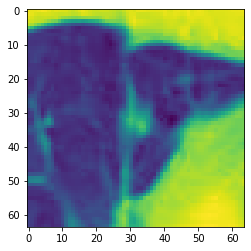

In [194]:
img = Image.open(cohort + "img_LIDC-IDRI-0526_1_59.jpg")
plt.imshow(img)

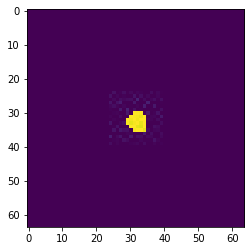

In [195]:
img = Image.open('/data/unet/val/masks/' + "mask_LIDC-IDRI-0526_1_59.jpg")
plt.imshow(img)

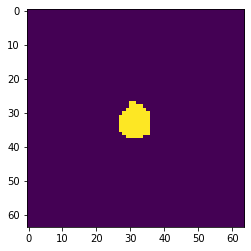

In [199]:
img = Image.open(cohort + "img_LIDC-IDRI-0526_1_59.jpg")
image = np.array(img).astype('float32')#vol[:,:,k_slice].astype('float32')
image -= np.mean(image)
image /= np.std(image)
image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
mask_pre = np.squeeze(mask_pre)
#  print(np.max(mask_pre), np.min(mask_pre))
#  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
mask_pre = np.where(mask_pre>0.5, 1,0)
plt.imshow(mask_pre)

In [ ]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    image = vol[:,:,k_slice].astype('float32')
    image -= np.mean(image)
    image /= np.std(image)
    image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
    mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    mask_pre = np.where(mask_pre>0.5, 1,0)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)